## Defining dataclasses and functions

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import json
import bisect
import math
import os
from datetime import datetime
import matplotlib.ticker as ticker

In [3]:
from dataclasses import dataclass


@dataclass
class SwapEstimate:
    symbolIn: str
    symbolOut: str
    decimalsIn: int
    decimalsOut: int
    estimatedAmountIn: int
    estimatedAmountOut: int
    usdAmountIn: float
    usdAmountOut: float
    estimatedEndSqrtPrice: int
    estimatedEndPrice: float
    estimatedFeeAmount: int
    isExceed: bool
    extraComputeLimit: int
    aToB: bool
    byAmountIn: bool
    amount: int
    priceImpactPct: float


@dataclass
class PriceImpact:
    price_impact: float
    a2b: SwapEstimate
    b2a: SwapEstimate


@dataclass
class PoolTicks:
    pool_name: str
    ticks: pd.DataFrame
    date: datetime
    file_name: str
    current_price: float
    current_sqrt_price: int
    ticks_filtered: pd.DataFrame
    max_price: float
    min_price: float
    price_impacts: [PriceImpact]
    a_symbol: str
    b_symbol: str
    a_decimals: int
    b_decimals: int
    a_amount: int
    b_amount: int
    usd_amount: float
    usd_a_amount: float
    usd_b_amount: float

In [4]:
# Function to find the index of the closest sqrt price
def find_closest_index_sqrt_price(ticks, sqrt_price) -> int:
    return bisect.bisect_left(ticks["sqrtPrice"], sqrt_price)


# Function to calculate liquidity depth for a single pool
def calculate_liquidity_depth(pool_ticks, sqrt_price):
    index = find_closest_index_sqrt_price(pool_ticks, sqrt_price)

    accumulated = 0
    liquidity = []

    for _, row in pool_ticks.iloc[index::-1].iterrows():
        accumulated += row["liquidityGross"]
        liquidity.append((row["price"], accumulated))

    accumulated = 0
    liquidity.reverse()

    for _, row in pool_ticks.iloc[index:].iterrows():
        accumulated += row["liquidityGross"]
        liquidity.append((row["price"], accumulated))

    return liquidity

# Function to calculate usd liquidity depth for a single pool
def calculate_liquidity_depth_usd(pool_ticks, sqrt_price):
    index = find_closest_index_sqrt_price(pool_ticks, sqrt_price)

    accumulated = 0
    liquidity = []

    for _, row in pool_ticks.iloc[index::-1].iterrows():
        accumulated += row["usdAmount"]
        liquidity.append((row["price"], accumulated))

    accumulated = 0
    liquidity.reverse()

    for _, row in pool_ticks.iloc[index:].iterrows():
        accumulated += row["usdAmount"]
        liquidity.append((row["price"], accumulated))

    return liquidity


# Function to filter the ticks based on price impact
def filter_price_impact(ticks, min_price, max_price):
    return ticks[(ticks["price"] >= min_price) & (ticks["price"] <= max_price)]


# Function to plot the liquidity depth
def plot_liquidity_depth(pool_ticks: PoolTicks):
    # Compute liquidity depth
    liquidity_depth = calculate_liquidity_depth_usd(pool_ticks.ticks_filtered, pool_ticks.current_sqrt_price)

    prices = [point[0] for point in liquidity_depth]
    accumulated_liquidity = [point[1] for point in liquidity_depth]

    # Plot all points with a continuous line
    plt.plot(prices, accumulated_liquidity, marker="", linestyle="-",
             label=f"Liquidity Depth {pool_ticks.pool_name}")

    # This makes all the points visible
    # for price, accumulated_liquidity in liquidity_depth:
    #     plt.plot(price, accumulated_liquidity, marker=".", linestyle="solid", label=f"")

    # Formatting the plot
    # plt.xscale("log")
    plt.xlabel("Price")
    plt.ylabel("Accumulated Liquidity (USD)")
    plt.title(f"Liquidity Depth for {pool_ticks.pool_name}")
    plt.grid(True)


# Plot tick index vs liquidity
def plot_liquidity(pool_ticks: PoolTicks):
    plt.plot(pool_ticks.ticks_filtered["price"], pool_ticks.ticks_filtered["usdAmount"], marker='', linestyle='-',
             label=f"Liquidity {pool_ticks.pool_name}")

    # for impact_level in impact_levels:
    #     plt.axvline(x=current_price * (1 + impact_level), color="red", linestyle="--",
    #                 label=f"Price Impact Level: {impact_level * 100}%")
    
    # Formatting the y-axis:
    # ax = plt.gca()  # Get the current axis
    # ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))  # Limit to ~6 major ticks
    # ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))  # Format to 2 decimals

    # Formatting the plot
    plt.xlabel("Tick Index")
    plt.ylabel("Liquidity (USD Amount)")
    plt.title(f"Liquidity Distribution Across Tick Indices for {pool_ticks.pool_name}")
    plt.grid(True)
    plt.tight_layout()

In [5]:
# Directory containing the tick data JSON files

# Prepare global variables
max_impact_level = 1  # 200%
min_impact_level = -0.5  # -50%

def fetch_ticks(poolAddress="", poolName = ""):
    data_directory = "ticks"
    json_file = sorted([f for f in os.listdir(data_directory) if f.endswith(".json") and f.startswith(poolName)])
    json_file = json_file[-1:]
    
    if json_file == []:
        print(f"⚠️ No tick files found for {poolName}")
        return None
    else:
        json_file = str(json_file[0])

    cut_left = json_file.find("]_")
    cut_right = json_file.find(".json")
    date_str = json_file[cut_left + 2:cut_right]
    try:
            date = datetime.strptime(date_str, '%Y_%m_%d_%H_%M_%S')
    except ValueError:
            print(f"Skipping file with invalid date format: {file_name}")

    try:
            with open(os.path.join(data_directory, json_file), "r") as file:
                tick_data = json.load(file)
                print(f"✅ Ticks fetched for {json_file}")
                
            # Check if the JSON is empty or invalid for a DataFrame
            if not tick_data:
                print(f"⚠️ Empty data in {json_file}")
                return None

    except (json.JSONDecodeError, ValueError) as e:
            print(f"❌ Error reading {json_file}: {e}")
            return None

    price_impacts_list = []

    for entry in tick_data["priceImpacts"]:
        a2b = SwapEstimate(
            symbolIn=entry["a2b"]["symbolIn"],
            symbolOut=entry["a2b"]["symbolOut"],
            decimalsIn=entry["a2b"]["decimalsIn"],
            decimalsOut=entry["a2b"]["decimalsOut"],
            estimatedAmountIn=int(entry["a2b"]["estimatedAmountIn"]),
            estimatedAmountOut=int(entry["a2b"]["estimatedAmountOut"]),
            usdAmountIn=float(entry["a2b"]["usdAmountIn"]),
            usdAmountOut=float(entry["a2b"]["usdAmountOut"]),
            estimatedEndSqrtPrice=int(entry["a2b"]["estimatedEndSqrtPrice"]),
            estimatedEndPrice=float(entry["a2b"]["estimatedEndPrice"]),
            estimatedFeeAmount=int(entry["a2b"]["estimatedFeeAmount"]),
            isExceed=entry["a2b"]["isExceed"],
            extraComputeLimit=entry["a2b"]["extraComputeLimit"],
            aToB=entry["a2b"]["aToB"],
            byAmountIn=entry["a2b"]["byAmountIn"],
            amount=int(entry["a2b"]["amount"]),
            priceImpactPct=float(entry["a2b"]["priceImpactPct"])
        )

        b2a = SwapEstimate(
            symbolIn=entry["b2a"]["symbolIn"],
            symbolOut=entry["b2a"]["symbolOut"],
            decimalsIn=entry["b2a"]["decimalsIn"],
            decimalsOut=entry["b2a"]["decimalsOut"],
            estimatedAmountIn=int(entry["b2a"]["estimatedAmountIn"]),
            estimatedAmountOut=int(entry["b2a"]["estimatedAmountOut"]),
            usdAmountIn=float(entry["b2a"]["usdAmountIn"]),
            usdAmountOut=float(entry["b2a"]["usdAmountOut"]),
            estimatedEndSqrtPrice=int(entry["b2a"]["estimatedEndSqrtPrice"]),
            estimatedEndPrice=float(entry["b2a"]["estimatedEndPrice"]),
            estimatedFeeAmount=int(entry["b2a"]["estimatedFeeAmount"]),
            isExceed=entry["b2a"]["isExceed"],
            extraComputeLimit=entry["b2a"]["extraComputeLimit"],
            aToB=entry["b2a"]["aToB"],
            byAmountIn=entry["b2a"]["byAmountIn"],
            amount=int(entry["b2a"]["amount"]),
            priceImpactPct=float(entry["b2a"]["priceImpactPct"])
        )

        price_impacts_list.append(PriceImpact(price_impact=entry["priceImpact"], a2b=a2b, b2a=b2a))

    # Create DataFrame
    df = pd.json_normalize(
        tick_data, 
        'ticks',
        ['poolAddress', 'feeTier', 'tickSpacing', 'currentTickIndex', 'currentPrice', 'currentSqrtPrice']
    )

    # Convert data types
    df["sqrtPrice"] = pd.to_numeric(df["sqrtPrice"], errors='coerce')
    df["liquidityGross"] = pd.to_numeric(df["liquidityGross"], errors='coerce')
    df["price"] = pd.to_numeric(df["price"], errors='coerce')
    df["usdAmount"] = pd.to_numeric(df["usdAmount"], errors='coerce')

    # Truncate all floats to 8 digits
    # df['price'] = df['price'].apply(lambda x: float(f"{x:.8f}"))

    current_sqrt_price = int(tick_data.get("currentSqrtPrice"))
    current_price = np.float64(tick_data.get('currentPrice'))

    max_price = current_price * (1 + max_impact_level)
    min_price = current_price * (1 + min_impact_level)

    ticks_filtered = filter_price_impact(df, min_price, max_price)
    ticks_filtered = ticks_filtered.reset_index()
    print(poolName)
    pool = PoolTicks(
        pool_name=poolName,
        ticks=df,
        date=date,
        file_name=json_file,
        current_price=current_price,
        current_sqrt_price=current_sqrt_price,
        ticks_filtered=ticks_filtered,
        max_price=max_price,
        min_price=min_price,
        price_impacts=price_impacts_list,
        a_symbol=tick_data["symbolA"],
        b_symbol=tick_data["symbolB"],
        a_decimals=int(tick_data["decimalsA"]),
        b_decimals=int(tick_data["decimalsB"]),
        a_amount=int(tick_data["coinAmountA"]),
        b_amount=int(tick_data["coinAmountB"]),
        usd_amount=np.float64(tick_data["usdAmount"]),
        usd_a_amount=np.float64(tick_data["accumulatedUsdAmountA"]),
        usd_b_amount=np.float64(tick_data["accumulatedUsdAmountB"]),
    )

    return pool

In [6]:
def fetch_pools(coinBName = ""): #function to fetch all pool jsons into dataframes

    # Directory containing the tick data JSON files
    data_directory = "pools"
    json_file = sorted([f for f in os.listdir(data_directory) if f.endswith(".json") and f.startswith(f"pools_SUI-{coinBName}")])
    json_file = json_file[-1:]
    
    if json_file == []:
        print(f"⚠️ No pool files found for {coinBName}")
        return None
    else:
        json_file = str(json_file[0])


    # with open(os.path.join(data_directory, file_name), "r") as file:
    try:
            with open(os.path.join(data_directory, json_file), "r") as file:
                pool_data = json.load(file)

            # Check if the JSON is empty or invalid for a DataFrame
            if not pool_data:
                print(f"⚠️ Empty data in {json_file}")
                return None
            else:
                pool_data = pd.DataFrame(pool_data)
                print(f"✅ Pools fetched for {json_file}")

    except (json.JSONDecodeError, ValueError) as e:
            print(f"❌ Error reading {json_file}: {e}")
            return None

    return pool_data

## Getting all coins info (skipping this part)

In [8]:
# fetch all coins information
"""
coins_headers = {
    "accept": "*/*",
    "x-api-key": "dXoCssStNAoNGD934PxfeMx6qck1UC"
}
url = "https://api.blockberry.one/sui/v1/coins?page=0&size=50&orderBy=ASC&sortBy=AGE&withImage=TRUE"
coins_response = requests.get(url, headers=coins_headers)
coinsdata = coins_response.json()

totalpages = coinsdata['totalPages']


url1 = "https://api.blockberry.one/sui/v1/coins?page="
url2 = "&size=50&orderBy=ASC&sortBy=AGE&withImage=TRUE"

coinsdf_new = pd.DataFrame()

coins_headers = {
    "accept": "*/*",
    "x-api-key": "dXoCssStNAoNGD934PxfeMx6qck1UC"
}



csv_file = "allcoins2.csv"

for page_number in range(0, totalpages):  #request all of the existing pages (it takes a long time so I used range to do it in batches)
    # Request the page JSON data
   coins_response = requests.get(f"{url1}{page_number}{url2}", headers=coins_headers)
   time.sleep(15)
   try:
        coinsdata = coins_response.json()  # Attempt to parse JSON
        print(f"Page {page_number}")
   except requests.exceptions.JSONDecodeError:
        print(f"Failed to parse JSON on page {page_number}")
       
   if 'content' in coinsdata and coinsdata['content']:
            # Extract data from the response
            page_data = coinsdata['content']
        
           # Convert the page data into a DataFrame and append it
            page_df = pd.DataFrame(page_data)
            coinsdf_new = pd.concat([coinsdf_new, page_df], ignore_index=True)
            # Move to the next page
            page_number += 1
            file_exists = os.path.isfile(csv_file)
            page_df.to_csv(csv_file, mode='a', index=False, header=not file_exists)

   else:
            # Proceed to the next page (to handle the blank pages)
            page_number += 1



coinsdf_new = coinsdf_new.drop_duplicates() #ensure no duplicates

coinsdf_new = coinsdf_new.sort_values(by= ["marketCap", "isVerified", "fdv", "holdersCount"], ascending=False) #sort coins

coinsdf_cleared = coinsdf_new.iloc[0:30000] #leave not important coins behind

coinsdf_cleared.to_csv("ALLcoinstop.csv", index=False) #save to csv
"""

'\ncoins_headers = {\n    "accept": "*/*",\n    "x-api-key": "dXoCssStNAoNGD934PxfeMx6qck1UC"\n}\nurl = "https://api.blockberry.one/sui/v1/coins?page=0&size=50&orderBy=ASC&sortBy=AGE&withImage=TRUE"\ncoins_response = requests.get(url, headers=coins_headers)\ncoinsdata = coins_response.json()\n\ntotalpages = coinsdata[\'totalPages\']\n\n\nurl1 = "https://api.blockberry.one/sui/v1/coins?page="\nurl2 = "&size=50&orderBy=ASC&sortBy=AGE&withImage=TRUE"\n\ncoinsdf_new = pd.DataFrame()\n\ncoins_headers = {\n    "accept": "*/*",\n    "x-api-key": "dXoCssStNAoNGD934PxfeMx6qck1UC"\n}\n\n\n\ncsv_file = "allcoins2.csv"\n\nfor page_number in range(0, totalpages):  #request all of the existing pages (it takes a long time so I used range to do it in batches)\n    # Request the page JSON data\n   coins_response = requests.get(f"{url1}{page_number}{url2}", headers=coins_headers)\n   time.sleep(15)\n   try:\n        coinsdata = coins_response.json()  # Attempt to parse JSON\n        print(f"Page {page_n

## Coins CSV loading and sorting

In [10]:
coins_all = pd.read_csv('ALLcoinstop.csv') #load the coins csv

coins_all_sort = coins_all.loc[(coins_all['price'] > 0) & ((coins_all['marketCap'].notna()) | ((coins_all['fdv'] > 1000000) & (coins_all['holdersCount'] > 1000)))] 
#sort coins

print(coins_all_sort.shape[0])

155


## Getting current SUI price

In [12]:
import subprocess
import time

In [13]:
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"
urlsui = "https://api.blockberry.one/sui/v1/coins/0x2%3A%3Asui%3A%3ASUI"  #getting the curent SUI price

headers = {
    "accept": "*/*",
    "x-api-key": "dXoCssStNAoNGD934PxfeMx6qck1UC"
}

responsesui = requests.get(urlsui, headers=headers)
responsesuij = responsesui.json()
suiprice = responsesuij['price']
print(suiprice)

2.24


## Fetching data on all pools for the selected coins

In [15]:
for _, row in coins_all_sort.iterrows():   # running typescript for fetching pool data based on the coin type
    coinB = row['coinType']
    coinBName = row['coinDenom']
    suiPrice = str(suiprice)
    try:
        subprocess.run(
            ["npx", "ts-node", "fetch_pools.ts", coinB, coinBName, suiPrice],
            check=True
        )
    except subprocess.CalledProcessError as e:
        print(f"No pools found for {coinBName}. Error: {e}")
        continue
    #time.sleep(0.2)

(node:62005) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: USDC-SUI[60] (0xb8d7d9e66a60c239e7a60110efcf8de6c705580ed924d0dde141f4a0e2c90105)
Fetched data for pool: USDC-SUI[10] (0x51e883ba7c0b566a26cbc8a94cd33eb0abd418a77cc1e60ad22fd9b1f29cd2ab)
Fetched data for pool: USDC-SUI[200] (0x03d7739b33fe221a830ff101042fa81fd19188feca04a335f7dea4e37c0fca81)
Fetched data for pool: USDC-SUI[2] (0x413ddc5745aa6398e9da66c4843947e479f4bf63bade39ffc94c9197b433b332)
Fetched data for pool: USDC-SUI[220] (0x85fe95c7d0fd3f743597bc78bbbe5ab2a2ee6ee4385232db1d48d4e42f31f6e5)
Fetched data for pool: USDC-SUI[20] (0x5371efd48be6560d47c40ba1d817c9b2c40ff40612c89cee44561b765a7954ca)
✅ Pool data saved to pools/pools_SUI-USDC_2025_03_18_20_15_01.json.json


(node:62017) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


⚠️ No data available for SUI-SUI. File not saved.


(node:62030) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: COIN-SUI[200] (0x52a1ab9d4c8915a38b14c2ac3314990e7596a5c28090b6191ff80f01078868ca)
Fetched data for pool: COIN-SUI[2] (0x4c11b87a90299c6542e505fb7054228f2244050953552412ecc6649176929273)
Fetched data for pool: COIN-SUI[60] (0xdfecef95b3b8aad6b74573458d29291fa5ca9575236ade7a0f716b8cfb6960b6)
Fetched data for pool: COIN-SUI[10] (0xc1168460f08a8daa38ed0d33abdee8637a43c1aab00e93da00a7f54b1590f2c2)
✅ Pool data saved to pools/pools_SUI-Bonk_2025_03_18_20_15_05.json.json


(node:62047) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: DEEP-SUI[60] (0xe01243f37f712ef87e556afb9b1d03d0fae13f96d324ec912daffc339dfdcbd2)
Fetched data for pool: DEEP-SUI[20] (0x2718b966172ae57e794758973c51bb107ac9916ac614e91f74cc99341bd177f0)
Fetched data for pool: DEEP-SUI[2] (0x727cfc14e8d53d1ee6d939b403d23bcaf26ee1a576c025ccc7327ffa41dc125a)
Fetched data for pool: DEEP-SUI[10] (0xd978d331772a5b90d5a4781e1232d18afd12019d0c35db79e3674beeda8f9126)
Fetched data for pool: DEEP-SUI[200] (0x5345196aaf2e58288c365c12d25318377b5366eaa76ea1807038a2c86fa2041a)
Fetched data for pool: DEEP-SUI[220] (0x174b5544c57f4646cf52a7b38709eacd57b2bf76001da8c73f63e2c8b4b5c111)
✅ Pool data saved to pools/pools_SUI-DEEP_2025_03_18_20_15_07.json.json


(node:62059) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: USDY-SUI[200] (0x304730a1992a44118d3165e657d725264f5cc269f1afd3443aedade6c062f71d)
Fetched data for pool: USDY-SUI[60] (0xd1a82baa34f705aad77b6f5427a8ea14123263c89d461e21359b8f169cecc23e)
Fetched data for pool: USDY-SUI[20] (0xee9df6faa89e68612e176fee07dd5d79cd2a44b99b416cdf42719c7b5bfb0d6f)
Fetched data for pool: USDY-SUI[2] (0x616a7da82c697957268b88f1c8dee08f8f577e3b35e435334fa132b6771dfb40)
Fetched data for pool: USDY-SUI[220] (0x07d71c7478e6de7dcf1e9778b0dce14fc923a08e26f0f2d46d3faa98f0802b30)
✅ Pool data saved to pools/pools_SUI-USDY_2025_03_18_20_15_10.json.json


(node:62072) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: COIN-SUI[200] (0x5a43a4388205053fc790d9139b3e7d5fb251f5fe21944d1bd2d6ed48a6f2f7ef)
✅ Pool data saved to pools/pools_SUI-stBTC_2025_03_18_20_15_12.json.json


(node:62084) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: SUDENG-SUI[60] (0xb785e6eed355c1f8367c06d2b0cb9303ab167f8359a129bb003891ee54c6fce0)
Fetched data for pool: SUDENG-SUI[200] (0x437807329065d62c950b2f5b3e1cbfd1ae72109643b8745648fced4f06a2248d)
Fetched data for pool: SUDENG-SUI[20] (0x2c8173d8b45999b8bd00ba576826b167dfd284498a8000d25fd46243eab1225f)
Fetched data for pool: SUDENG-SUI[220] (0x58f526495d95a22852765469add08643644533480c2e925d25e24b88fffa9e44)
Fetched data for pool: SUDENG-SUI[2] (0x373f1abe3571e51a4967dde43e0ff81ca43fa9f2080888e89497ecb5819e1277)
Fetched data for pool: SUDENG-SUI[10] (0x799092840fba55cab41eb2ee84ebaabe5a1f0a8294d5e5cdf5827e6c272e16ad)
✅ Pool data saved to pools/pools_SUI-HIPPO_2025_03_18_20_15_15.json.json


(node:62096) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: ALPHA-SUI[60] (0xda7347c3192a27ddac32e659c9d9cbed6f8c9d1344e605c71c8886d7b787d720)
Fetched data for pool: ALPHA-SUI[200] (0xf56f22e6b9da9581388b25b11747275d3e400f4adc22823450d988611aef3af6)
Fetched data for pool: ALPHA-SUI[2] (0x216fcf716fe6c60c9ddf9b727cfe99dc10f1a452d7454c188def767065a41657)
✅ Pool data saved to pools/pools_SUI-ALPHA_2025_03_18_20_15_17.json.json


(node:62108) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: CETUS-SUI[60] (0x2e041f3fd93646dcc877f783c1f2b7fa62d30271bdef1f21ef002cebf857bded)
Fetched data for pool: CETUS-SUI[20] (0xcf0766fa1b2f871bbaed5cf2f381a99f2a8c48db27df7d3c3f633dd54970dee2)
Fetched data for pool: CETUS-SUI[220] (0xcbfab71f5172d419c00866b993de4369a3f7bd9336c476bf1cbd5e30ec4d7dbc)
✅ Pool data saved to pools/pools_SUI-CETUS_2025_03_18_20_15_19.json.json


(node:62126) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: AXOL-SUI[60] (0x881bd6abac111854a32d766530c86cdba0bc3bfdc7cbb7c129862468bcba9b5c)
Fetched data for pool: AXOL-SUI[220] (0xf7c603101b89bb9975e5f69d32e50685e2aeb74c03b78b958b8e93ee1018d2e8)
Fetched data for pool: AXOL-SUI[10] (0xf7b62fccca6352e4995f0a9be1dae4f3a65456d3a9bb4204753b2c3ea0edc5ff)
Fetched data for pool: AXOL-SUI[200] (0xd17902c62eee1703b8f2b1782867f48a01ed9d9f29ca66a47ab1affffe4638a3)
✅ Pool data saved to pools/pools_SUI-AXOL_2025_03_18_20_15_22.json.json


(node:62138) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: NAVX-SUI[60] (0x0254747f5ca059a1972cd7f6016485d51392a3fde608107b93bbaebea550f703)
Fetched data for pool: NAVX-SUI[200] (0x1103d45a278ce3573d7667955762d83882e9b5f7ecb912089e2167be38279de7)
Fetched data for pool: NAVX-SUI[10] (0x73632143c70e94832b4a5c2dbe5fdec8133a4909ac0152ddc77e1ee646c1a3aa)
Fetched data for pool: NAVX-SUI[2] (0xb07a4768ba08bbe1e87f20cfa1e1d6fb4cf88b5f8ea11fa3cc570915c0c065a5)
✅ Pool data saved to pools/pools_SUI-NAVX_2025_03_18_20_15_24.json.json


(node:62150) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: BLUB-SUI[200] (0x40a372f9ee1989d76ceb8e50941b04468f8551d091fb8a5d7211522e42e60aaf)
Fetched data for pool: BLUB-SUI[60] (0x3f5871a18c0deeae9f740708ef8162e5f173bd93feae63897666738444e318f0)
Fetched data for pool: BLUB-SUI[220] (0x4f18120a94312dba0069b271600c43e5c151d2fcddc8be0b019940f1a9a647bf)
Fetched data for pool: BLUB-SUI[10] (0x4381ab7652971dede55c1e1df3e0bae17bcc3880ba3b25cc29e2e322d618c8f4)
Fetched data for pool: BLUB-SUI[20] (0x90771c478e05dd2a971c6cbb12b8615726bc00705c1e64dfcec21592f44bf57e)
Fetched data for pool: BLUB-SUI[2] (0x3030b21d1fe4afd2e230b8745c473b6869c9e5ea7f9e454f43a0b03190f500f4)
✅ Pool data saved to pools/pools_SUI-BLUB_2025_03_18_20_15_27.json.json


(node:62162) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: NS-SUI[60] (0x763f63cbada3a932c46972c6c6dcf1abd8a9a73331908a1d7ef24c2232d85520)
Fetched data for pool: NS-SUI[200] (0x9fd9d5f6d2f0f7928bc887475978abc7d8499066d3c84cc3b73db145781d2942)
Fetched data for pool: NS-SUI[220] (0xddf1ee214ac09469a640ac1b8f2c0cff2d64f613336a7ec2a87041f54b5fdba0)
Fetched data for pool: NS-SUI[2] (0x6cdecc41309b649cfbe0d57593e00d492277c72d8922a296937c2a18ab795b10)
Fetched data for pool: NS-SUI[20] (0xfffdd8a3120d708c30c6e227e38580c89d06359998e8ceed41128322410d6082)
Fetched data for pool: NS-SUI[10] (0x7b413f030ce0dbe2f81000d7eedd60585f68134339fe871741b0ddafdbc064d9)
✅ Pool data saved to pools/pools_SUI-NS_2025_03_18_20_15_29.json.json


(node:62174) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: SPRING_SUI-SUI[2] (0x5c5e87f0adf458b77cc48e17a7b81a0e7bc2e9c6c609b67c0851ef059a866f3a)
Fetched data for pool: SPRING_SUI-SUI[200] (0x9a4ef0adb78125e83070e678522933e1445b88914b3ebd3e3921eb69c658711c)
✅ Pool data saved to pools/pools_SUI-sSUI_2025_03_18_20_15_31.json.json


(node:62186) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/poolModule.ts:347
      throw new ClmmpoolsError(`Failed tp [arse response from ${url}].`, PoolErrorCode.PoolsNotFound)
            ^
ClmmpoolsError: Failed tp [arse response from https://api-sui.cetus.zone/v2/sui/stats_pools?order_by=-fees&limit=100&has_mining=true&has_farming=true&no_incentives=true&display_all_pools=true&coin_type=0x0000000000000000000000000000000000000000000000000000000000000002::sui::SUI,0xb66e9e1cd25e8be90091c4f20b42f0472ea22d4244f3bc2241891ed7ad2d80de::celer_pstake_coin::C

No pools found for PSTAKE. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xb66e9e1cd25e8be90091c4f20b42f0472ea22d4244f3bc2241891ed7ad2d80de::celer_pstake_coin::CELER_PSTAKE_COIN', 'PSTAKE', '2.24']' returned non-zero exit status 1.


(node:62198) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: AUSD-SUI[10] (0x4811c1f0cc996e1b8f5befbf91fe4652bd6ff79115f09391ba157b21820fc9c0)
Fetched data for pool: AUSD-SUI[20] (0x6ec261c1d23aa391a0ebedb501635cf1300005a1da630f57f932bc0e044dc9d1)
Fetched data for pool: AUSD-SUI[60] (0xc338987098ef734b6ae2824086fcab98a42bab324fc2b4c32611f803f5d2e61f)
✅ Pool data saved to pools/pools_SUI-AUSD_2025_03_18_20_15_36.json.json


(node:62216) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: SCA-SUI[200] (0x1341467c5aca847aff459e07d6a777a6fbf7aa7b71ffd66cc2f4bdfda162add4)
Fetched data for pool: SCA-SUI[60] (0xaa72bd551b25715b8f9d72f226fa02526bdf2e085a86faec7184230c5209bb6e)
Fetched data for pool: SCA-SUI[220] (0xe21960e1df5c21d282d72809eb3a55b503c57eb44444c4f811e9738905883754)
Fetched data for pool: SCA-SUI[2] (0x9661cca01a5b9b3536883568fa967a2943e237de11a97976795f5adb293892e9)
✅ Pool data saved to pools/pools_SUI-SCA_2025_03_18_20_15_38.json.json


(node:62228) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62240) ExperimentalWarning: CommonJS mo

No pools found for MOVE. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xd9f9b0b4f35276eecd1eea6985bfabe2a2bbd5575f9adb9162ccbdb4ddebde7f::smove::SMOVE', 'MOVE', '2.24']' returned non-zero exit status 1.
Fetched data for pool: AAA-SUI[200] (0xa0c8805dcf3914555bbc309a8b0ee1dcf144c3ed2a26995d20d7a1ea55656353)
Fetched data for pool: AAA-SUI[60] (0x68aef533cedb56041317ea8a829cba2d9294de16494e217e99fa1867d88c33a1)
Fetched data for pool: AAA-SUI[10] (0x9db6df78dbc06eb8e526965d5925db9dd81c2fc99a50020bd3b85c44b7a758c6)
Fetched data for pool: AAA-SUI[2] (0x1bdfd6e22a0f7d099460d36a81d4bf3d066d142db18d4996336fe17f7ea22cec)
✅ Pool data saved to pools/pools_SUI-AAA_2025_03_18_20_15_44.json.json


(node:62252) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: FUD-SUI[200] (0xfc6a11998f1acf1dd55acb58acd7716564049cfd5fd95e754b0b4fe9444f4c9d)
Fetched data for pool: FUD-SUI[2] (0x65abdfd9125959bd8e87bd02ffa8fff224d8da671b2159231a5ce121577f3537)
Fetched data for pool: FUD-SUI[10] (0x82cf4bd46f3a0acc30fced9dd99db2de8fa91752b494b23a745f0008185322d6)
Fetched data for pool: FUD-SUI[60] (0xe5f1d49b4d91900445eef459f50a864dc3685ad589786cdf1d41df7ca7632690)
✅ Pool data saved to pools/pools_SUI-FUD_2025_03_18_20_15_46.json.json


(node:62264) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: SUIP-SUI[220] (0x6ecc79747cb55718ca5023eaf745c2a4a1149ece9d4ad6f33590fd32d0e1f164)
Fetched data for pool: SUIP-SUI[200] (0x8049d009116269ac04ee14206b7afd8b64b5801279f85401ee4b39779f809134)
Fetched data for pool: SUIP-SUI[2] (0x25963a5d0152ab4bd371aa6c0183a3b44c7cf96492ddb17888b67210d0cb2bb1)
Fetched data for pool: SUIP-SUI[60] (0xb8a6b18fa8a9d773125b89e6def125a48c28e6d85d7e4f2e1424a62ffcef0bb5)
✅ Pool data saved to pools/pools_SUI-SUIP_2025_03_18_20_15_49.json.json


(node:62276) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: TURBOS-SUI[200] (0x381ee1563d5597d1e0423a01767560ed97fb99007d584a6e48d920b684357925)
Fetched data for pool: TURBOS-SUI[2] (0x2b1a133110b06e8b74858d58fae294d9af90f21355476e13214fa9d1d92cb429)
Fetched data for pool: TURBOS-SUI[60] (0xf0c6be26c85309e4021580fcb11192021627335ebc9f380a93f3908bddc38669)
Fetched data for pool: TURBOS-SUI[20] (0xa8d8acba12e1215741c9235f6f3efc490e149b8e40792681b4faf8f6a87be697)
Fetched data for pool: TURBOS-SUI[220] (0x107d57cc557823b68d2aacef1e260edf97a130990ba7139b97d0445211a451f9)
✅ Pool data saved to pools/pools_SUI-TURBOS_2025_03_18_20_15_51.json.json


(node:62294) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: SONIC-SUI[200] (0x3353c6ae880e383a7136b444d0af23eda0ca5ebc0d3a6dc48947f5870c5565ff)
✅ Pool data saved to pools/pools_SUI-Sonic_2025_03_18_20_15_54.json.json


(node:62306) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62318) ExperimentalWarning: CommonJS mo

No pools found for FLX. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x6dae8ca14311574fdfe555524ea48558e3d1360d1607d1c7f98af867e3b7976c::flx::FLX', 'FLX', '2.24']' returned non-zero exit status 1.
Fetched data for pool: TOKEN-SUI[200] (0x79d2d20005eb8f8ad6f18008a757db50ca75d57d1aa7bcef1052e55a20b37b28)
Fetched data for pool: TOKEN-SUI[220] (0x6062f20c776eb2ffd023fd7d783317af1d31d37743e4df65295ae69f5aa7c606)
Fetched data for pool: TOKEN-SUI[10] (0x4aa36799458c0392b9f48388e5bdc9e5da921a9e6917a1747ee09f245a38f422)
Fetched data for pool: TOKEN-SUI[60] (0xb4f56470e723c5a2fba4502f372a52891b88d8f62ff498c5b8267acd5b527b75)
Fetched data for pool: TOKEN-SUI[2] (0x6294908b7ca4069c1bfa26ead6b1e412ff416b9d88257833e077d25b3c8ea600)
✅ Pool data saved to pools/pools_SUI-SSWP_2025_03_18_20_15_58.json.json


(node:62330) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62342) ExperimentalWarning: CommonJS mo

No pools found for HSUI. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x8c47c0bde84b7056520a44f46c56383e714cc9b6a55e919d8736a34ec7ccb533::suicune::SUICUNE', 'HSUI', '2.24']' returned non-zero exit status 1.
Fetched data for pool: ARTFI-SUI[200] (0x1b8c2ba8c68ede6db23c7ac528acac6df527f6f522780c891f99fb3970d6370f)
✅ Pool data saved to pools/pools_SUI-ARTFI_2025_03_18_20_16_03.json.json


(node:62354) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: DRF-SUI[60] (0xbba38df125bfe2267af5ebb05d741b2a2364f5893d9ec2f8c856dba0f0365e32)
Fetched data for pool: DRF-SUI[200] (0x6daa2180eee6aa13e4578db0491e02ef624124019170a479deea6e0649aefbf0)
Fetched data for pool: DRF-SUI[10] (0x62fa6d493a92c262ef14fae1cfedec907c1935179fa840e5e09bd7d8cb0674e7)
Fetched data for pool: DRF-SUI[220] (0x008e9eed1a693270355c97960e49130dd76cf8c2e1c06f31a2bf7c417d63e539)
Fetched data for pool: DRF-SUI[2] (0x0c997c6132bb907c7925702ca693ec66d6ef5531387f7db227bf64ccd1c68afc)
✅ Pool data saved to pools/pools_SUI-DRF_2025_03_18_20_16_05.json.json


(node:62366) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62384) ExperimentalWarning: CommonJS mo

No pools found for SUIYAN. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xe0fbaffa16409259e431b3e1ff97bf6129641945b42e5e735c99aeda73a595ac::suiyan::SUIYAN', 'SUIYAN', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62396) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for E4C. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x84b27ddadc6139c7e8837fef6759eba4670ba3fc0679acd118b4e9252f834e29::e4c::E4C', 'E4C', '2.24']' returned non-zero exit status 1.
Fetched data for pool: TIMES-SUI[200] (0x84e323a3eb6256f2f3dd54b594b81ee91df8d9e1b4e1a020120f19ec0e0ed4da)
Fetched data for pool: TIMES-SUI[60] (0x9a61027e344b969f7798323ba67f4272b343980088e0d51ad5001b661baea6a6)
✅ Pool data saved to pools/pools_SUI-$TIMES_2025_03_18_20_16_12.json.json


(node:62408) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62420) ExperimentalWarning: CommonJS mo

No pools found for NAMI. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xe7397f9f6a5a60010a729ed1a470130936f090cafcdc0cdca6c3260b17ac0c9b::nami::NAMI', 'NAMI', '2.24']' returned non-zero exit status 1.
Fetched data for pool: PIGU-SUI[220] (0x72190d30b1c460e600719a204d299958558606df61ce8cf1d59d44303047f32f)
Fetched data for pool: PIGU-SUI[200] (0xb2b55c12c12e6d870bacb894b2966679ac93fab01940e0db3fe95824c0d8e764)
✅ Pool data saved to pools/pools_SUI-PIGU_2025_03_18_20_16_17.json.json


(node:62432) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62444) ExperimentalWarning: CommonJS mo

No pools found for SUIJAK. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xd9773016f31a1216fb0a1e0b0937f09687663807e8cb8a19ba5a12f2f5dcab88::suijak::SUIJAK', 'SUIJAK', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/poolModule.ts:347
      throw new ClmmpoolsError(`Failed tp [arse response from ${url}].`, PoolErrorCode.PoolsNotFound)
            ^
ClmmpoolsError: Failed tp [arse response from https://api-sui.cetus.zone/v2/sui/stats_pools?order_by=-fees&limit=100&has_mining=true&has_farming=true&no_incentives=true&display_all_pools=true&coin_type=0x0000000000000000000000000000000000000000000000000000000000000002::sui::SUI,0x492ff7bc419c2502604980c486aa291d48f7ffc10e8073f38c59329491f106d5::coin::COIN].
    at PoolModule.getPoolByCoins (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/poolModule.ts:347:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'PoolsNotFound'
}


No pools found for COIN. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x492ff7bc419c2502604980c486aa291d48f7ffc10e8073f38c59329491f106d5::coin::COIN', 'COIN', '2.24']' returned non-zero exit status 1.


(node:62456) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62474) ExperimentalWarning: CommonJS mo

No pools found for SUIMON. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xc0ba93a810adb498900c82bb6f7c16ca3046dfa7b6f364ec985595fdeb1ee9ad::suimon::SUIMON', 'SUIMON', '2.24']' returned non-zero exit status 1.
Fetched data for pool: SCB-SUI[200] (0xb641e90f7b28604d858ef855af72282eb01b1a9c6d0ad9725ceec00011168f8a)
Fetched data for pool: SCB-SUI[60] (0xbc49bd0a3b476825e7157567a615cd3d2154c76d72df8e81da0c0a0eabaa3e97)
Fetched data for pool: SCB-SUI[10] (0x768cafa6cb07b26e6921a13a4a0289869405de278e9e62412655da35422989cd)
✅ Pool data saved to pools/pools_SUI-SCB_2025_03_18_20_16_26.json.json


(node:62486) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62498) ExperimentalWarning: CommonJS mo

No pools found for Bull. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xb0b6d9fa117da4f47c4895c4216cd3cad37d3b2f4425c62dbd4f4638b44e3f93::bull::BULL', 'Bull', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62510) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for BEEG. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x727458212ca0be056d9ccc0d42981bdf41109779fbd9c7fad56c4456e0c3d0c6::beeg::BEEG', 'BEEG', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62522) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for Ronda. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xdc9b462697876ff4c680e59b3756ac39a6899cfbc355a6880c60e01c8930b3cc::ronda::RONDA', 'Ronda', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62540) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for suishi. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xebb4eb552f807a28a1601e804ccaf91796ddc46407ba1b07381333111ed29d46::suishi::SUISHI', 'suishi', '2.24']' returned non-zero exit status 1.
Fetched data for pool: SUIMAN-SUI[2] (0x127b7cf262607a0bc6e1035bed13883d342b0a0c04ce60fc51b5ffbdd03a6983)
Fetched data for pool: SUIMAN-SUI[200] (0x09c6c673260bef5bb17b02c40c77601181eb3d8e88292eb5cc131d83a6b9cc5a)
Fetched data for pool: SUIMAN-SUI[220] (0x01ba5090455d9e5cec4bc22e2e0c67488a15b64eb17f94a8e0553171dd6c7c8a)
Fetched data for pool: SUIMAN-SUI[10] (0x968b88c53314f8c5b2106e1ab962cc47ecb71c4feffb216b63dc57a165e5ffb6)
Fetched data for pool: SUIMAN-SUI[60] (0x92de82a836817e69b16b609620792a18150267cd97ec59537d8c3b2468494fc7)
✅ Pool data saved to pools/pools_SUI-suiman_2025_03_18_20_16_38.json.json


(node:62552) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: PLOP-SUI[200] (0xd928166e7866f88484722cd4200c3ea6f521ba7f2d4d3e82757f8da30d8810ad)
Fetched data for pool: PLOP-SUI[220] (0x78993846950038eec5ee11a6d6dd55162f39d54d7bfdfe519f04aba57f21a9b3)
✅ Pool data saved to pools/pools_SUI-PLOP_2025_03_18_20_16_41.json.json


(node:62570) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: DAM-SUI[2] (0x3487e99bda85bd17360e2c32af208df69551e0673f920e8906404c32e9a47fa0)
Fetched data for pool: DAM-SUI[200] (0xf5fa52eb2f71c6a946c157d6ba51b015a4f1d21a6ce54b6836eb6f1ff869dad3)
Fetched data for pool: DAM-SUI[220] (0x723f13d68d434189ead38d54ac4dc52a7c9051d1b9c0977483807d22ca0d70be)
✅ Pool data saved to pools/pools_SUI-DAM_2025_03_18_20_16_44.json.json


(node:62582) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}


No pools found for Hopper. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xd7b720a37be0f5540e2499c989cbab660ae6b64f28ec54ceeea68ad3936b8d41::hopper::HOPPER', 'Hopper', '2.24']' returned non-zero exit status 1.


(node:62594) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: KOI-SUI[200] (0xea18d910c4f7e5c850f1e730dfda8228d710962e50cc31ef28d211c54108e02a)
✅ Pool data saved to pools/pools_SUI-KOI_2025_03_18_20_16_49.json.json


(node:62606) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62618) ExperimentalWarning: CommonJS mo

No pools found for SHORK. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x80a4b8e2fbc6b5741a301e2295e431c3ca54ad7ff0b20291c433c05cb53b35ce::shork::SHORK', 'SHORK', '2.24']' returned non-zero exit status 1.
Fetched data for pool: SUITARD-SUI[2] (0x3ac800ea40ac5fc2b210e0264cfcd90654cbadc236744b816ba2b793f6c46155)
Fetched data for pool: SUITARD-SUI[200] (0x960d673274597d9ac471044d4a94740dacd9e5039217397ea44cd9f994ff55de)
✅ Pool data saved to pools/pools_SUI-STD_2025_03_18_20_16_53.json.json


(node:62630) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62649) ExperimentalWarning: CommonJS mo

No pools found for WATER. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xb713342104cd25efe0333e481d1caf2c3650b258ec3f3a0b3f6765cd3582624b::water::WATER', 'WATER', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62661) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for SUICY. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x8989c726bf1ea8736919e41938f3801e286bc71d9612bfe250703232a375eaab::suicy::SUICY', 'SUICY', '2.24']' returned non-zero exit status 1.
Fetched data for pool: REAP_TOKEN-SUI[200] (0x223671d0ede48df7c9daa4002056b241dbc28c30b3790d2319fd76b9290759ab)
✅ Pool data saved to pools/pools_SUI-REAP_2025_03_18_20_17_01.json.json


(node:62673) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: SCUBA-SUI[2] (0xa8593858a7dfb15abd4c995ed7f2ab2ffc4f18a6d953e982361bd0c7fa595463)
Fetched data for pool: SCUBA-SUI[200] (0x6ef53d0a227e29cd5c49cc300adf0f3d60a7bf7cf74ae04b8e898f7311eba9e7)
Fetched data for pool: SCUBA-SUI[220] (0x0645b9d51d39d2de3f25288464570af0e050a6b8eb42c868f06946421d31c359)
Fetched data for pool: SCUBA-SUI[60] (0x764e58fd56c68b5ccf5fd8a862ae288b47403f4968692b762f82838409a513bd)
✅ Pool data saved to pools/pools_SUI-SCUBA_2025_03_18_20_17_03.json.json


(node:62685) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62697) ExperimentalWarning: CommonJS mo

No pools found for tusk. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x1fc50c2a9edf1497011c793cb5c88fd5f257fd7009e85a489392f388b1118f82::tusk::TUSK', 'tusk', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62709) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for Suieet. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xc0967b3bd5cce1382bd8e511af06a34794a6efd2726e680b0711e19393fe9023::suieet::SUIEET', 'Suieet', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62721) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for DAWG. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x8b42bf0fa7326deb111f03f31ba236adc6a5148d0c966a44f3f2a3dd8fbb3c75::dawg::DAWG', 'DAWG', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62739) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for BOYSS. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x761feb1492359aa2160a07500c00bbe99fa904ea130552fc5ad07b448733be46::boyss::BOYSS', 'BOYSS', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62751) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for BLUBIA. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x3c524ee86d6a655dc199f50c5fc69af4d4eb75fae5901f5756b0436a31681c61::blubia::BLUBIA', 'BLUBIA', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62763) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for SUIDOG. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xa224eea12f683adac14ca236dc8d471061fcfc7de8635ddb72b98a02897e78e1::suidog::SUIDOG', 'SUIDOG', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62775) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for SULLY. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xf300d024edb85b05b8845937b05f6624058406908439e8ddd4e5796ca75efd6e::sully::SULLY', 'SULLY', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62787) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for SUICAT. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x0bffc4f0333fb1256431156395a93fc252432152b0ff732197e8459a365e5a9f::suicat::SUICAT', 'SUICAT', '2.24']' returned non-zero exit status 1.
Fetched data for pool: DAK-SUI[2] (0x6c40c71d281704ee29cf1b9fada2c10ce4f2d7d374c283c79ae8d78ca6290762)
Fetched data for pool: DAK-SUI[10] (0x378c2a63e222907146d6287378e18cfafac682af70cb4cf4f696e324f9cad3a7)
Fetched data for pool: DAK-SUI[60] (0x2fada18386d4c4fac905452e27d58b6c717081861bd0d96aed7f826387230cf0)
Fetched data for pool: DAK-SUI[200] (0xfc218b35949ac08ba5655299c41a7760b20c3f168f1387e3854ebf13b3ac8dea)
✅ Pool data saved to pools/pools_SUI-dak_2025_03_18_20_17_23.json.json


(node:62799) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62811) ExperimentalWarning: CommonJS mo

No pools found for KONG. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xb0c3e7ae67c9161273aab9a06e589c1c13479337d14c794251a97df46822f2cb::kong::KONG', 'KONG', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62829) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for TISM. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x6612c8419c70a706612e154ffcc0ef21b3fec6e4008b4b775ceae4e894d3484d::tism::TISM', 'TISM', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62841) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for BUBL. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x35b59a0d8707764cde2345e4a3acd025b73d3d639308e49df00eff7eec821d46::bubl::BUBL', 'BUBL', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62853) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for XUI. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x3cbae4efb916a6ff23eb4724f6fb5d37c5a342b689a6f308fa10acc944799f84::xui::XUI', 'XUI', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:62865) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for BSWT. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xf0fe2210b4f0c4e3aff7ed147f14980cf14f1114c6ad8fd531ab748ccf33373b::bswt::BSWT', 'BSWT', '2.24']' returned non-zero exit status 1.
Fetched data for pool: COIN-SUI[60] (0xcf994611fd4c48e277ce3ffd4d4364c914af2c3cbb05f7bf6facd371de688630)
Fetched data for pool: COIN-SUI[220] (0xfb06a53a2a4cf517c02b24126df04187881c8e92f177bbcc362e8dd8e83f3835)
✅ Pool data saved to pools/pools_SUI-USDC_2025_03_18_20_17_37.json.json


(node:62877) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: AFSUI-SUI[2] (0xa528b26eae41bcfca488a9feaa3dca614b2a1d9b9b5c78c256918ced051d4c50)
✅ Pool data saved to pools/pools_SUI-AFSUI_2025_03_18_20_17_39.json.json


(node:62889) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: CERT-SUI[2] (0x6c545e78638c8c1db7a48b282bb8ca79da107993fcb185f75cedc1f5adb2f535)
Fetched data for pool: CERT-SUI[20] (0x48ab2d1ad1d1750d74279d7f31e25618ecb112092a5c4d29a2cb474ea455fe8a)
Fetched data for pool: CERT-SUI[10] (0x22db6d5e6f977bb2d25276f24be942f0c41df9adadb2ffdc23e44420d8e542e6)
Fetched data for pool: CERT-SUI[60] (0xe6441fee8d7a0acaf34ca868b98d4acff159b3237bd12bbfa168b20d22c6ed24)
✅ Pool data saved to pools/pools_SUI-vSUI_2025_03_18_20_17_42.json.json


(node:62902) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: COIN-SUI[200] (0xe0c526aa27d1729931d0051a318d795ad0299998898e4287d9da1bf095b49658)
Fetched data for pool: COIN-SUI[60] (0x247e15264abfb27fad09664cbdb8a9a46bb80c05e3861a979dc971e28e43b204)
Fetched data for pool: COIN-SUI[220] (0xe38621cf17f3374ec2982b12129e7246c2cf10c55d98191fd2c0ad90c2357cd2)
Fetched data for pool: COIN-SUI[10] (0x815b175fea4e8a36165978ab1f0901d94527b4e9a37ede1153bfc66725a7f6d4)
Fetched data for pool: COIN-SUI[20] (0x643cdc68f80121e2592a767f832b9666a8752636c70aa9d12ac6f448cf9e32ec)
Fetched data for pool: COIN-SUI[2] (0xdecb63ed2757cf3feb2624d514bb704b332b5bd7059b4a2c1f4e5774941a9bb9)
✅ Pool data saved to pools/pools_SUI-WBTC_2025_03_18_20_17_45.json.json


(node:62920) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: COIN-SUI[200] (0xc51752c87e7363dec32bb429cabcb7774aaabb45fa5d2c17edfbb59bd6d1deb0)
Fetched data for pool: COIN-SUI[60] (0xd715f61043de8e024203f1aad40bc1cb5bf401cecd6fde9947acca94290448fa)
Fetched data for pool: COIN-SUI[10] (0xbf6e8d5e563a76906cd69035360f886ed56642f764b5f77a96b85b118584abdd)
Fetched data for pool: COIN-SUI[220] (0x8f1c26e25926dddbaa85e464d53d21097bc9c492b6e739726c44a60c02c7749d)
Fetched data for pool: COIN-SUI[2] (0x870f310ff9e3faf1e9c97c8538d5abd53801a13b0d32b0c12498221b1207baf6)
✅ Pool data saved to pools/pools_SUI-WETH_2025_03_18_20_17_47.json.json


(node:62935) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: COIN-SUI[200] (0xebd9caafbcde905a4c6ba3a82dddbf021dbb3dbb609a91984b30012e5f6843bf)
Fetched data for pool: COIN-SUI[60] (0xdb04204bdc87718dc379c0f7507e5dd8db9892d8f37e405d7d21736c737881ec)
Fetched data for pool: COIN-SUI[10] (0x9d05a9054bca428420cdda9f3b8b153060edfebed7d54f85d6422d27d411496f)
✅ Pool data saved to pools/pools_SUI-APT_2025_03_18_20_17_50.json.json


(node:62949) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: HASUI-SUI[2] (0x871d8a227114f375170f149f7e9d45be822dd003eba225e83c05ac80828596bc)
Fetched data for pool: HASUI-SUI[220] (0x2537d30ba2c7d518bda846fcbacc255cbbde68ae3baa55b359822f762f09e013)
Fetched data for pool: HASUI-SUI[200] (0x413cb7daa915c2e791a4d2051430501539eaf783c09d3705d9fbfea1fe984988)
Fetched data for pool: HASUI-SUI[20] (0x354942f46805c68f17231686944012a9de90b77b247e9182bfe0a23856923cc9)
Fetched data for pool: HASUI-SUI[60] (0x3a0b871a93c1214ec069acace9f7c7df436aae91e59b4754dbcf238d4e91d388)
Fetched data for pool: HASUI-SUI[10] (0xda2311875f3085217a5ef632ba336abfbd2a97f20528bdec3f1d799527c5d407)
✅ Pool data saved to pools/pools_SUI-haSUI_2025_03_18_20_17_52.json.json


(node:62961) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: TYPUS-SUI[60] (0xa467d2dee561bca8e7b3f5f1622f0fa1cb672befae69a0d1b6dced941c858c4e)
Fetched data for pool: TYPUS-SUI[20] (0xd0f5a63103ad9a3a452bb75d155c7c2a7e543e32082d79fb142ba786a12fe637)
Fetched data for pool: TYPUS-SUI[200] (0xcccc8d7bf93f5f0ad802315b97304cdebd70b4bc3f15500442500e632e096dd9)
✅ Pool data saved to pools/pools_SUI-TYPUS_2025_03_18_20_17_55.json.json


(node:62974) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: ETH-SUI[60] (0x7079378d20cb521acc9a77c0d69da0e4b65cc07b2a1666868c95444939c3929e)
Fetched data for pool: ETH-SUI[200] (0x87a67295614b52dc800e9b1ab2219de22b63f63bae70622ddae5dac334ab0033)
Fetched data for pool: ETH-SUI[2] (0x70f318397f54524bb043ecb5242cf2f93ea2b067ea5207b1b49bb9e3d389d5c0)
Fetched data for pool: ETH-SUI[10] (0xef3ea285f965bfa2b95cdf462c035e1cfdedf208d867200f1e99a334eb5cd56a)
✅ Pool data saved to pools/pools_SUI-ETH_2025_03_18_20_17_57.json.json


(node:62986) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: BUCK-SUI[10] (0x59cf0d333464ad29443d92bfd2ddfd1f794c5830141a5ee4a815d1ef3395bf6c)
Fetched data for pool: BUCK-SUI[60] (0x9379d2d3f221dcea70f7f7d4a7bf30bab0128bcfda0d13a85267e51f7e6e15c0)
Fetched data for pool: BUCK-SUI[20] (0x31ef6d246098bf3047fe51d5d2a301295ce35c43ca6b02c991c1d01be74b49ba)
Fetched data for pool: BUCK-SUI[200] (0x218b9dcd171f3456992e4bdf92c1df3485517d72aa1dda3e353df6bc6c844fde)
Fetched data for pool: BUCK-SUI[2] (0xf502e9fe6694d342fa490e69de97d19234fbacff9bb54ece48c808e346fe5562)
Fetched data for pool: BUCK-SUI[220] (0x82350baa4536975b58d9c0b53389b45fc3470c5bf9b4515be80e4ff076a25bf0)
✅ Pool data saved to pools/pools_SUI-BUCK_2025_03_18_20_18_00.json.json


(node:63008) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: SCALLOP_SUI-SUI[60] (0x2e19f28758d795d8cfd6b85395c283ee395139d0bdbe9e6665824187285943fb)
Fetched data for pool: SCALLOP_SUI-SUI[200] (0x620cba9c9f8372520cf4bda84488cd30cf43e43e877aa310f7ee73552f36eb03)
Fetched data for pool: SCALLOP_SUI-SUI[2] (0x4d4b3d1db47e91d5df7ded14d3e4428111214148d410135baa57aa2049902898)
✅ Pool data saved to pools/pools_SUI-sSUI_2025_03_18_20_18_03.json.json


(node:63021) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: MEMEFI-SUI[200] (0x2f47d887c4ca1640c48946676dc3ccb40025cdb0aa52f21d6b043568a7c39ffe)
✅ Pool data saved to pools/pools_SUI-MEMEFI_2025_03_18_20_18_05.json.json


(node:63033) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: COIN-SUI[60] (0xf45b01f23e9951e37733b76c8cc7d22dcd23141aa246a86e17595a7aca610e1d)
Fetched data for pool: COIN-SUI[200] (0x014abe87a6669bec41edcaa95aab35763466acb26a46d551325b07808f0c59c1)
Fetched data for pool: COIN-SUI[220] (0x79211a6efc6c05b0f1fd557cc56990778422353cef082c7b2436a33046574916)
✅ Pool data saved to pools/pools_SUI-SOL_2025_03_18_20_18_08.json.json


(node:63045) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: SUIA_TOKEN-SUI[60] (0xbcf18ddb425dfc3207d57b83e8d105ef11b502a1b6072a8026e3716ac535b035)
Fetched data for pool: SUIA_TOKEN-SUI[10] (0xd1f25b0cf1e11bd08ce6d78334376a857db8bb5cd1443fa150004f0d4c4be11d)
Fetched data for pool: SUIA_TOKEN-SUI[200] (0x1b76f29f03b583db64059ab370dcdf17665841c2f8b19f0e95a6cfe5a602e01a)
✅ Pool data saved to pools/pools_SUI-SUIA_2025_03_18_20_18_10.json.json


(node:63057) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63069) ExperimentalWarning: CommonJS mo

No pools found for MOAI. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x6b532a00a8799fb744f6802d3cde6223613e904983ebfeaba4ae8cbac096c7c8::moai::MOAI', 'MOAI', '2.24']' returned non-zero exit status 1.
Fetched data for pool: SPT-SUI[200] (0xb9190f66b171ce62c29614f90235d7127c6183215cb89bcd843097496c5bbb29)
Fetched data for pool: SPT-SUI[60] (0x201853fab5a88cd0b77408347f60d8b755b9a57a64b30b9aae5fa1568f61c98d)
✅ Pool data saved to pools/pools_SUI-SPT_2025_03_18_20_18_15.json.json


(node:63087) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: UNI-SUI[60] (0xc905c9263609d6ea700ff6267978107336beab3df377d58a1c53f6e25b7630ee)
Fetched data for pool: UNI-SUI[220] (0xbed5973d1dee2de1772c78fdece1e9e3577ffd9c15f3124ecec6aba6732e63ac)
Fetched data for pool: UNI-SUI[200] (0x5829a3242175cfeb91802e2ae5559f5d4f17db7a12aae464de050b47d2eddd77)
✅ Pool data saved to pools/pools_SUI-Uni_2025_03_18_20_18_18.json.json


(node:63099) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: COIN-SUI[200] (0x5ce0c698819cec55d2f6a08cc07f76f934a66648bbca9f8d33c1c961ffd8a0eb)
Fetched data for pool: COIN-SUI[220] (0x3aa63be8ac4f22ff65d3bec598ce168797c041cae12c9fcc3e5f1fc7ced60403)
Fetched data for pool: COIN-SUI[2] (0x45fbcfaed3359f9e266395a1d5861d680fcff9227940368dd331aea265a92f6a)
✅ Pool data saved to pools/pools_SUI-WBNB_2025_03_18_20_18_20.json.json


(node:63111) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Fetched data for pool: OCEANS-SUI[60] (0xaa0657731ad4f99c6694dab2f9159d1bbfafaa7f1f889ebd2622c3c74e7037d4)
Fetched data for pool: OCEANS-SUI[10] (0x706af723612b375147f04064cc9378c7c8125b56604e63b6f6b40e9a2b8cfc40)
Fetched data for pool: OCEANS-SUI[200] (0x61a634fb4c1f18db8894702c2a981ba816c51668c4cff5c7b5125644ff54aa93)
✅ Pool data saved to pools/pools_SUI-OCEANS_2025_03_18_20_18_23.json.json


(node:63123) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63135) ExperimentalWarning: CommonJS mo

No pools found for EXOTIC. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x71f2876b46ced7ce105c97f5ddfe1342a422938a88d342843fd8b2decdc27271::exotic::EXOTIC', 'EXOTIC', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63147) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for VAPOREON. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x84d155fb70aebcc1391bf497d8fc139154be745765dfec57faef4704f4112c79::vaporeon::VAPOREON', 'VAPOREON', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63159) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for CHAD. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xd492bd64721ce3ae4add8c1263755f210ce15ba7809e4eeb20479f74fc967864::chad::CHAD', 'CHAD', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63177) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for ROLEX. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x2fa786ad2a65174e2458e5ebc7348904e9f9782b730e2e07dd2dd793cb04c4db::rolex::ROLEX', 'ROLEX', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}


No pools found for LAMA. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x9cfca0061e5c920cd09ba39fa0ce27b73d97ac296eece7d3a44db3d818c35aad::lama::LAMA', 'LAMA', '2.24']' returned non-zero exit status 1.


(node:63189) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63202) ExperimentalWarning: CommonJS mo

No pools found for NotGAY. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x895de1538ab63fa41efd7b4e538ad678c9cf15f9bf4fef08fc8d17ccbed2b50b::notgay::NOTGAY', 'NotGAY', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63221) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for CHILLGUY. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x58013df93d3c00db9ee0b34007357db7a2a94f5f3deecb3cac5fad7beffe150f::chillguy::CHILLGUY', 'CHILLGUY', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63234) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for SQAI. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xa793d921dab2318a8a955c6109f6d5d2c06b2820d8078757ed48e2d5d4e69ebd::sqai::SQAI', 'SQAI', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63246) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for NEMO. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xaaa301f856bd18908ca0c9087a48c0fc144bd045337bf4789276a6cde05eb3f2::nemo::NEMO', 'NEMO', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}


No pools found for BCB. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xbd6d695956c395044eb2db780c3da140349fef5772baec1132b2cc87e0ada626::bcb::BCB', 'BCB', '2.24']' returned non-zero exit status 1.


(node:63260) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63278) ExperimentalWarning: CommonJS mo

No pools found for ZEREBRO. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xe6294326e26b679437c2fa9dd624ccef9fa47efa77c61cbc57f6521577b5695f::zerebro::ZEREBRO', 'ZEREBRO', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}


No pools found for CHILLT. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xad271f120e40c2b9a3524fbcbb08cd4b2d336479e9ef12ac65caa5c861c58bc9::chillt::CHILLT', 'CHILLT', '2.24']' returned non-zero exit status 1.


(node:63293) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}


No pools found for POGE. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xf87ab3b5c6534ced814f0495362f90c9ef516618b10ccd23895ff75ff219fd22::poge::POGE', 'POGE', '2.24']' returned non-zero exit status 1.


(node:63306) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63318) ExperimentalWarning: CommonJS mo

No pools found for SQAI. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x7a0af9f573e3c24102b07eedeab7f722902e82dbed9c12acb67d55ade91ad966::sqai::SQAI', 'SQAI', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63331) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for AIECOM. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x4b6a40ca23e3e0e9a306180af7731e148f0da61c4e310f0242943e0618c17b5b::aiecom::AIECOM', 'AIECOM', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63345) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for MQAI. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xa522d6f28a13f73dc1561e0d94fa7e710f3a8aadca5a758d4c804456528e5a5e::mqai::MQAI', 'MQAI', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63363) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for FINE. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x5e84e642b3ab53950d88306d1995ea4f3744ece57b8f93da969b07156966afec::fine::FINE', 'FINE', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63375) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for SHARKY. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x109e744c47c0595d9766e36dca9febc49b285faa1cd8a48c14c2c30980a8906e::sharky::SHARKY', 'SHARKY', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63387) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for CDEX. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x888e73210b60fc6a3f81f443b094176fe8e4260a864f524a48fa7461fd676e4e::cdex::CDEX', 'CDEX', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63399) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for BETCH. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x344576fbb945e5bd98869581751d4d15d97e2e134e86f5b566a67e0eb8fbfc6f::betch::BETCH', 'BETCH', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63411) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for SKG6368. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x3d8e2da3b30bce41cccf7c76f20c08b3b4a3f5943454e245cb0b08c9cecebd36::skg6368::SKG6368', 'SKG6368', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63423) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for SOLCAT. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x4ae510c69267c6198f70110e714d52f47b3caf2367386845b5ea0b35563e71f9::solcat::SOLCAT', 'SOLCAT', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63436) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for CHILLGUY. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x33708753ae24af796db20c9ecedb510e2e3c71dcd38daa5209a1578610a03a08::chillguy::CHILLGUY', 'CHILLGUY', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63453) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for CetusDAO. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x2e8e9b524bd719960b8f4bbe4bb9d0e1ada24c19bdc25835153c0a14f1299ce4::cetusdao::CETUSDAO', 'CetusDAO', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63465) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for LofiGirl. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x60e6ce2d475865234ae800c2859b2b118028b9fdb5dcba0349477e979729b0b7::lofigirl::LOFIGIRL', 'LofiGirl', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63477) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for DDOGE. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x3f65c75e5fc50ca5176b226d8a34d1ba308f6cabc9114446ff366557128e27d0::ddoge::DDOGE', 'DDOGE', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}


No pools found for BPEPE. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x24f494fb28ee336eae5d21ba74c4283aa1c1716cb73f544baaa9f4ba7704be6c::bpepe::BPEPE', 'BPEPE', '2.24']' returned non-zero exit status 1.


(node:63489) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63501) ExperimentalWarning: CommonJS mo

No pools found for IMAGINE. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x87bb75a8cd759d22c5ffc2cb0e61feff727e893cbf12a20db2dfb1638b9e7799::imagine::IMAGINE', 'IMAGINE', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}


No pools found for BARK. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x2c5231cfc4af69f41af34da673541e9401fd38e377679e78c9900253ae70af97::bark::BARK', 'BARK', '2.24']' returned non-zero exit status 1.


(node:63513) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63531) ExperimentalWarning: CommonJS mo

No pools found for ANITA. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x4cdb9ace9d31da3a5939e0202fcc1b9fd9a9971409df59895c1893cb5568fda5::anita::ANITA', 'ANITA', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63543) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for PEANUT. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x40374c9f5289ce659db316dd16b3bf5643c9d8d45a8e017de379acc9db3554dc::peanut::PEANUT', 'PEANUT', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63556) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for BEWO. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x37868f74e62444eab97dc53851c82c5f16c07fdc7f2f1e5dc707137448017c37::bewo::BEWO', 'BEWO', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}


No pools found for CHIIKAWA. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x402c758c2d89f911b8d7f775736669621c44dbaeedf76dba56077622ef79b8c6::chiikawa::CHIIKAWA', 'CHIIKAWA', '2.24']' returned non-zero exit status 1.


(node:63568) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}


No pools found for KOHIME. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x081fc6a77eda3ebf7dd0905651af4d91a85adf4c8c41773a1022f3ae9fe6568e::kohime::KOHIME', 'KOHIME', '2.24']' returned non-zero exit status 1.


(node:63582) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63594) ExperimentalWarning: CommonJS mo

No pools found for MAGABA. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x5eb1120eee2dd8a7ee23ce49b8680be7f604972a7936d0fdc3cd0540fb1f96f2::magaba::MAGABA', 'MAGABA', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}


No pools found for SUKA. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x14c922545d7e8bbd3b7953445f59161225e1092d1921d08fabf8c10d78f823a4::suka::SUKA', 'SUKA', '2.24']' returned non-zero exit status 1.


(node:63607) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63625) ExperimentalWarning: CommonJS mo

No pools found for Cat. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x97c772498a6cd5eba0def9eee5a9d2b8d8966a4f593828034cea931c7fdbb384::cat::CAT', 'Cat', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63638) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for PROFITH. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x52c9dde80fe7e01f781d261fc9698a2365d28063bf565ead13709447a3dcb893::profith::PROFITH', 'PROFITH', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}


No pools found for CORGIAI. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x1fc5eb80d1b28985f064d48c34eb7eae1717fbae3d4075e0315052d63a07a9ec::corgiai::CORGIAI', 'CORGIAI', '2.24']' returned non-zero exit status 1.


(node:63650) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63662) ExperimentalWarning: CommonJS mo

No pools found for MYSTERY. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x44ab2ba30a95245d1e2f324a3bd69b992d911cececd4120fe882a4e48cb6ff30::mystery::MYSTERY', 'MYSTERY', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63674) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for POPHAMSTER. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x6934fd8aa699fd23bd49d372f15481b9a8f0d1e6491807c13e31d5d654c36f85::pophamster::POPHAMSTER', 'POPHAMSTER', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63686) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for SQGROW. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x4543b934ce515e1a2cd444912ae5b230eddfe732f805a018c6e181af7a5fe13c::sqgrow::SQGROW', 'SQGROW', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63698) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for FWOGAI. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x62e6de2cb89cc4124f3fccb6734a633714adcfa19743a47d2d67cef8453bf469::fwogai::FWOGAI', 'FWOGAI', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63716) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for CATO. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x70ec3f88bdef642a85d096536352909ba8850ba03b3921df6995c7621e43ba35::cato::CATO', 'CATO', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63728) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for PANDA. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x51a95c84a18559c679988e812f0e3c21513f093788cec9faed3a09201939d617::panda::PANDA', 'PANDA', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63740) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for HOPPY. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xb6b8ee29d7cf90f5289f6314c6d5c82a0c5326b271644e9a0bd5841f86b8a93d::HOPPY::HOPPY', 'HOPPY', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/poolModule.ts:347
      throw new ClmmpoolsError(`Failed tp [arse response from ${url}].`, PoolErrorCode.PoolsNotFound)
            ^
ClmmpoolsError: Failed tp [arse response from https://api-sui.cetus.zone/v2/sui/stats_pools?order_by=-fees&limit=100&has_mining=true&has_farming=true&no_incentives=true&display_all_pools=true&coin_type=0x0000000000000000000000000000000000000000000000000000000000000002::sui::SUI,0xdadd668ec3197fa6652c46dbef3615369badfd987cd28a594b5928f2545f43b8::nanc::NANC].
    at PoolModule.getPoolByCoins (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/poolModule.ts:347:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'PoolsNotFound'
}


No pools found for NANC. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xdadd668ec3197fa6652c46dbef3615369badfd987cd28a594b5928f2545f43b8::nanc::NANC', 'NANC', '2.24']' returned non-zero exit status 1.


(node:63752) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63764) ExperimentalWarning: CommonJS mo

No pools found for SMUCAT. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xc0a327a841988e8b29806cc1fc53ed3ce8be2e6cdb9717d11e7f684b080f76ed::smucat::SMUCAT', 'SMUCAT', '2.24']' returned non-zero exit status 1.
Fetched data for pool: LOFI-SUI[60] (0xd6918afa64d432b84b48088d165b0dda0b7459463a7d66365f7ff890cae22d2d)
Fetched data for pool: LOFI-SUI[200] (0xff573a42da9d286598c5d367100729463f458f353d18d19535df682a5763fc48)
Fetched data for pool: LOFI-SUI[220] (0x8e2dc135dfb0bdcc42639e3eef55deb75799b3a1397c1afa27836ef41d7e6db8)
Fetched data for pool: LOFI-SUI[20] (0xcd2f0149561eb626e74d3320f2d26eaad302c72f8ba15e5a202fb668058dc21c)
✅ Pool data saved to pools/pools_SUI-LOFI_2025_03_18_20_20_20.json.json


(node:63776) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63789) ExperimentalWarning: CommonJS mo

No pools found for CAPY. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x407a958a3e0ec5cf7613815e18fdbd0b74c31433f229fb3d33b98288c2dece4a::capy::CAPY', 'CAPY', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63806) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for BAN. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xa56b92369015e3d4d7b8d99259d70e0e4c49f8bfe38374c0ea162a9a9cb86470::BAN::BAN', 'BAN', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63818) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for haSUI-SUI vaultLP Cetus. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x828b452d2aa239d48e4120c24f4a59f451b8cd8ac76706129f4ac3bd78ac8809::lp_token::LP_TOKEN', 'haSUI-SUI vaultLP Cetus', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/poolModule.ts:347
      throw new ClmmpoolsError(`Failed tp [arse response from ${url}].`, PoolErrorCode.PoolsNotFound)
            ^
ClmmpoolsError: Failed tp [arse response from https://api-sui.cetus.zone/v2/sui/stats_pools?order_by=-fees&limit=100&has_mining=true&has_farming=true&no_incentives=true&display_all_pools=true&coin_type=0x0000000000000000000000000000000000000000000000000000000000000002::sui::SUI,0x5cd7eb538c507a143535b5830b2ba824bd4676191707d0cd9cb5f12038911c8a::pizza::PIZZA].
    at PoolModule.getPoolByCoins (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/poolModule.ts:347:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'PoolsNotFound'
}


No pools found for PIZZA. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x5cd7eb538c507a143535b5830b2ba824bd4676191707d0cd9cb5f12038911c8a::pizza::PIZZA', 'PIZZA', '2.24']' returned non-zero exit status 1.


(node:63830) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63842) ExperimentalWarning: CommonJS mo

No pools found for META. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x13bdab46ba983306cc2ccec15d13466214b009a86f43ff0c35e8cf1a150b3d5a::meta::META', 'META', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63854) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for SQUID. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xd5c25cf7b10ab93c9d9eb6cc141c6d0a460cfe989d8c9eb1984e340832f65eb1::SQUID::SQUID', 'SQUID', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/poolModule.ts:347
      throw new ClmmpoolsError(`Failed tp [arse response from ${url}].`, PoolErrorCode.PoolsNotFound)
            ^
ClmmpoolsError: Failed tp [arse response from https://api-sui.cetus.zone/v2/sui/stats_pools?order_by=-fees&limit=100&has_mining=true&has_farming=true&no_incentives=true&display_all_pools=true&coin_type=0x0000000000000000000000000000000000000000000000000000000000000002::sui::SUI,0x62030d2a9c5cbd81213c1396b6c9cbd7c027f69e5334b6c98a56de9df5a6e179::aixdogex::AIXDOGEX].
    at PoolModule.getPoolByCoins (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/poolModule.ts:347:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'PoolsNotFound'
}


No pools found for AIXDOGEX. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x62030d2a9c5cbd81213c1396b6c9cbd7c027f69e5334b6c98a56de9df5a6e179::aixdogex::AIXDOGEX', 'AIXDOGEX', '2.24']' returned non-zero exit status 1.


(node:63866) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}


No pools found for FRED. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xe7d169baef5431a0f24d62914b72f2b3c90192221896ba663f7ad30a31f55f57::FRED::FRED', 'FRED', '2.24']' returned non-zero exit status 1.


(node:63879) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63896) ExperimentalWarning: CommonJS mo

No pools found for PEOPE. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xf08a270ff42ab20f99941fc3034df920fa81da607f315db677adda4a24534537::peope::PEOPE', 'PEOPE', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63908) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for Four. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x35fde26a6281c53cc3db5d40af0442d41e48268f7042bed0a86346845c75e5e6::four::FOUR', 'Four', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}


No pools found for HKTA. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x7ebb345cf480fa4d6b488f38173b1633446d601d5d08b06cdc9f0067062f5460::hkta::HKTA', 'HKTA', '2.24']' returned non-zero exit status 1.


(node:63920) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63932) ExperimentalWarning: CommonJS mo

No pools found for PENGU. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x0c06b119d90e91ea7df6cb24d993035ac293c4d82a1612f91837a0839ac2d125::PENGU::PENGU', 'PENGU', '2.24']' returned non-zero exit status 1.
Fetched data for pool: TARDI-SUI[60] (0x488411c4bc8646aaa865b5e778392d1498ba47dfdc625b6ffc70a68f52d9ff20)
Fetched data for pool: TARDI-SUI[220] (0x9b9e87bb5091e07e162a40b07d046d252a38588bdc0e190ff3d23805938af375)
Fetched data for pool: TARDI-SUI[200] (0x19e2be4d96be421251d44fa2a8f8c6d76d2cfec693749ea846fb0dea9ed69edc)
Fetched data for pool: TARDI-SUI[20] (0x97a195c734a9a6f26074cb3906e3cc4fedb041d721ef753e029ad2cd32a4902a)
✅ Pool data saved to pools/pools_SUI-TARDI_2025_03_18_20_20_50.json.json


(node:63944) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)
/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63957) ExperimentalWarning: CommonJS mo

No pools found for SUIDOL. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xa9f290afca408a94c3f660aa8a42a1da6ea99a2feb5b472ecf524d3f3c2d9632::suidol::SUIDOL', 'SUIDOL', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63975) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for PEOPLE. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x3e6139c1a177bb7dc8836c0cbba4d6c1f654af9f9879a9a3aab9a46db2244c06::PEOPLE::PEOPLE', 'PEOPLE', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:63988) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for PARROT. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x3dda092d7fef5638ab90d4687163ea84551caa10b16a8e5c38fd830c3d5cf082::parrot::PARROT', 'PARROT', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:64000) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for PetterTodd. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x693ad6b3f664b1f983431aa3cce14a324ab803c963360ad08e761d913b747f96::petter_todd::PETTER_TODD', 'PetterTodd', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:64012) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for SUIAI. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xdc083ed335b5fe342cca1d5887530336246ed7d80da6bcecbc7c1becb88074ee::mycoin::MYCOIN', 'SUIAI', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:64024) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for RIF. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0xc2e330369fe086ca561e3db06aaf76fa796f5b79b73723b54e0c75798ea3ebc7::RIF::RIF', 'RIF', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}
(node:64037) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


No pools found for Neiro. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x8cd81ec9464c60ea4131f87dce034c008dbf3591a373a7025cb69c479a686278::neiro::NEIRO', 'Neiro', '2.24']' returned non-zero exit status 1.
No pools found for PEPESUI. Error: Command '['npx', 'ts-node', 'fetch_pools.ts', '0x1beaf2a5939b9e41f4acf60ebd0a9db552930e7c0824a4451c29b8c2c5298a00::pepe::PEPE', 'PEPESUI', '2.24']' returned non-zero exit status 1.


/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162
      throw new ClmmpoolsError(
            ^
ClmmpoolsError: when getCoinConfig get object error: [object Object], please check the rpc and contracts address config.
    at ConfigModule.getCoinConfig (/Users/frfrankie/frojdi/sui-research final/node_modules/@cetusprotocol/cetus-sui-clmm-sdk/src/modules/configModule.ts:162:13)
    at processTicksAndRejections (node:internal/process/task_queues:105:5) {
  errorCode: 'InvalidConfig'
}


In [16]:
df_pools = {}   #create a dictionary of pools dataframes
for _, row in coins_all_sort.iterrows():
    coinBName = row['coinDenom']
    df_pools[f"SUI{coinBName}"] = fetch_pools(coinBName)  #fetch jsons with pool info into the dictionary

✅ Pools fetched for pools_SUI-USDC_2025_03_18_20_17_37.json
✅ Pools fetched for pools_SUI-SUIP_2025_03_18_20_15_49.json
✅ Pools fetched for pools_SUI-Bonk_2025_03_18_20_15_05.json
✅ Pools fetched for pools_SUI-DEEP_2025_03_18_20_15_07.json
✅ Pools fetched for pools_SUI-USDY_2025_03_18_20_15_10.json
✅ Pools fetched for pools_SUI-stBTC_2025_03_18_20_15_12.json
✅ Pools fetched for pools_SUI-HIPPO_2025_03_18_20_15_15.json
✅ Pools fetched for pools_SUI-ALPHA_2025_03_18_20_15_17.json
✅ Pools fetched for pools_SUI-CETUS_2025_03_18_20_15_19.json
✅ Pools fetched for pools_SUI-AXOL_2025_03_18_20_15_22.json
✅ Pools fetched for pools_SUI-NAVX_2025_03_18_20_15_24.json
✅ Pools fetched for pools_SUI-BLUB_2025_03_18_20_15_27.json
✅ Pools fetched for pools_SUI-NS_2025_03_18_20_15_29.json
✅ Pools fetched for pools_SUI-sSUI_2025_03_18_20_18_03.json
⚠️ No pool files found for PSTAKE
✅ Pools fetched for pools_SUI-AUSD_2025_03_18_20_15_36.json
✅ Pools fetched for pools_SUI-SCA_2025_03_18_20_15_38.json
⚠️ No

## Selecting pools

In [18]:
combined_pools = pd.concat(df_pools.values(), ignore_index=True)
combined_pools['usdPoolAmount'] = combined_pools['usdPoolAmount'].astype(float)


#sort pools according to their usd amount
selected_pools = combined_pools[combined_pools['usdPoolAmount'] >= 20000]

pd.set_option('display.max_colwidth', None)

## Fetching ticks for pools

In [20]:
#npx_path = "/opt/homebrew/bin/npx"
ticks_dict = {}     #fetch ticks for all selected pools
for _, row in selected_pools.iterrows():
    poolAddress = row['poolAddress']
    #poolName = row['poolName'] #doesn't work cause poolName is not unique - a lot of coins with name COIN
    poolNameUnique = row['poolNameUnique']
    suiPrice = str(suiprice)
    try:
         subprocess.run(
             ["npx", "ts-node", "fetch_liquidity_bypool.ts", poolAddress, suiPrice],
             check=True
         )
    except subprocess.CalledProcessError as e:
         print(f"Error while running TypeScript for {poolNameUnique}: {e}")
         continue
    
    ticks_dict[f"{poolNameUnique}"] = fetch_ticks(poolAddress, poolNameUnique)

(node:64049) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 4058.440387 wUSDC 
    → Amount Out  : 1786.319046576 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 1790.03851474 SUI 
    → Amount Out  : 4026.409387 wUSDC
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 16379.203134 wUSDC 
    → Amount Out  : 7154.773865497 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 7286.84633393 SUI 
    → Amount Out  : 16267.988816 wUSDC
    
Fetched ticks for pool: COIN-SUI[60] (0xcf994611fd4c48e277ce3ffd4d4364c914af2c3cbb05f7bf6facd371de688630)
✅ Tick data saved to ticks/wUSDC-SUI[60]_2025_03_18_20_21_13.json
✅ Ticks fetched for wUSDC-SUI[60]_2025_03_18_20_21_13.json
wUSDC-SUI[60]


(node:64067) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 1002324.24153 DEEP 
    → Amount Out  : 36306.524674497 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 53163.438699006 SUI 
    → Amount Out  : 1453321.607589 DEEP
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 2639114.650532 DEEP 
    → Amount Out  : 95031.641981517 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 110183.015705545 SUI 
    → Amount Out  : 2997126.050135 DEEP
    
Fetched ticks for pool: DEEP-SUI[60] (0xe01243f37f712ef87e556afb9b1d03d0fae13f96d324ec912daffc339dfdcbd2)
✅ Tick data saved to ticks/DEEP-SUI[60]_2025_03_18_20_21_15.json
✅ Ticks fetched for DEEP-SUI[60]_2025_03_18_20_21_15.json
DEEP-SUI[60]


(node:64079) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 1318793.979942635 HIPPO 
    → Amount Out  : 2420.32528916 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 1958.020793516 SUI 
    → Amount Out  : 1056867.732027996 HIPPO
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 3389822.163704365 HIPPO 
    → Amount Out  : 6185.443079053 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 4991.027117382 SUI 
    → Amount Out  : 2678379.867483333 HIPPO
    
Fetched ticks for pool: SUDENG-SUI[60] (0xb785e6eed355c1f8367c06d2b0cb9303ab167f8359a129bb003891ee54c6fce0)
✅ Tick data saved to ticks/HIPPO-SUI[60]_2025_03_18_20_21_17.json
✅ Ticks fetched for HIPPO-SUI[60]_2025_03_18_20_21_17.json
HIPPO-SUI[60]


(node:64091) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 7.742429715 ALPHA 
    → Amount Out  : 4.699823974 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 8.86769762 SUI 
    → Amount Out  : 14.47996377 ALPHA
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 8.257299078 ALPHA 
    → Amount Out  : 5.008859072 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 35.339252172 SUI 
    → Amount Out  : 57.279194184 ALPHA
    
Fetched ticks for pool: ALPHA-SUI[60] (0xda7347c3192a27ddac32e659c9d9cbed6f8c9d1344e605c71c8886d7b787d720)
✅ Tick data saved to ticks/ALPHA-SUI[60]_2025_03_18_20_21_18.json
✅ Ticks fetched for ALPHA-SUI[60]_2025_03_18_20_21_18.json
ALPHA-SUI[60]


(node:64103) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 282770.631792325 CETUS 
    → Amount Out  : 12360.122454239 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 62114.987944637 SUI 
    → Amount Out  : 1407547.830853552 CETUS
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 960372.810027772 CETUS 
    → Amount Out  : 41669.294273561 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 93507.014346662 SUI 
    → Amount Out  : 2113275.425330085 CETUS
    
Fetched ticks for pool: CETUS-SUI[60] (0x2e041f3fd93646dcc877f783c1f2b7fa62d30271bdef1f21ef002cebf857bded)
✅ Tick data saved to ticks/CETUS-SUI[60]_2025_03_18_20_21_21.json
✅ Ticks fetched for CETUS-SUI[60]_2025_03_18_20_21_21.json
CETUS-SUI[60]


(node:64115) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 90055.18810309 AXOL 
    → Amount Out  : 66.80449139 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 66.804708501 SUI 
    → Amount Out  : 89158.851904706 AXOL
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 364343.516522586 AXOL 
    → Amount Out  : 268.231308281 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 266.227891555 SUI 
    → Amount Out  : 352690.605634538 AXOL
    
Fetched ticks for pool: AXOL-SUI[60] (0x881bd6abac111854a32d766530c86cdba0bc3bfdc7cbb7c129862468bcba9b5c)
✅ Tick data saved to ticks/AXOL-SUI[60]_2025_03_18_20_21_23.json
✅ Ticks fetched for AXOL-SUI[60]_2025_03_18_20_21_23.json
AXOL-SUI[60]


(node:64127) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 14852.845601387 NAVX 
    → Amount Out  : 488.986750886 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 488.988275157 SUI 
    → Amount Out  : 14705.01048421 NAVX
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 60087.088735822 NAVX 
    → Amount Out  : 1963.226248558 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 1948.699731111 SUI 
    → Amount Out  : 58169.423930369 NAVX
    
Fetched ticks for pool: NAVX-SUI[60] (0x0254747f5ca059a1972cd7f6016485d51392a3fde608107b93bbaebea550f703)
✅ Tick data saved to ticks/NAVX-SUI[60]_2025_03_18_20_21_24.json
✅ Ticks fetched for NAVX-SUI[60]_2025_03_18_20_21_24.json
NAVX-SUI[60]


(node:64139) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Could not find a trade size that meets the slippage requirement within the tested range.

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 565.286343605 SUI 
    → Amount Out  : 89202009350.28 BLUB
    
Could not find a trade size that meets the slippage requirement within the tested range.

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 2253.310649482 SUI 
    → Amount Out  : 352947047819.03 BLUB
    
Fetched ticks for pool: BLUB-SUI[200] (0x40a372f9ee1989d76ceb8e50941b04468f8551d091fb8a5d7211522e42e60aaf)
✅ Tick data saved to ticks/BLUB-SUI[200]_2025_03_18_20_21_26.json
✅ Ticks fetched for BLUB-SUI[200]_2025_03_18_20_21_26.json
BLUB-SUI[200]


(node:64151) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 144856.759617 NS 
    → Amount Out  : 8765.46074038 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 6940.646383018 SUI 
    → Amount Out  : 113676.439196 NS
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 330739.900036 NS 
    → Amount Out  : 19896.061247498 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 17330.541313071 SUI 
    → Amount Out  : 282078.674223 NS
    
Fetched ticks for pool: NS-SUI[60] (0x763f63cbada3a932c46972c6c6dcf1abd8a9a73331908a1d7ef24c2232d85520)
✅ Tick data saved to ticks/NS-SUI[60]_2025_03_18_20_21_28.json
✅ Ticks fetched for NS-SUI[60]_2025_03_18_20_21_28.json
NS-SUI[60]


(node:64169) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 1240.114785 AUSD 
    → Amount Out  : 547.466231917 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 393.864405757 SUI 
    → Amount Out  : 887.456406 AUSD
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 5017.192446 AUSD 
    → Amount Out  : 2198.152112447 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 399.347402356 SUI 
    → Amount Out  : 899.680496 AUSD
    
Fetched ticks for pool: AUSD-SUI[10] (0x4811c1f0cc996e1b8f5befbf91fe4652bd6ff79115f09391ba157b21820fc9c0)
✅ Tick data saved to ticks/AUSD-SUI[10]_2025_03_18_20_21_29.json
✅ Ticks fetched for AUSD-SUI[10]_2025_03_18_20_21_29.json
AUSD-SUI[10]


(node:64181) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 9843.280207821 SCA 
    → Amount Out  : 303.343254719 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 305.642262427 SUI 
    → Amount Out  : 9672.03391121 SCA
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 34053.359706205 SCA 
    → Amount Out  : 1042.609455249 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 930.463015025 SUI 
    → Amount Out  : 29260.0407249 SCA
    
Fetched ticks for pool: SCA-SUI[200] (0x1341467c5aca847aff459e07d6a777a6fbf7aa7b71ffd66cc2f4bdfda162add4)
✅ Tick data saved to ticks/SCA-SUI[200]_2025_03_18_20_21_31.json
✅ Ticks fetched for SCA-SUI[200]_2025_03_18_20_21_31.json
SCA-SUI[200]


(node:64193) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 338785.798664 AAA 
    → Amount Out  : 12.35771506 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 12.451372929 SUI 
    → Amount Out  : 332891.847468 AAA
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 1370653.703862 AAA 
    → Amount Out  : 49.618338952 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 49.62079524 SUI 
    → Amount Out  : 1316838.707332 AAA
    
Fetched ticks for pool: AAA-SUI[200] (0xa0c8805dcf3914555bbc309a8b0ee1dcf144c3ed2a26995d20d7a1ea55656353)
✅ Tick data saved to ticks/AAA-SUI[200]_2025_03_18_20_21_33.json
✅ Ticks fetched for AAA-SUI[200]_2025_03_18_20_21_33.json
AAA-SUI[200]


(node:64205) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)


Could not find a trade size that meets the slippage requirement within the tested range.

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 10.654083745 SUI 
    → Amount Out  : 431706721.45761 FUD
    
Could not find a trade size that meets the slippage requirement within the tested range.

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 42.458298454 SUI 
    → Amount Out  : 1707726173.98981 FUD
    
Fetched ticks for pool: FUD-SUI[200] (0xfc6a11998f1acf1dd55acb58acd7716564049cfd5fd95e754b0b4fe9444f4c9d)
✅ Tick data saved to ticks/FUD-SUI[200]_2025_03_18_20_21_35.json
✅ Ticks fetched for FUD-SUI[200]_2025_03_18_20_21_35.json
FUD-SUI[200]


(node:64217) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 442.107365678 Sonic 
    → Amount Out  : 69.168000645 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 71.34201902 SUI 
    → Amount Out  : 444.686583578 Sonic
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 1788.670306313 Sonic 
    → Amount Out  : 277.721349285 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 289.454778121 SUI 
    → Amount Out  : 1790.86434742 Sonic
    
Fetched ticks for pool: SONIC-SUI[200] (0x3353c6ae880e383a7136b444d0af23eda0ca5ebc0d3a6dc48947f5870c5565ff)
✅ Tick data saved to ticks/Sonic-SUI[200]_2025_03_18_20_21_36.json
✅ Ticks fetched for Sonic-SUI[200]_2025_03_18_20_21_36.json
Sonic-SUI[200]


(node:64229) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 330762.683965 Suiman 
    → Amount Out  : 18.605938478 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 18.56133762 SUI 
    → Amount Out  : 328258.396246 Suiman
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 1338193.925668 Suiman 
    → Amount Out  : 74.706024328 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 73.970022323 SUI 
    → Amount Out  : 1298509.90793 Suiman
    
Fetched ticks for pool: SUIMAN-SUI[2] (0x127b7cf262607a0bc6e1035bed13883d342b0a0c04ce60fc51b5ffbdd03a6983)
✅ Tick data saved to ticks/Suiman-SUI[2]_2025_03_18_20_21_38.json
✅ Ticks fetched for Suiman-SUI[2]_2025_03_18_20_21_38.json
Suiman-SUI[2]


(node:64241) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 5337812.404678399 DAM 
    → Amount Out  : 11.805844305 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 11.777544159 SUI 
    → Amount Out  : 5297398.480561242 DAM
    
⚠️ No tick files found for DAM-SUI[2]


Error fetching tick data: Error: Assertion failed
    at assert (/Users/frfrankie/frojdi/sui-research final/node_modules/bn.js/lib/bn.js:6:21)
    at BN._initNumber (/Users/frfrankie/frojdi/sui-research final/node_modules/bn.js/lib/bn.js:128:7)
    at BN.init [as _init] (/Users/frfrankie/frojdi/sui-research final/node_modules/bn.js/lib/bn.js:82:19)
    at new BN (/Users/frfrankie/frojdi/sui-research final/node_modules/bn.js/lib/bn.js:39:12)
    at findSlippageThreshold (/Users/frfrankie/frojdi/sui-research final/price_impact.ts:43:21)
    at calculatePriceImpacts (/Users/frfrankie/frojdi/sui-research final/fetch_liquidity_bypool.ts:127:42)
    at /Users/frfrankie/frojdi/sui-research final/fetch_liquidity_bypool.ts:67:26
    at Generator.next (<anonymous>)
    at fulfilled (/Users/frfrankie/frojdi/sui-research final/fetch_liquidity_bypool.ts:38:58)
    at processTicksAndRejections (node:internal/process/task_queues:105:5)
(node:64253) ExperimentalWarning: CommonJS module /opt/homebrew/l


✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 342464.10556 KOI 
    → Amount Out  : 11.804793055 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 11.894260383 SUI 
    → Amount Out  : 336506.161816 KOI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 1385535.334054 KOI 
    → Amount Out  : 47.39826256 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 47.400608946 SUI 
    → Amount Out  : 1331136.050718 KOI
    
Fetched ticks for pool: KOI-SUI[200] (0xea18d910c4f7e5c850f1e730dfda8228d710962e50cc31ef28d211c54108e02a)
✅ Tick data saved to ticks/KOI-SUI[200]_2025_03_18_20_21_41.json
✅ Ticks fetched for KOI-SUI[200]_2025_03_18_20_21_41.json
KOI-SUI[200]


(node:64265) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 38726.930928247 STD 
    → Amount Out  : 11.5732931 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 11.661005914 SUI 
    → Amount Out  : 38053.18768811 STD
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 156680.744958509 STD 
    → Amount Out  : 46.468750659 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 46.47105103 SUI 
    → Amount Out  : 150529.100874973 STD
    
Fetched ticks for pool: SUITARD-SUI[200] (0x960d673274597d9ac471044d4a94740dacd9e5039217397ea44cd9f994ff55de)
✅ Tick data saved to ticks/STD-SUI[200]_2025_03_18_20_21_44.json
✅ Ticks fetched for STD-SUI[200]_2025_03_18_20_21_44.json
STD-SUI[200]


(node:64283) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 620168.684346 SCUBA 
    → Amount Out  : 16.074504044 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 16.035971365 SUI 
    → Amount Out  : 615473.230797 SCUBA
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 2509067.698733 SCUBA 
    → Amount Out  : 64.541882239 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 63.906017124 SUI 
    → Amount Out  : 2434661.527006 SCUBA
    
Fetched ticks for pool: SCUBA-SUI[2] (0xa8593858a7dfb15abd4c995ed7f2ab2ffc4f18a6d953e982361bd0c7fa595463)
✅ Tick data saved to ticks/SCUBA-SUI[2]_2025_03_18_20_21_45.json
✅ Ticks fetched for SCUBA-SUI[2]_2025_03_18_20_21_45.json
SCUBA-SUI[2]


(node:64295) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 288587.272762055 afSUI 
    → Amount Out  : 300251.820271725 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 296364.201237436 SUI 
    → Amount Out  : 283377.63518922 afSUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 694530.793130681 afSUI 
    → Amount Out  : 718999.60584295 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 677287.241843898 SUI 
    → Amount Out  : 644912.996105895 afSUI
    
Fetched ticks for pool: AFSUI-SUI[2] (0xa528b26eae41bcfca488a9feaa3dca614b2a1d9b9b5c78c256918ced051d4c50)
✅ Tick data saved to ticks/afSUI-SUI[2]_2025_03_18_20_21_47.json
✅ Ticks fetched for afSUI-SUI[2]_2025_03_18_20_21_47.json
afSUI-SUI[2]


(node:64307) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 287337.690209171 vSUI 
    → Amount Out  : 299001.593152932 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 328720.790989721 SUI 
    → Amount Out  : 315322.545163485 vSUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 535719.169825385 vSUI 
    → Amount Out  : 554409.381624612 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 498696.64962324 SUI 
    → Amount Out  : 476673.925926552 vSUI
    
Fetched ticks for pool: CERT-SUI[2] (0x6c545e78638c8c1db7a48b282bb8ca79da107993fcb185f75cedc1f5adb2f535)
✅ Tick data saved to ticks/vSUI-SUI[2]_2025_03_18_20_21_49.json
✅ Ticks fetched for vSUI-SUI[2]_2025_03_18_20_21_49.json
vSUI-SUI[2]


(node:64319) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 53.66534623% slippage on the following IN size:
    → Amount In   : 1 WBTC 
    → Amount Out  : 24556.399612045 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 194.550759076 SUI 
    → Amount Out  : 0.00528735 WBTC
    

✅ Trade size that reaches 53.66534623% slippage on the following IN size:
    → Amount In   : 1 WBTC 
    → Amount Out  : 24556.399612045 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 775.150195637 SUI 
    → Amount Out  : 0.020911 WBTC
    
Fetched ticks for pool: COIN-SUI[200] (0xe0c526aa27d1729931d0051a318d795ad0299998898e4287d9da1bf095b49658)
✅ Tick data saved to ticks/WBTC-SUI[200]_2025_03_18_20_21_51.json
✅ Ticks fetched for WBTC-SUI[200]_2025_03_18_20_21_51.json
WBTC-SUI[200]


(node:64331) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 3753947.243914918 haSUI 
    → Amount Out  : 3934847.026405041 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 4292365.499797568 SUI 
    → Amount Out  : 4077088.026422609 haSUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 4586606.23238235 haSUI 
    → Amount Out  : 4802593.321897293 SUI
    
⚠️ No tick files found for haSUI-SUI[2]


Error fetching tick data: Error: Assertion failed
    at assert (/Users/frfrankie/frojdi/sui-research final/node_modules/bn.js/lib/bn.js:6:21)
    at BN._initNumber (/Users/frfrankie/frojdi/sui-research final/node_modules/bn.js/lib/bn.js:128:7)
    at BN.init [as _init] (/Users/frfrankie/frojdi/sui-research final/node_modules/bn.js/lib/bn.js:82:19)
    at new BN (/Users/frfrankie/frojdi/sui-research final/node_modules/bn.js/lib/bn.js:39:12)
    at findSlippageThreshold (/Users/frfrankie/frojdi/sui-research final/price_impact.ts:43:21)
    at calculatePriceImpacts (/Users/frfrankie/frojdi/sui-research final/fetch_liquidity_bypool.ts:128:42)
    at /Users/frfrankie/frojdi/sui-research final/fetch_liquidity_bypool.ts:67:26
    at Generator.next (<anonymous>)
    at fulfilled (/Users/frfrankie/frojdi/sui-research final/fetch_liquidity_bypool.ts:38:58)
    at processTicksAndRejections (node:internal/process/task_queues:105:5)
(node:64343) ExperimentalWarning: CommonJS module /opt/homebrew/l


✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 6963.581632762 TYPUS 
    → Amount Out  : 57.448367991 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 57.448547071 SUI 
    → Amount Out  : 6894.270880288 TYPUS
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 28173.137701565 TYPUS 
    → Amount Out  : 230.665020297 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 228.942029729 SUI 
    → Amount Out  : 27272.048935384 TYPUS
    
Fetched ticks for pool: TYPUS-SUI[60] (0xa467d2dee561bca8e7b3f5f1622f0fa1cb672befae69a0d1b6dced941c858c4e)
✅ Tick data saved to ticks/TYPUS-SUI[60]_2025_03_18_20_21_54.json
✅ Ticks fetched for TYPUS-SUI[60]_2025_03_18_20_21_54.json
TYPUS-SUI[60]


(node:64355) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 2.80369858 ETH 
    → Amount Out  : 2347.591843001 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 2347.599158924 SUI 
    → Amount Out  : 2.77579246 ETH
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 11.3395594 ETH 
    → Amount Out  : 9423.01594161 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 9250.511812568 SUI 
    → Amount Out  : 10.8576474 ETH
    
Fetched ticks for pool: ETH-SUI[60] (0x7079378d20cb521acc9a77c0d69da0e4b65cc07b2a1666868c95444939c3929e)
✅ Tick data saved to ticks/ETH-SUI[60]_2025_03_18_20_21_56.json
✅ Ticks fetched for ETH-SUI[60]_2025_03_18_20_21_56.json
ETH-SUI[60]


(node:64367) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 1060.529289985 BUCK 
    → Amount Out  : 468.411762743 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 466.984677517 SUI 
    → Amount Out  : 1050.97435001 BUCK
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 4187.270663233 BUCK 
    → Amount Out  : 1835.770934238 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 1806.597195101 SUI 
    → Amount Out  : 4036.83319371 BUCK
    
Fetched ticks for pool: BUCK-SUI[10] (0x59cf0d333464ad29443d92bfd2ddfd1f794c5830141a5ee4a815d1ef3395bf6c)
✅ Tick data saved to ticks/BUCK-SUI[10]_2025_03_18_20_21_58.json
✅ Ticks fetched for BUCK-SUI[10]_2025_03_18_20_21_58.json
BUCK-SUI[10]


(node:64379) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 322405.35257431 MEMEFI 
    → Amount Out  : 146.204816469 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 147.312887919 SUI 
    → Amount Out  : 316796.376555296 MEMEFI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 1304381.979391774 MEMEFI 
    → Amount Out  : 587.03733696 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 587.066397416 SUI 
    → Amount Out  : 1253168.962184112 MEMEFI
    
Fetched ticks for pool: MEMEFI-SUI[200] (0x2f47d887c4ca1640c48946676dc3ccb40025cdb0aa52f21d6b043568a7c39ffe)
✅ Tick data saved to ticks/MEMEFI-SUI[200]_2025_03_18_20_21_59.json
✅ Ticks fetched for MEMEFI-SUI[200]_2025_03_18_20_21_59.json
MEMEFI-SUI[200]


(node:64397) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 17.12389073 WSOL 
    → Amount Out  : 932.81036269 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 932.56983976 SUI 
    → Amount Out  : 16.94902772 WSOL
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 69.20383267 WSOL 
    → Amount Out  : 3741.323960565 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 3719.917995495 SUI 
    → Amount Out  : 67.10868049 WSOL
    
Fetched ticks for pool: COIN-SUI[60] (0xf45b01f23e9951e37733b76c8cc7d22dcd23141aa246a86e17595a7aca610e1d)
✅ Tick data saved to ticks/WSOL-SUI[60]_2025_03_18_20_22_01.json
✅ Ticks fetched for WSOL-SUI[60]_2025_03_18_20_22_01.json
WSOL-SUI[60]


(node:64409) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 4689.758936657 SUIA 
    → Amount Out  : 65.079034169 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 65.079237035 SUI 
    → Amount Out  : 4643.080267816 SUIA
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 18973.745304853 SUIA 
    → Amount Out  : 261.303449731 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 259.351600339 SUI 
    → Amount Out  : 18366.889620958 SUIA
    
Fetched ticks for pool: SUIA_TOKEN-SUI[60] (0xbcf18ddb425dfc3207d57b83e8d105ef11b502a1b6072a8026e3716ac535b035)
✅ Tick data saved to ticks/SUIA-SUI[60]_2025_03_18_20_22_03.json
✅ Ticks fetched for SUIA-SUI[60]_2025_03_18_20_22_03.json
SUIA-SUI[60]


(node:64421) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 269177.174159119 Uni 
    → Amount Out  : 34.95881797 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 34.958926945 SUI 
    → Amount Out  : 266497.967757871 Uni
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 1089032.339051595 Uni 
    → Amount Out  : 140.365631584 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 139.317147255 SUI 
    → Amount Out  : 1054200.762355671 Uni
    
Fetched ticks for pool: UNI-SUI[60] (0xc905c9263609d6ea700ff6267978107336beab3df377d58a1c53f6e25b7630ee)
✅ Tick data saved to ticks/Uni-SUI[60]_2025_03_18_20_22_04.json
✅ Ticks fetched for Uni-SUI[60]_2025_03_18_20_22_04.json
Uni-SUI[60]


(node:64433) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 511722.758632238 OCEANS 
    → Amount Out  : 22.607217531 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 22.607288004 SUI 
    → Amount Out  : 506629.418544453 OCEANS
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 2070319.054801292 OCEANS 
    → Amount Out  : 90.771843885 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 90.093808565 SUI 
    → Amount Out  : 2004102.034085604 OCEANS
    
Fetched ticks for pool: OCEANS-SUI[60] (0xaa0657731ad4f99c6694dab2f9159d1bbfafaa7f1f889ebd2622c3c74e7037d4)
✅ Tick data saved to ticks/OCEANS-SUI[60]_2025_03_18_20_22_06.json
✅ Ticks fetched for OCEANS-SUI[60]_2025_03_18_20_22_06.json
OCEANS-SUI[60]


(node:64445) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 64712.590621963 LOFI 
    → Amount Out  : 497.913061867 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 497.914613964 SUI 
    → Amount Out  : 64068.485534386 LOFI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 260969.75568621 LOFI 
    → Amount Out  : 1992.796950583 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 1984.272678186 SUI 
    → Amount Out  : 253439.254574166 LOFI
    
Fetched ticks for pool: LOFI-SUI[60] (0xd6918afa64d432b84b48088d165b0dda0b7459463a7d66365f7ff890cae22d2d)
✅ Tick data saved to ticks/LOFI-SUI[60]_2025_03_18_20_22_08.json
✅ Ticks fetched for LOFI-SUI[60]_2025_03_18_20_22_08.json
LOFI-SUI[60]


(node:64457) ExperimentalWarning: CommonJS module /opt/homebrew/lib/node_modules/npm/node_modules/debug/src/node.js is loading ES Module /opt/homebrew/lib/node_modules/npm/node_modules/supports-color/index.js using require().
Support for loading ES Module in require() is an experimental feature and might change at any time
(Use `node --trace-warnings ...` to show where the warning was created)



✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 96532.341568737 TARDI 
    → Amount Out  : 77.192460908 SUI
    

✅ Trade size that reaches 0.50000000% slippage on the following IN size:
    → Amount In   : 77.192701534 SUI 
    → Amount Out  : 95571.524335913 TARDI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 390548.871987888 TARDI 
    → Amount Out  : 309.940929303 SUI
    

✅ Trade size that reaches 2.00000000% slippage on the following IN size:
    → Amount In   : 307.625774203 SUI 
    → Amount Out  : 378057.568927082 TARDI
    
Fetched ticks for pool: TARDI-SUI[60] (0x488411c4bc8646aaa865b5e778392d1498ba47dfdc625b6ffc70a68f52d9ff20)
✅ Tick data saved to ticks/TARDI-SUI[60]_2025_03_18_20_22_10.json
✅ Ticks fetched for TARDI-SUI[60]_2025_03_18_20_22_10.json
TARDI-SUI[60]


In [21]:
ticks_dict = {k: v for k, v in ticks_dict.items() if v is not None} # filter None values where to ticks are found

In [22]:
for pool_name, value in ticks_dict.items():
    print(pool_name)

wUSDC-SUI[60]
DEEP-SUI[60]
HIPPO-SUI[60]
ALPHA-SUI[60]
CETUS-SUI[60]
AXOL-SUI[60]
NAVX-SUI[60]
BLUB-SUI[200]
NS-SUI[60]
AUSD-SUI[10]
SCA-SUI[200]
AAA-SUI[200]
FUD-SUI[200]
Sonic-SUI[200]
Suiman-SUI[2]
KOI-SUI[200]
STD-SUI[200]
SCUBA-SUI[2]
afSUI-SUI[2]
vSUI-SUI[2]
WBTC-SUI[200]
TYPUS-SUI[60]
ETH-SUI[60]
BUCK-SUI[10]
MEMEFI-SUI[200]
WSOL-SUI[60]
SUIA-SUI[60]
Uni-SUI[60]
OCEANS-SUI[60]
LOFI-SUI[60]
TARDI-SUI[60]


In [23]:
#filtering pools based on slippage
for pool_name, pool_ticks in ticks_dict.items():
    for impact in pool_ticks.price_impacts:
        if impact.price_impact == 2:
            if impact.a2b.usdAmountIn > 1000 and impact.b2a.usdAmountIn > 1000:
                print(pool_name)

wUSDC-SUI[60]
DEEP-SUI[60]
HIPPO-SUI[60]
CETUS-SUI[60]
NAVX-SUI[60]
NS-SUI[60]
SCA-SUI[200]
afSUI-SUI[2]
vSUI-SUI[2]
WBTC-SUI[200]
ETH-SUI[60]
BUCK-SUI[10]
MEMEFI-SUI[200]
WSOL-SUI[60]
LOFI-SUI[60]


## Visualise liquidity


Main info

╒═════════════════════╤═════════════════════╕
│ Date                │ 2025-03-18 20:21:13 │
├─────────────────────┼─────────────────────┤
│ Current price       │ 0.44235844037827743 │
├─────────────────────┼─────────────────────┤
│ Amount of wUSDC     │ 363842.3519         │
├─────────────────────┼─────────────────────┤
│ Amount of SUI       │ 168215.0466         │
├─────────────────────┼─────────────────────┤
│ TVL                 │ $645350.0462        │
├─────────────────────┼─────────────────────┤
│ USD Amount of wUSDC │ $323517.4285        │
├─────────────────────┼─────────────────────┤
│ USD Amount of SUI   │ $321832.6177        │
╘═════════════════════╧═════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪══════════════╪═══

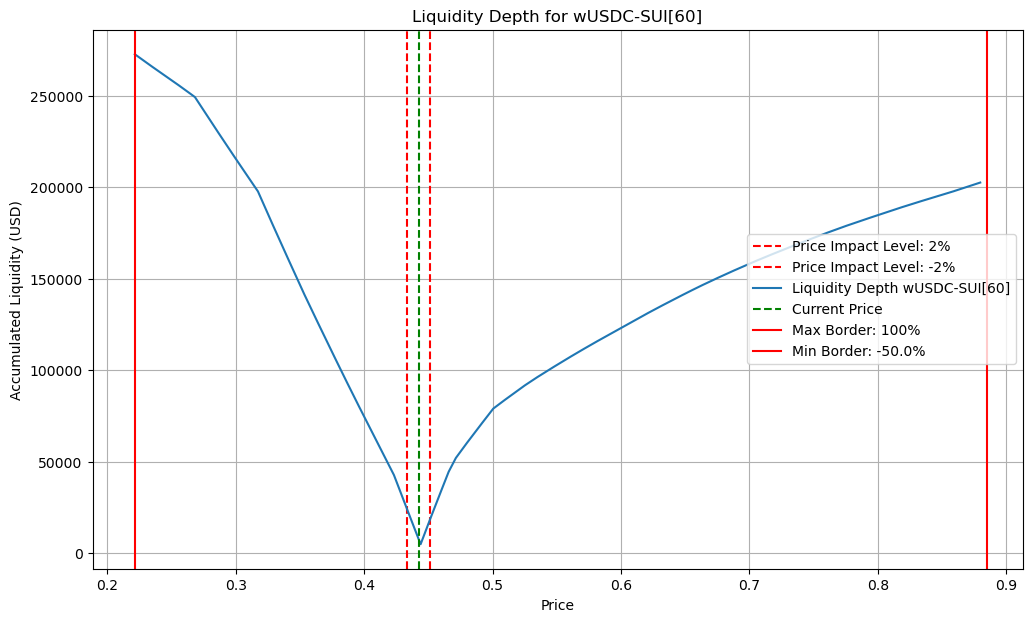

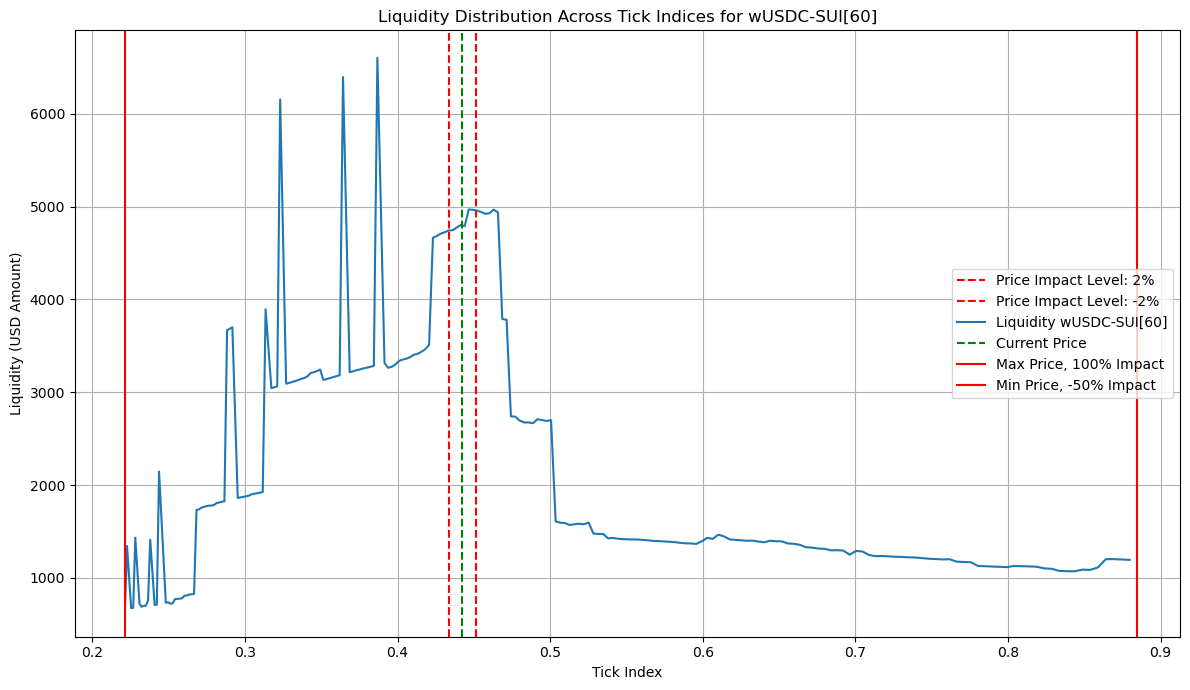


Main info

╒════════════════════╤═════════════════════╕
│ Date               │ 2025-03-18 20:21:15 │
├────────────────────┼─────────────────────┤
│ Current price      │ 0.03639830894930471 │
├────────────────────┼─────────────────────┤
│ Amount of DEEP     │ 35548332.7880       │
├────────────────────┼─────────────────────┤
│ Amount of SUI      │ 843606.9082         │
├────────────────────┼─────────────────────┤
│ TVL                │ $4743714.5905       │
├────────────────────┼─────────────────────┤
│ USD Amount of DEEP │ $2877479.9919       │
├────────────────────┼─────────────────────┤
│ USD Amount of SUI  │ $1866234.5986       │
╘════════════════════╧═════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤════════════╤══════════════╤═════════════╤════════════╕
│  Direction  │   Amount In │ Token In   │     USD In │ Amount Out   │ Token Out   │ USD Out    │
╞═════════════╪═════════════╪════════════╪════════════╪══════════════╪══════════

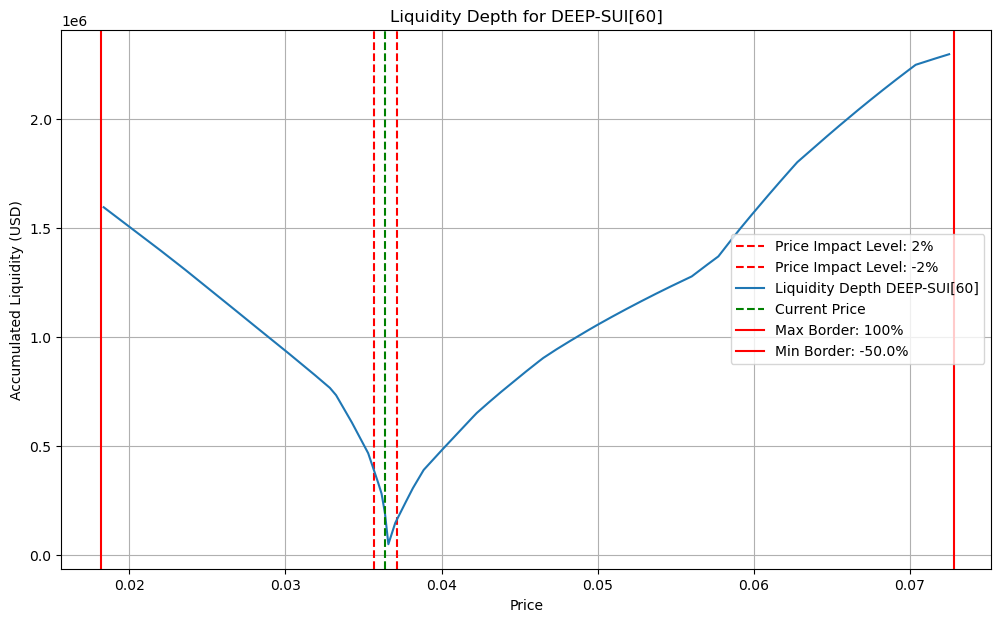

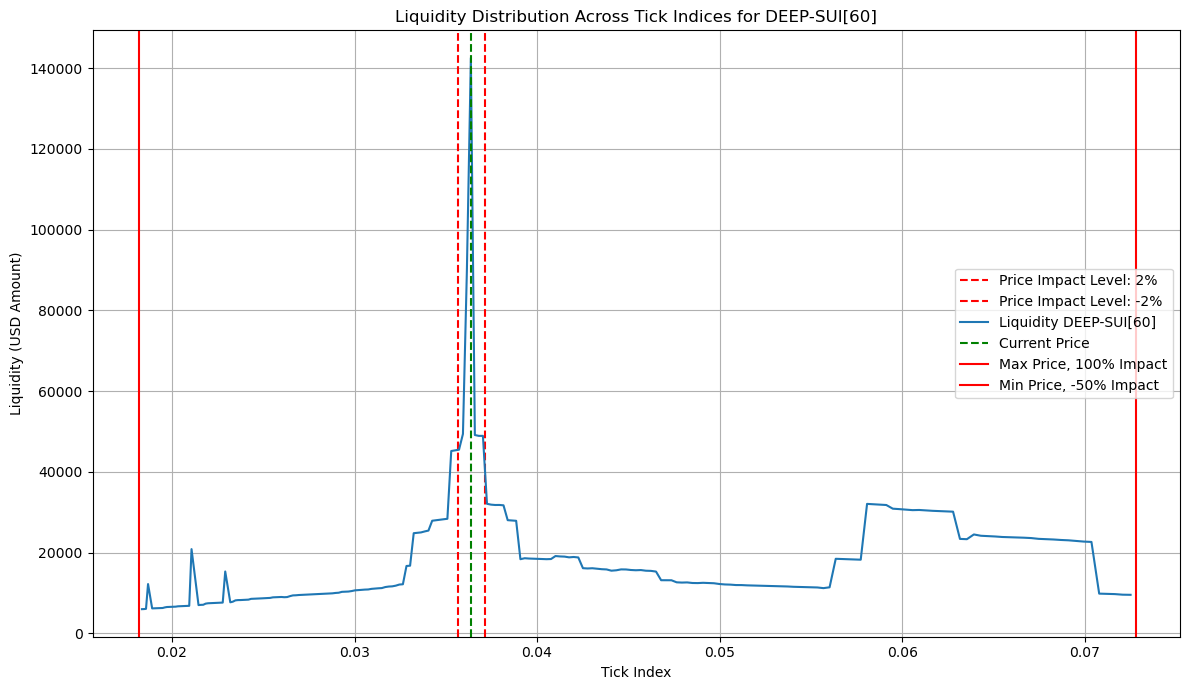


Main info

╒═════════════════════╤═════════════════════╕
│ Date                │ 2025-03-18 20:21:17 │
├─────────────────────┼─────────────────────┤
│ Current price       │ 0.00184411374739756 │
├─────────────────────┼─────────────────────┤
│ Amount of HIPPO     │ 158293851.5980      │
├─────────────────────┼─────────────────────┤
│ Amount of SUI       │ 336439.9080         │
├─────────────────────┼─────────────────────┤
│ TVL                 │ $1088892.1926       │
├─────────────────────┼─────────────────────┤
│ USD Amount of HIPPO │ $546683.5897        │
├─────────────────────┼─────────────────────┤
│ USD Amount of SUI   │ $542208.6029        │
╘═════════════════════╧═════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪══════════════╪═══

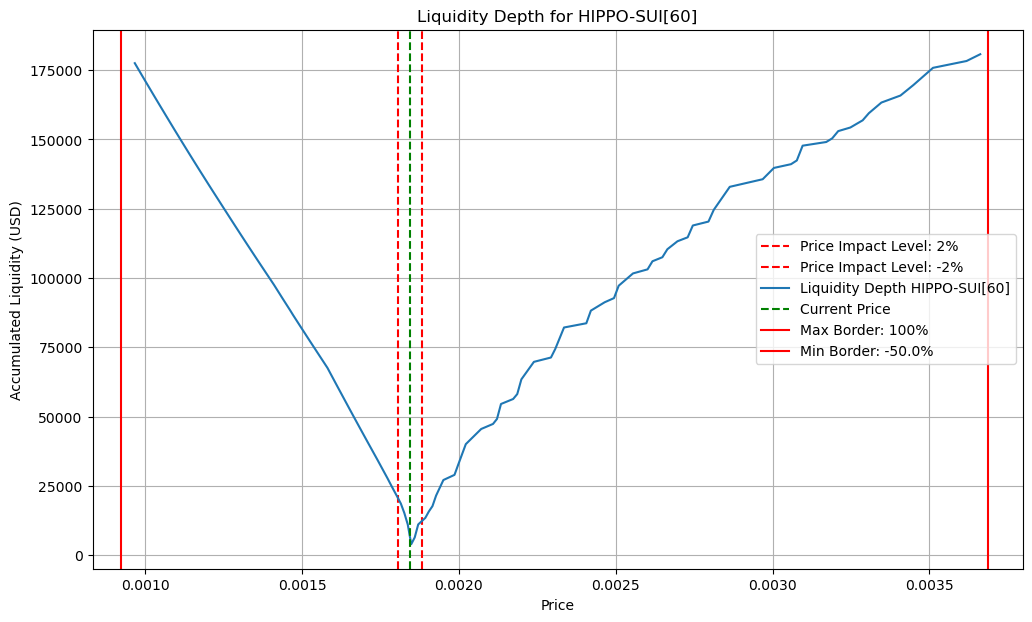

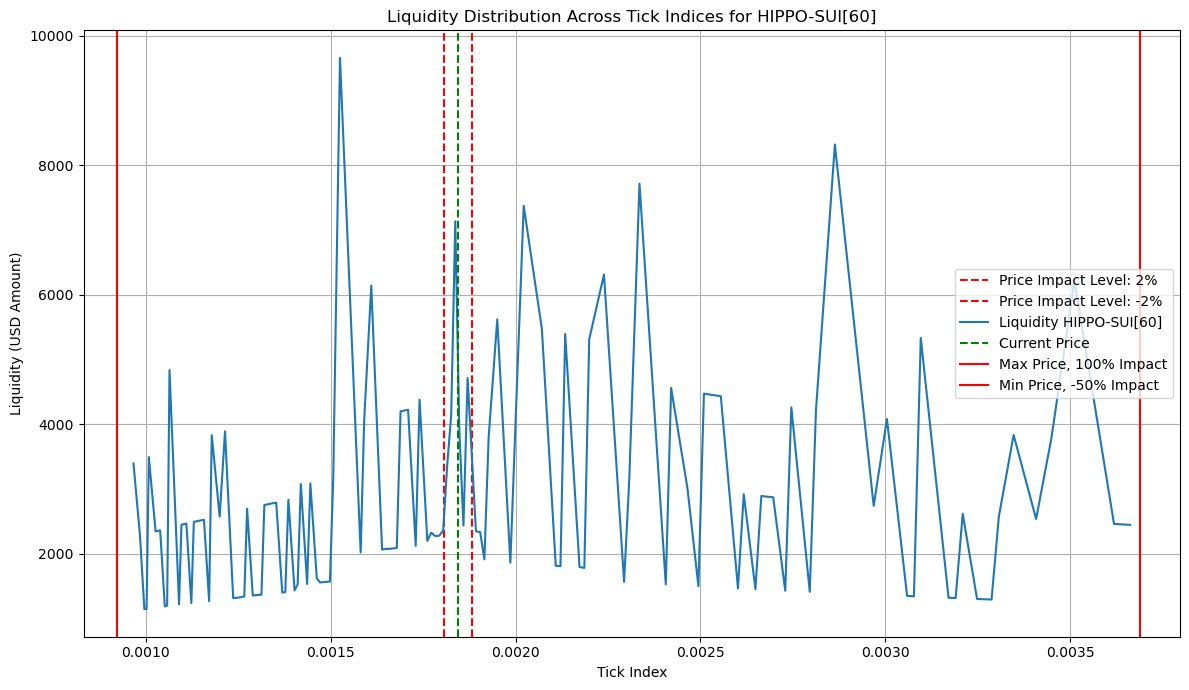


Main info

╒═════════════════════╤═════════════════════╕
│ Date                │ 2025-03-18 20:21:18 │
├─────────────────────┼─────────────────────┤
│ Current price       │ 0.6093590617137016  │
├─────────────────────┼─────────────────────┤
│ Amount of ALPHA     │ 60658.8276          │
├─────────────────────┼─────────────────────┤
│ Amount of SUI       │ 40.3895             │
├─────────────────────┼─────────────────────┤
│ TVL                 │ $82735.2962         │
├─────────────────────┼─────────────────────┤
│ USD Amount of ALPHA │ $82714.1281         │
├─────────────────────┼─────────────────────┤
│ USD Amount of SUI   │ $21.1681            │
╘═════════════════════╧═════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪══════════════╪═══

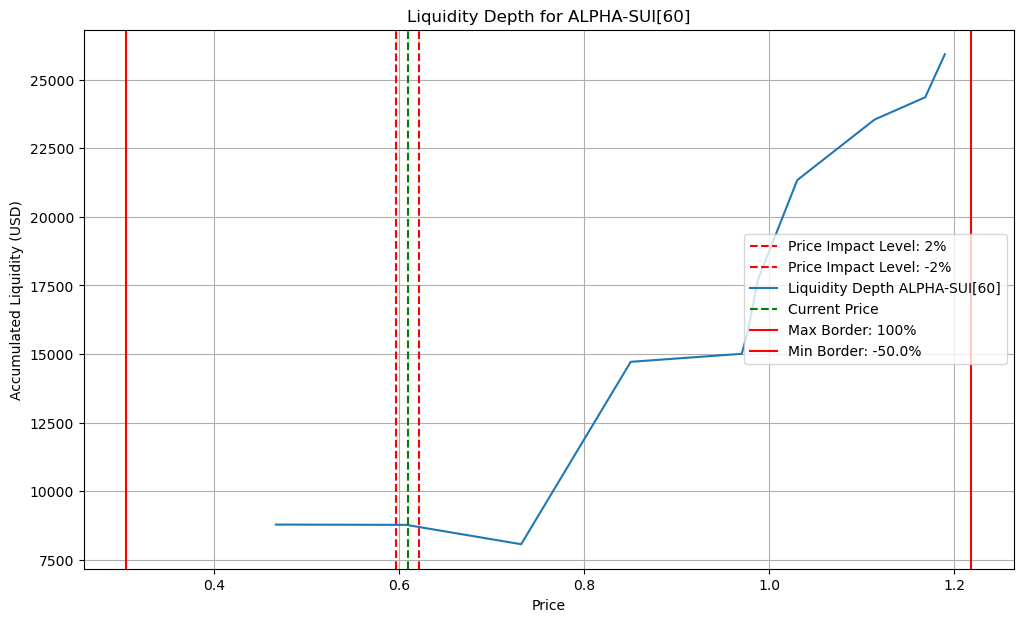

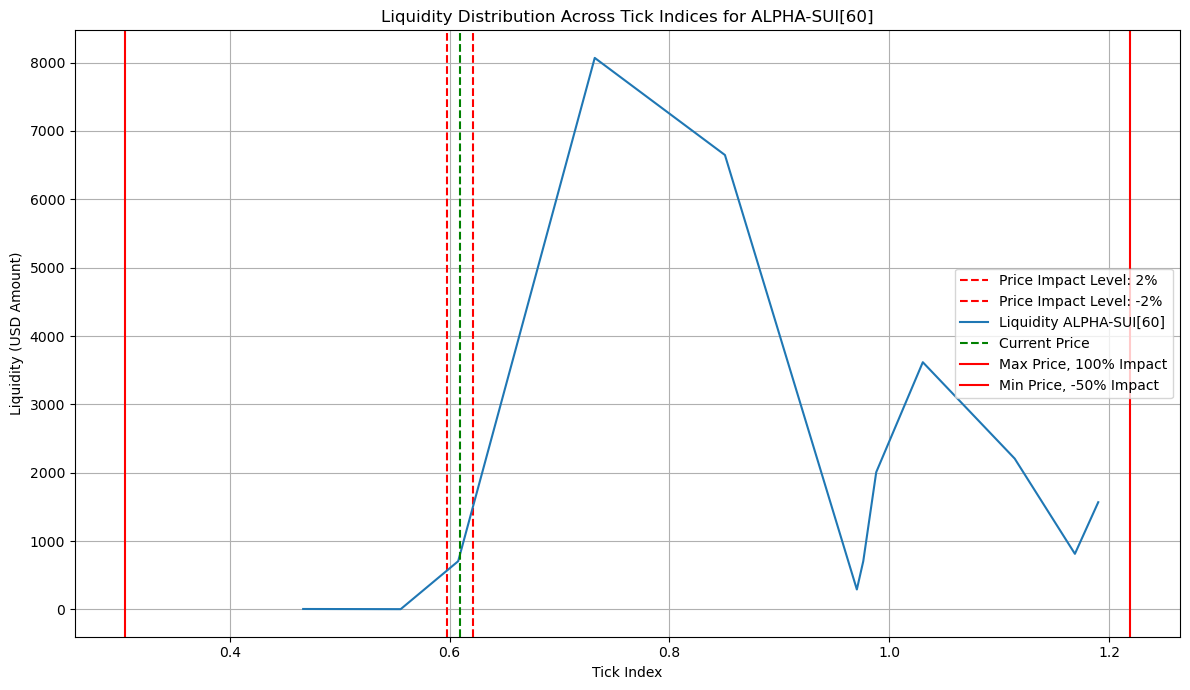


Main info

╒═════════════════════╤══════════════════════╕
│ Date                │ 2025-03-18 20:21:21  │
├─────────────────────┼──────────────────────┤
│ Current price       │ 0.043909967626848685 │
├─────────────────────┼──────────────────────┤
│ Amount of CETUS     │ 18333709.1736        │
├─────────────────────┼──────────────────────┤
│ Amount of SUI       │ 572647.6329          │
├─────────────────────┼──────────────────────┤
│ TVL                 │ $3024979.9917        │
├─────────────────────┼──────────────────────┤
│ USD Amount of CETUS │ $1778679.3649        │
├─────────────────────┼──────────────────────┤
│ USD Amount of SUI   │ $1246300.6269        │
╘═════════════════════╧══════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤════════════╤══════════════╤═════════════╤════════════╕
│  Direction  │   Amount In │ Token In   │     USD In │ Amount Out   │ Token Out   │ USD Out    │
╞═════════════╪═════════════╪════════════╪════════

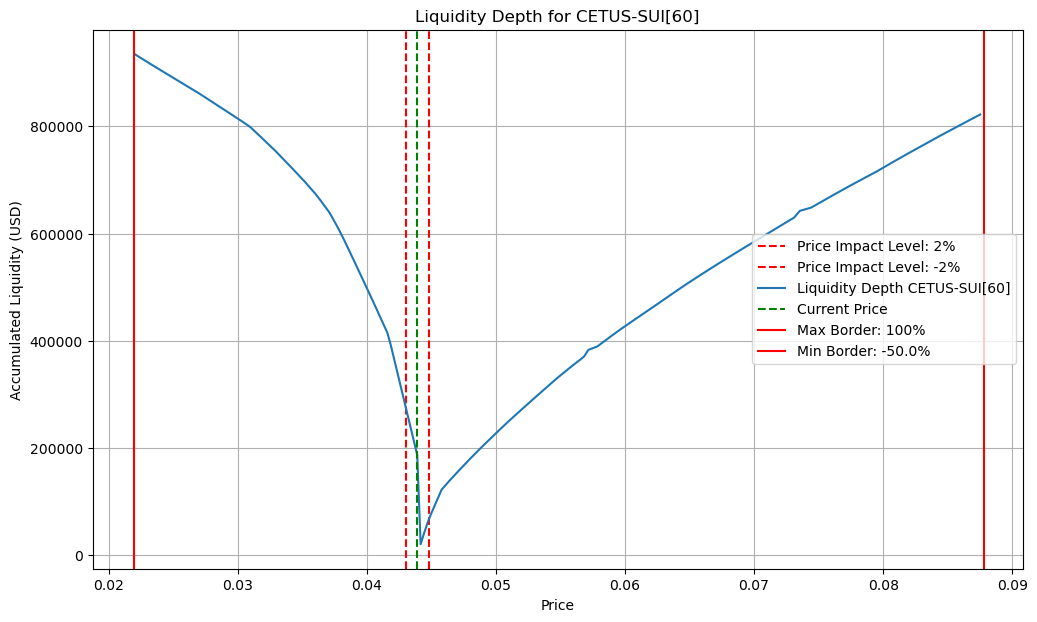

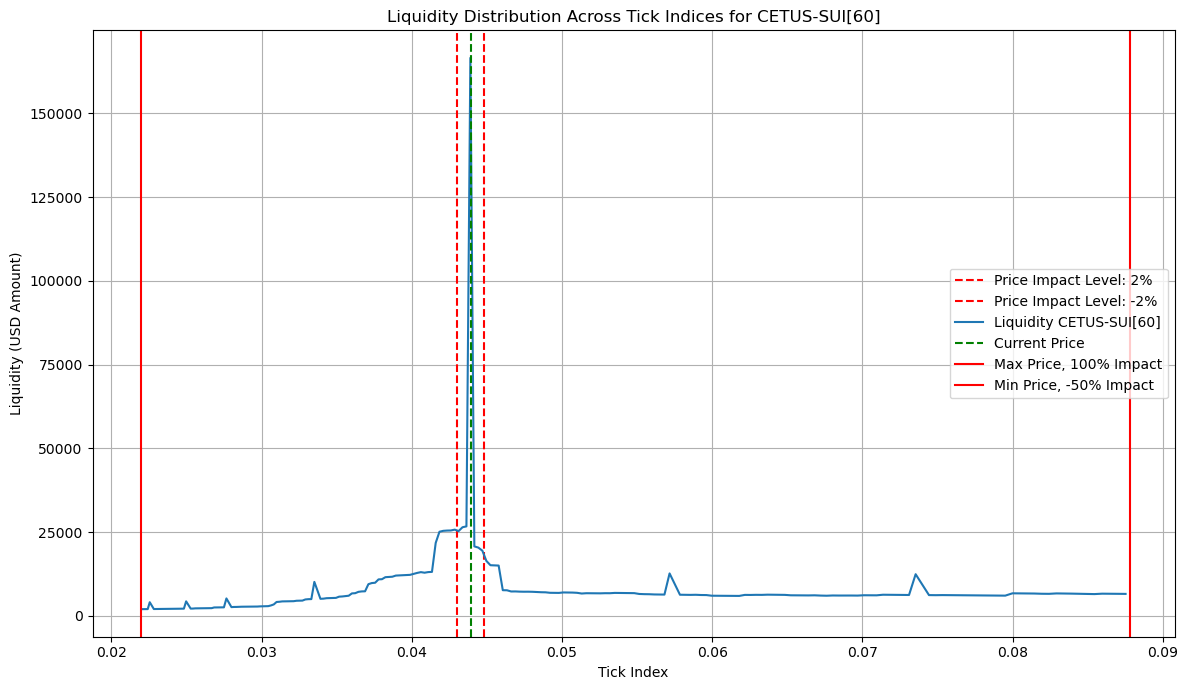


Main info

╒════════════════════╤═══════════════════════╕
│ Date               │ 2025-03-18 20:21:23   │
├────────────────────┼───────────────────────┤
│ Current price      │ 0.0007455426264901886 │
├────────────────────┼───────────────────────┤
│ Amount of AXOL     │ 36027943.6630         │
├────────────────────┼───────────────────────┤
│ Amount of SUI      │ 26770.6179            │
├────────────────────┼───────────────────────┤
│ TVL                │ $119803.0093          │
├────────────────────┼───────────────────────┤
│ USD Amount of AXOL │ $60023.9345           │
├────────────────────┼───────────────────────┤
│ USD Amount of SUI  │ $59779.0747           │
╘════════════════════╧═══════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪═══

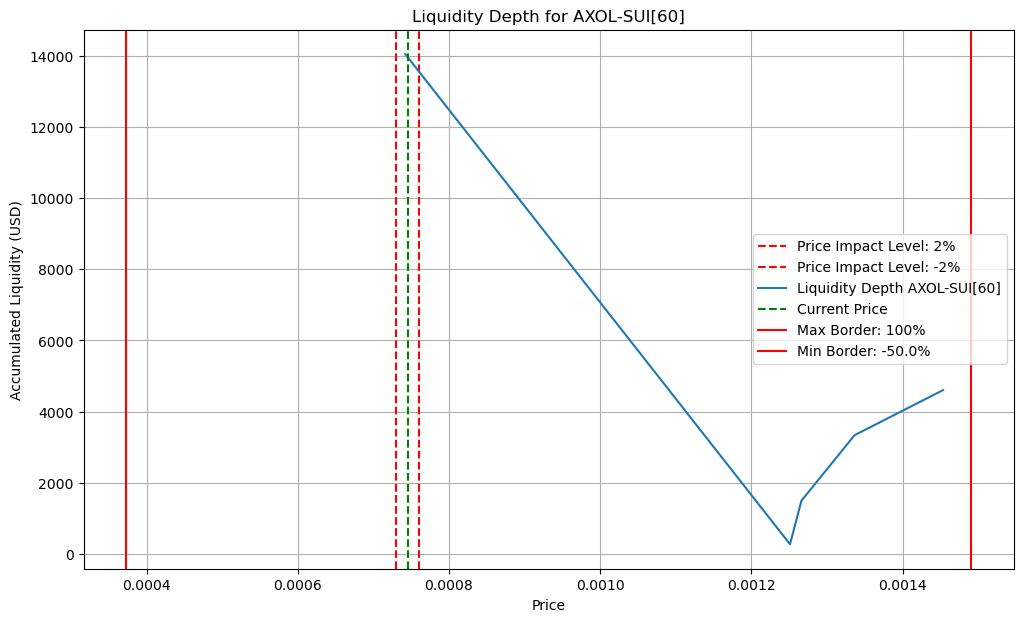

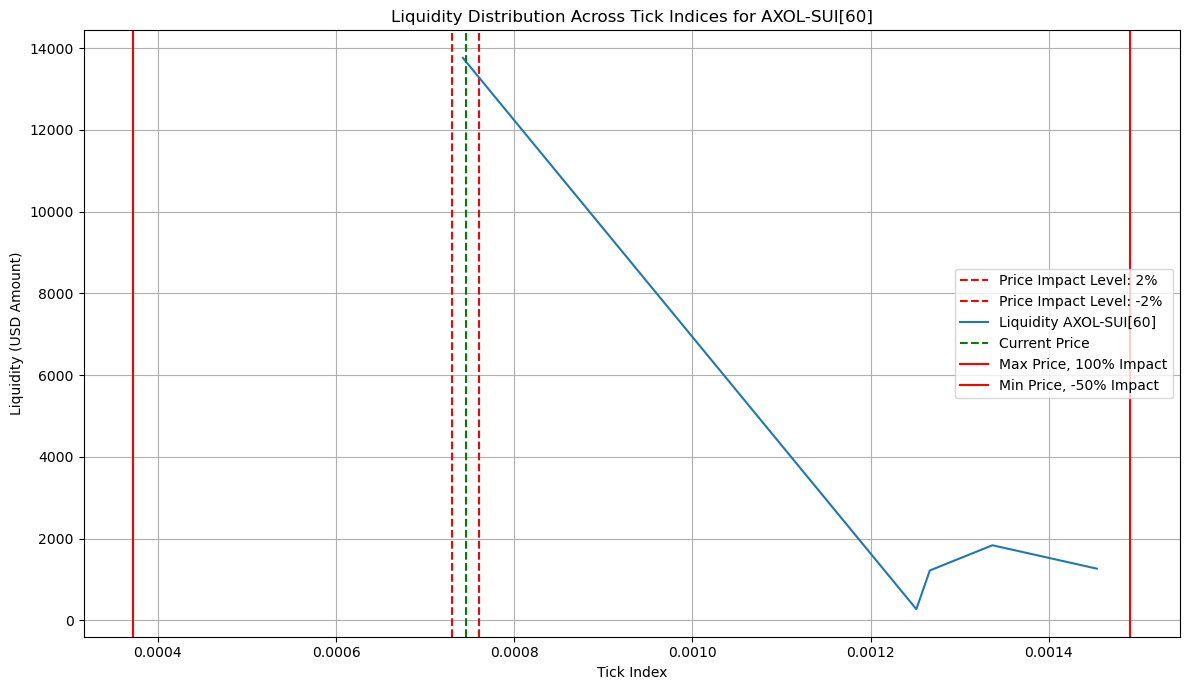


Main info

╒════════════════════╤══════════════════════╕
│ Date               │ 2025-03-18 20:21:24  │
├────────────────────┼──────────────────────┤
│ Current price      │ 0.033087425834500944 │
├────────────────────┼──────────────────────┤
│ Amount of NAVX     │ 6200050.9520         │
├────────────────────┼──────────────────────┤
│ Amount of SUI      │ 217637.4452          │
├────────────────────┼──────────────────────┤
│ TVL                │ $871921.9999         │
├────────────────────┼──────────────────────┤
│ USD Amount of NAVX │ $431507.2012         │
├────────────────────┼──────────────────────┤
│ USD Amount of SUI  │ $440414.7987         │
╘════════════════════╧══════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪══════════════╪═══

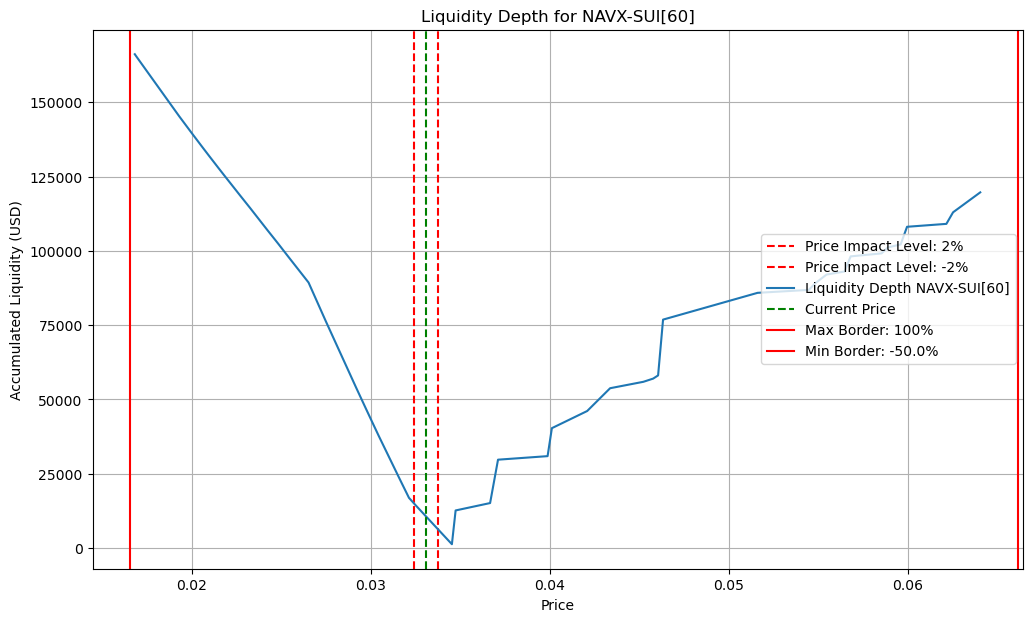

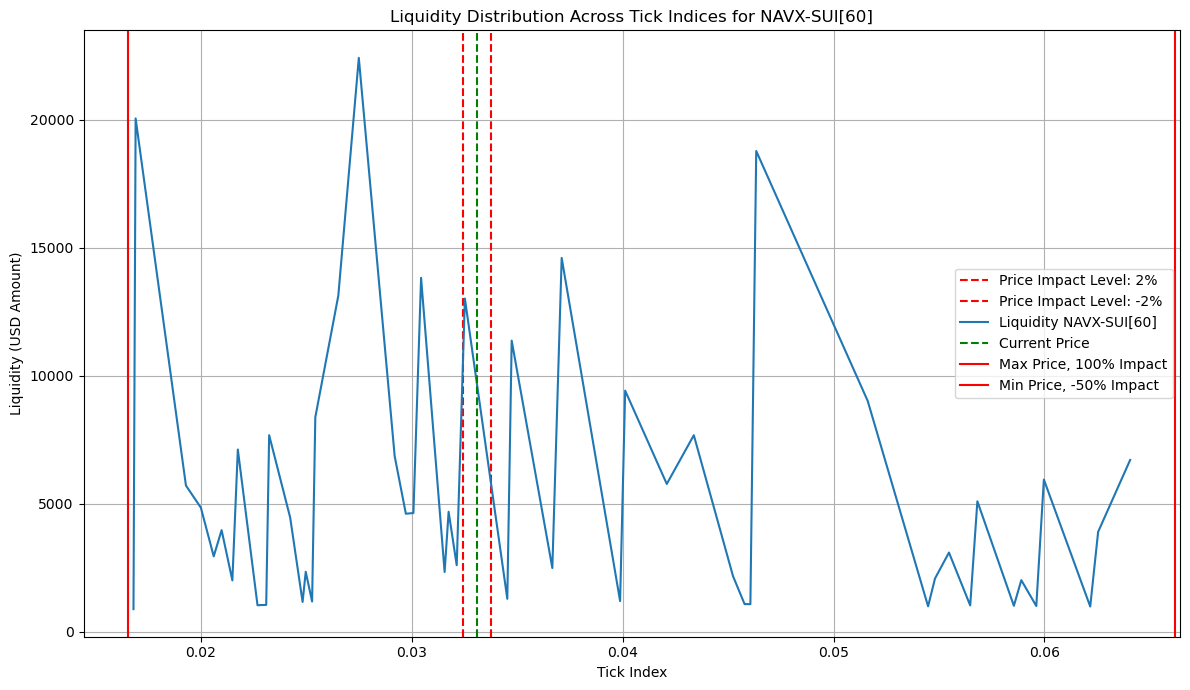


Main info

╒════════════════════╤═══════════════════════╕
│ Date               │ 2025-03-18 20:21:26   │
├────────────────────┼───────────────────────┤
│ Current price      │ 6.258150744944259e-09 │
├────────────────────┼───────────────────────┤
│ Amount of BLUB     │ 34811307974499.2188   │
├────────────────────┼───────────────────────┤
│ Amount of SUI      │ 212577.3154           │
├────────────────────┼───────────────────────┤
│ TVL                │ $962441.6478          │
├────────────────────┼───────────────────────┤
│ USD Amount of BLUB │ $487266.4158          │
├────────────────────┼───────────────────────┤
│ USD Amount of SUI  │ $475175.2320          │
╘════════════════════╧═══════════════════════╛


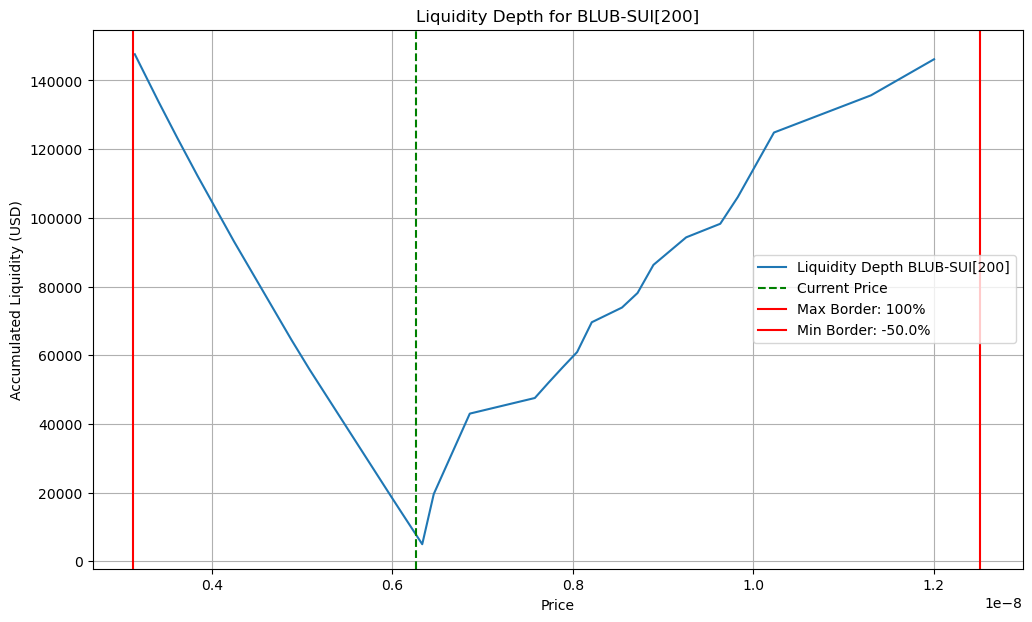

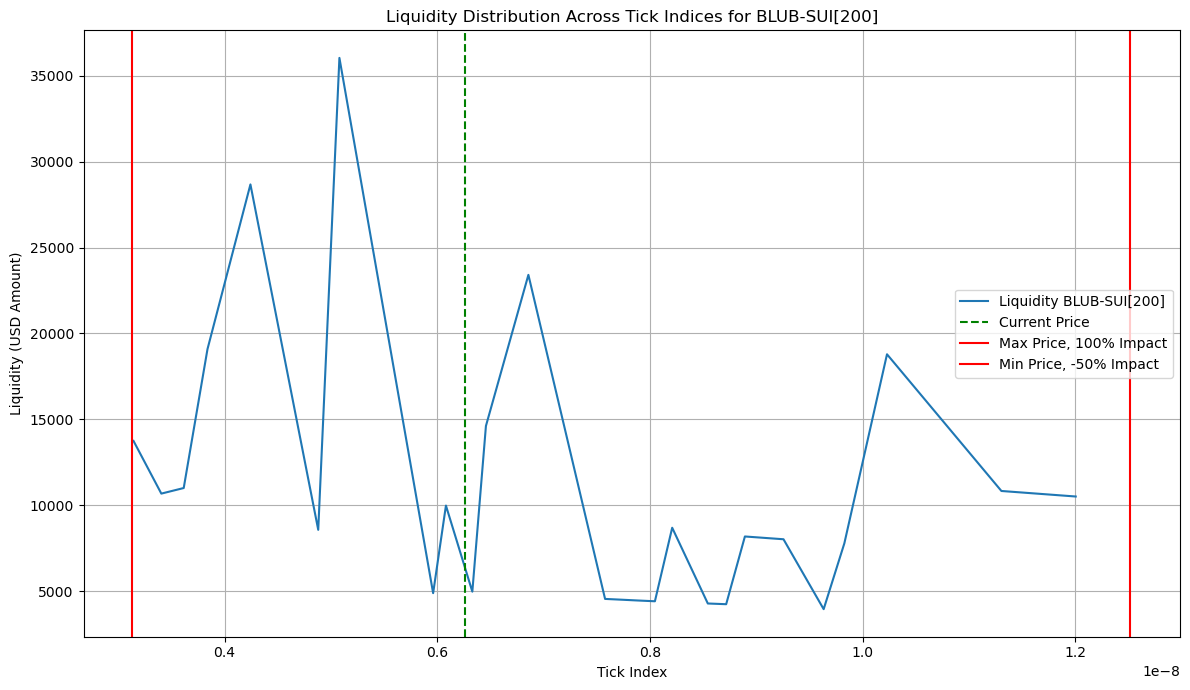


Main info

╒═══════════════════╤═════════════════════╕
│ Date              │ 2025-03-18 20:21:28 │
├───────────────────┼─────────────────────┤
│ Current price     │ 0.06079063324875299 │
├───────────────────┼─────────────────────┤
│ Amount of NS      │ 1657911.7854        │
├───────────────────┼─────────────────────┤
│ Amount of SUI     │ 114678.5172         │
├───────────────────┼─────────────────────┤
│ TVL               │ $474040.1905        │
├───────────────────┼─────────────────────┤
│ USD Amount of NS  │ $221911.9376        │
├───────────────────┼─────────────────────┤
│ USD Amount of SUI │ $252128.2528        │
╘═══════════════════╧═════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤═══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │    USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪═══════════╪══════════════╪═════════════╪═══════════╡
│ ↓

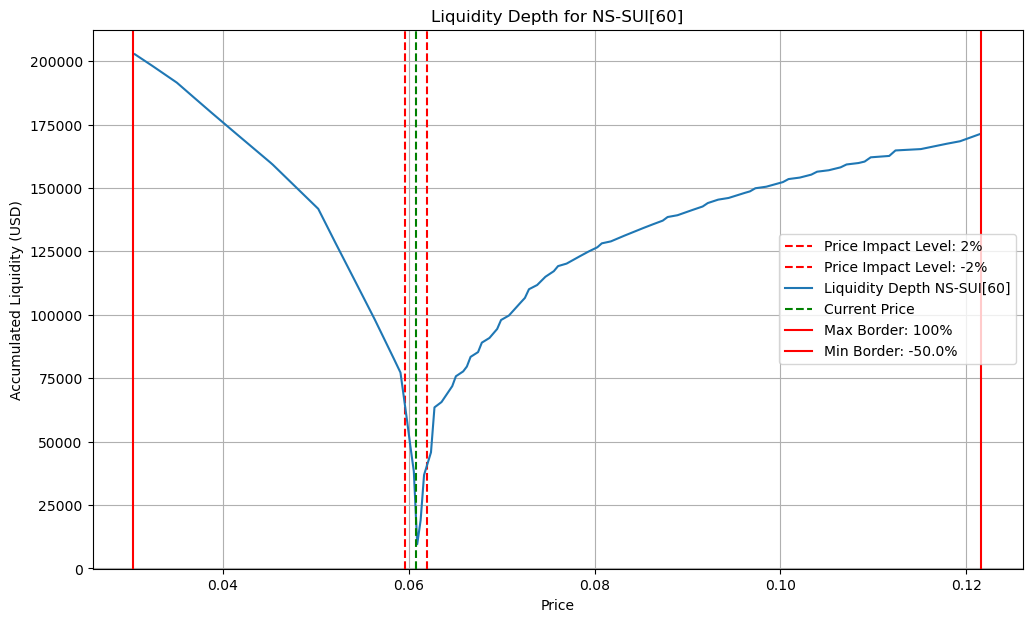

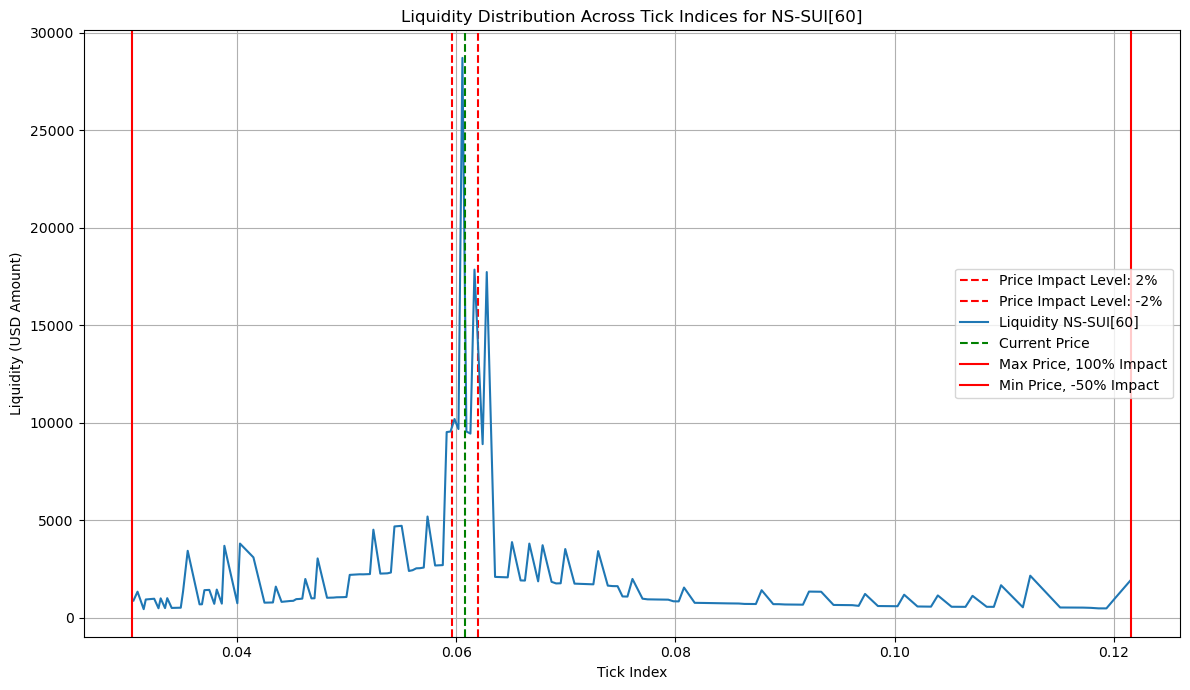


Main info

╒════════════════════╤═════════════════════╕
│ Date               │ 2025-03-18 20:21:29 │
├────────────────────┼─────────────────────┤
│ Current price      │ 0.44279337339480845 │
├────────────────────┼─────────────────────┤
│ Amount of AUSD     │ 1752.0736           │
├────────────────────┼─────────────────────┤
│ Amount of SUI      │ 29251.1213          │
├────────────────────┼─────────────────────┤
│ TVL                │ $66992.6770         │
├────────────────────┼─────────────────────┤
│ USD Amount of AUSD │ $1602.6855          │
├────────────────────┼─────────────────────┤
│ USD Amount of SUI  │ $65389.9916         │
╘════════════════════╧═════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪══════════════╪═════════════╪════

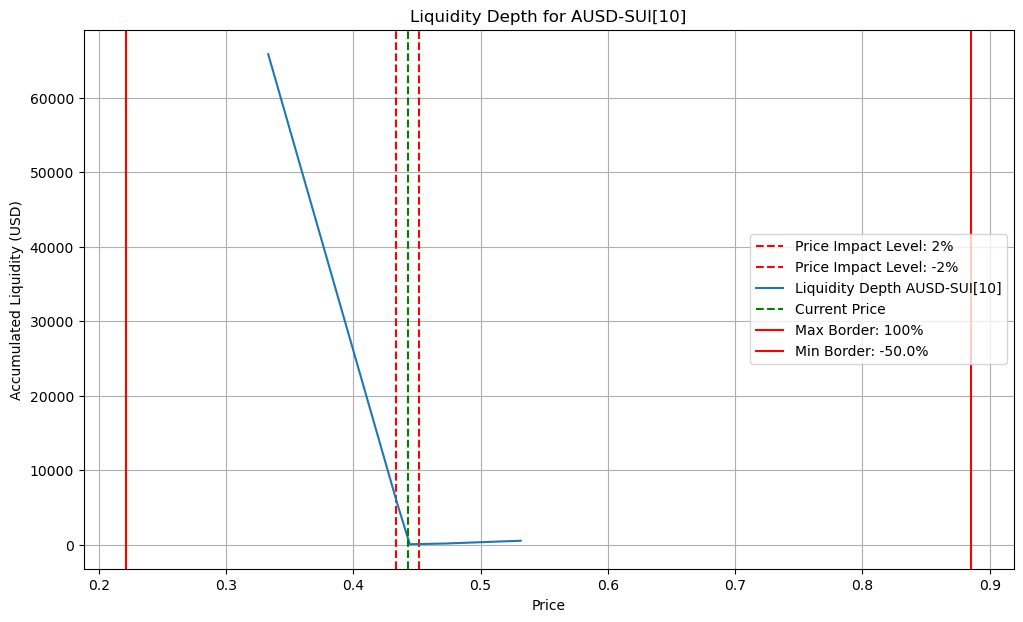

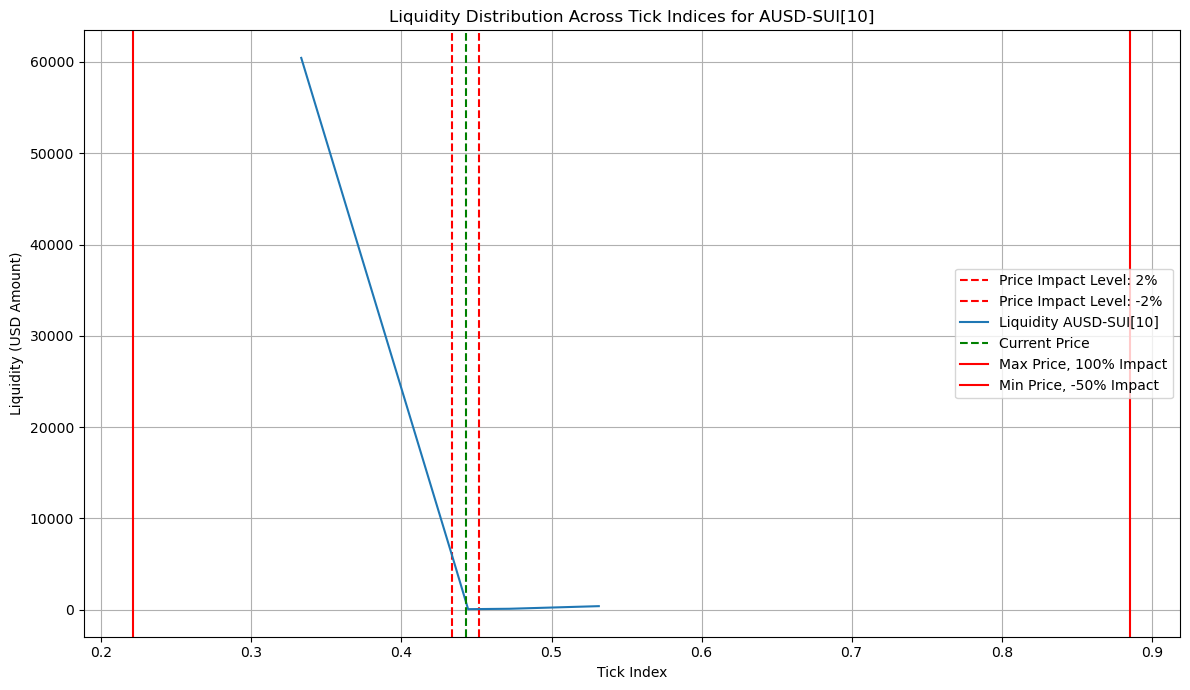


Main info

╒═══════════════════╤══════════════════════╕
│ Date              │ 2025-03-18 20:21:31  │
├───────────────────┼──────────────────────┤
│ Current price     │ 0.031206693746866288 │
├───────────────────┼──────────────────────┤
│ Amount of SCA     │ 2122023.1287         │
├───────────────────┼──────────────────────┤
│ Amount of SUI     │ 74190.2142           │
├───────────────────┼──────────────────────┤
│ TVL               │ $301330.8078         │
├───────────────────┼──────────────────────┤
│ USD Amount of SCA │ $142201.5584         │
├───────────────────┼──────────────────────┤
│ USD Amount of SUI │ $159129.2494         │
╘═══════════════════╧══════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪══════════════╪═════════════╪════

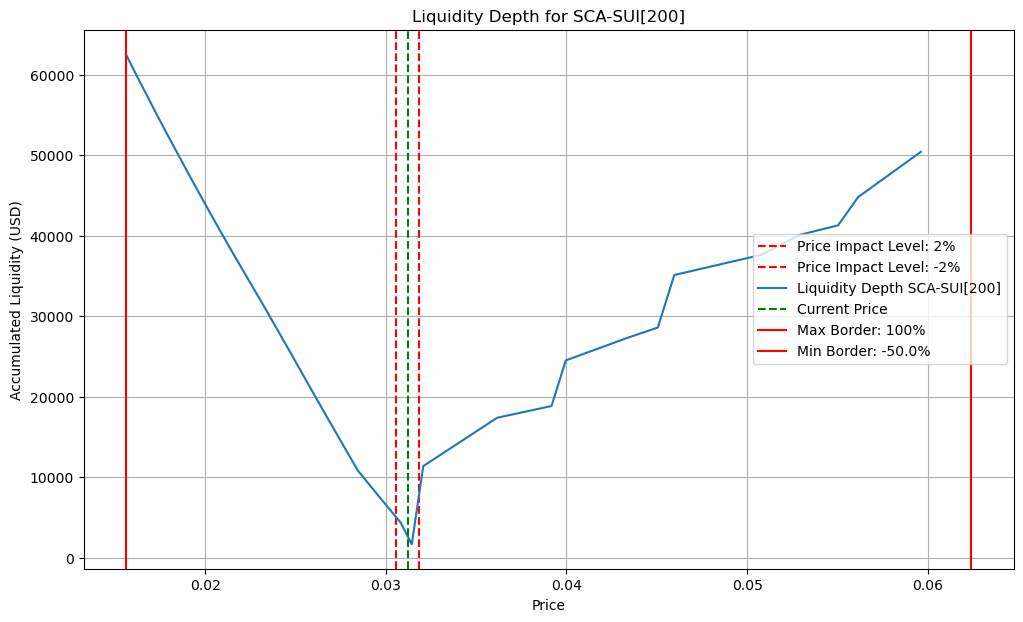

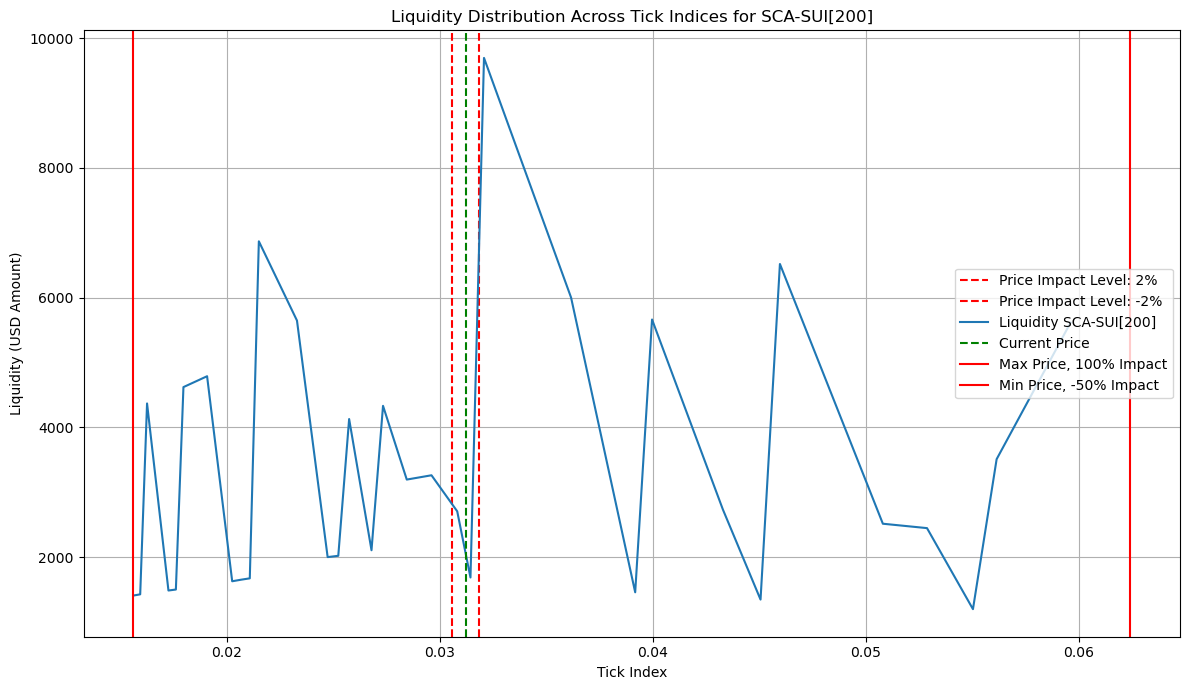


Main info

╒═══════════════════╤═════════════════════╕
│ Date              │ 2025-03-18 20:21:33 │
├───────────────────┼─────────────────────┤
│ Current price     │ 3.6937393418897e-05 │
├───────────────────┼─────────────────────┤
│ Amount of AAA     │ 150072863.8582      │
├───────────────────┼─────────────────────┤
│ Amount of SUI     │ 4925.9527           │
├───────────────────┼─────────────────────┤
│ TVL               │ $22598.4591         │
├───────────────────┼─────────────────────┤
│ USD Amount of AAA │ $12031.9932         │
├───────────────────┼─────────────────────┤
│ USD Amount of SUI │ $10566.4659         │
╘═══════════════════╧═════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪══════════════╪═════════════╪═══════════╡
│ ↓ A 

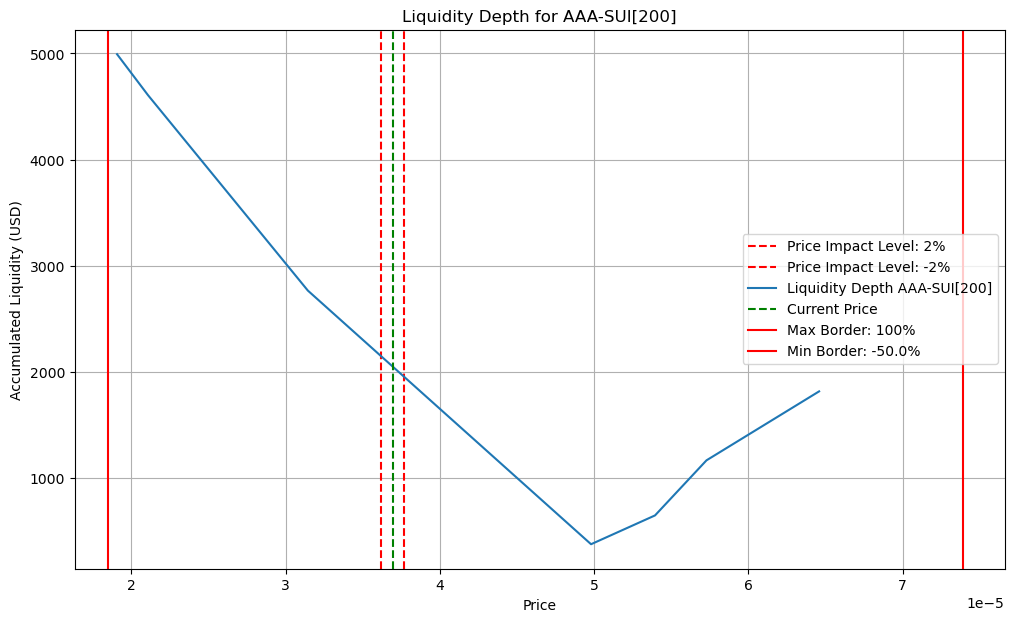

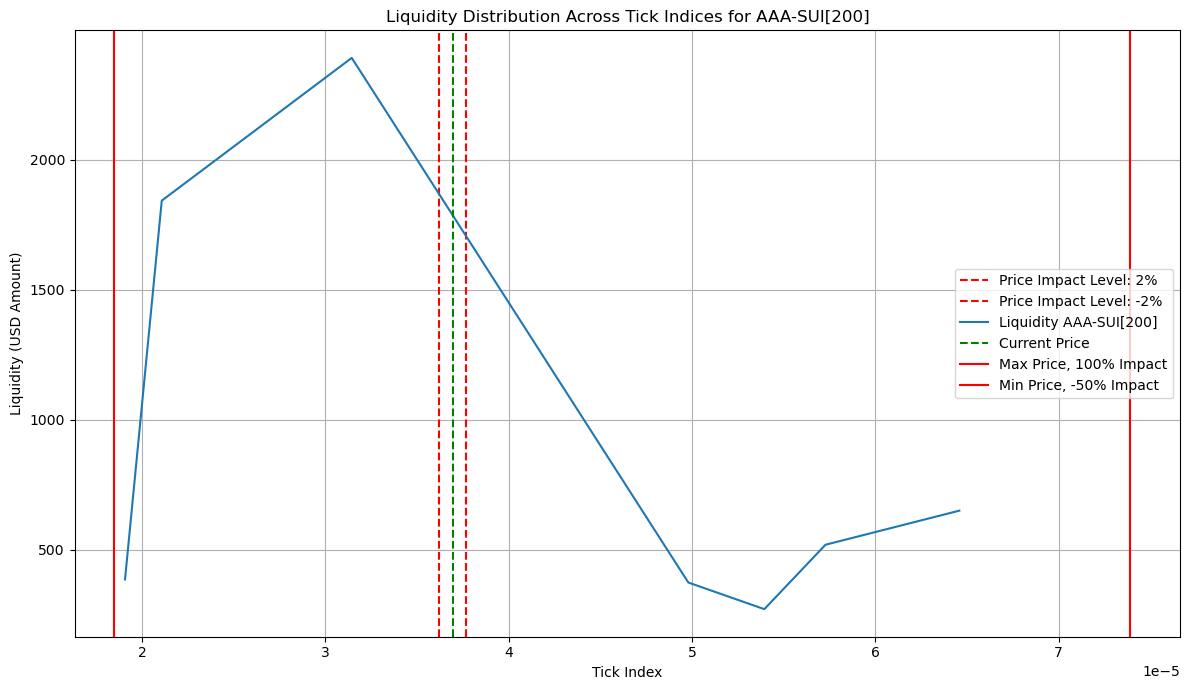


Main info

╒═══════════════════╤═══════════════════════╕
│ Date              │ 2025-03-18 20:21:35   │
├───────────────────┼───────────────────────┤
│ Current price     │ 2.437134285795397e-08 │
├───────────────────┼───────────────────────┤
│ Amount of FUD     │ 588211815110.4961     │
├───────────────────┼───────────────────────┤
│ Amount of SUI     │ 1957.0226             │
├───────────────────┼───────────────────────┤
│ TVL               │ $34732.8432           │
├───────────────────┼───────────────────────┤
│ USD Amount of FUD │ $31753.1972           │
├───────────────────┼───────────────────────┤
│ USD Amount of SUI │ $2979.6460            │
╘═══════════════════╧═══════════════════════╛


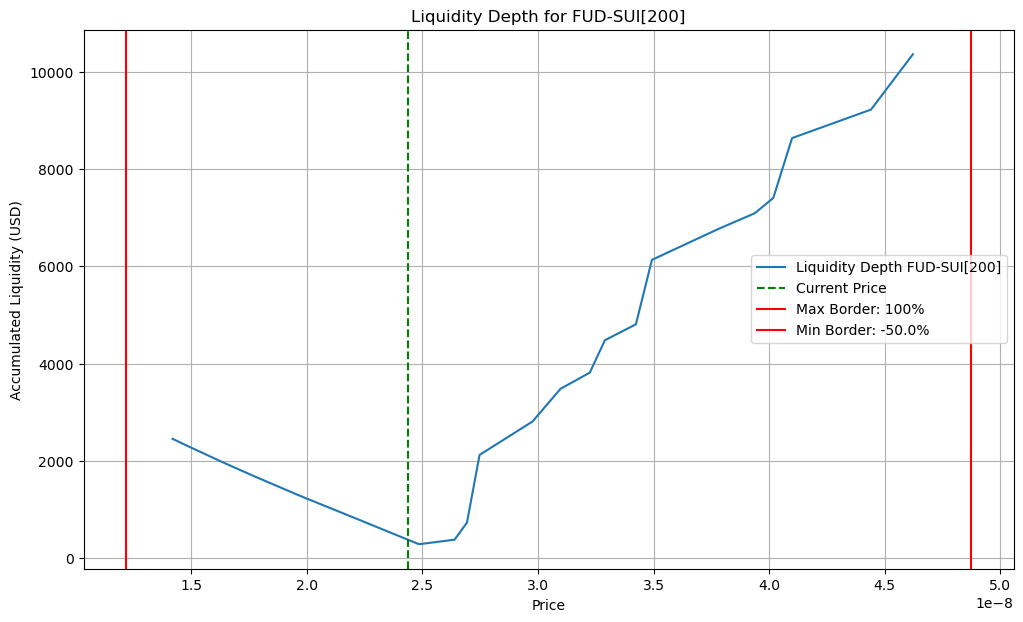

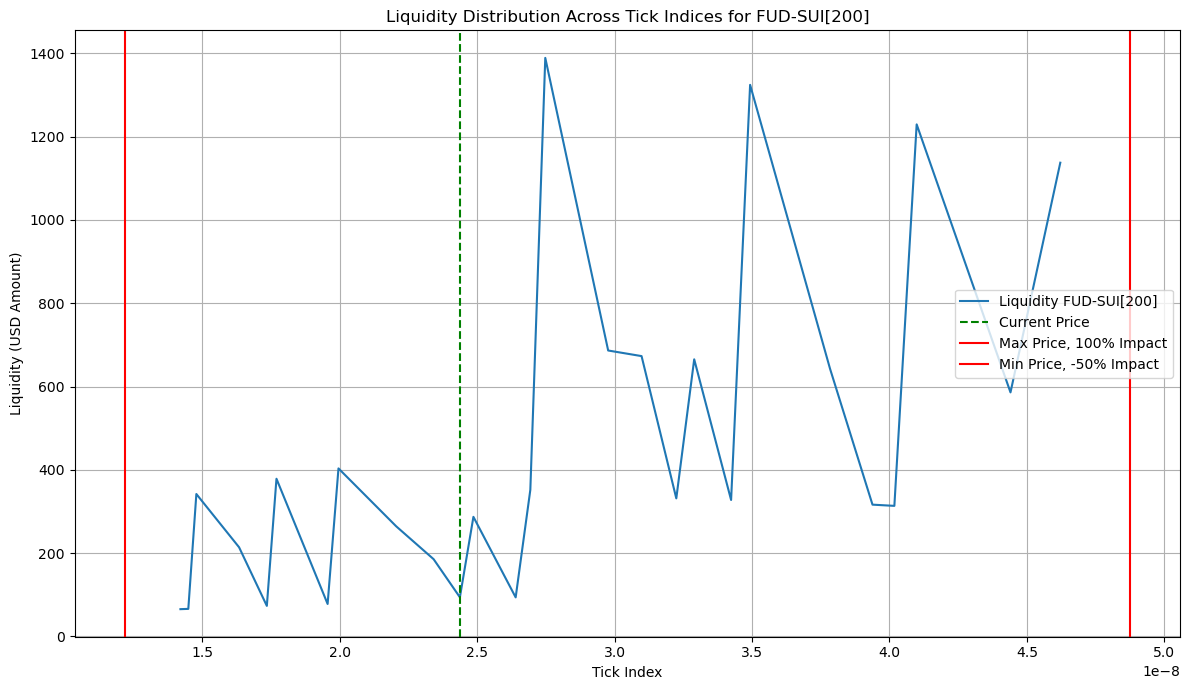


Main info

╒═════════════════════╤═════════════════════╕
│ Date                │ 2025-03-18 20:21:36 │
├─────────────────────┼─────────────────────┤
│ Current price       │ 0.15842756118972562 │
├─────────────────────┼─────────────────────┤
│ Amount of Sonic     │ 177444.8178         │
├─────────────────────┼─────────────────────┤
│ Amount of SUI       │ 27668.0999          │
├─────────────────────┼─────────────────────┤
│ TVL                 │ $124666.9634        │
├─────────────────────┼─────────────────────┤
│ USD Amount of Sonic │ $62821.3857         │
├─────────────────────┼─────────────────────┤
│ USD Amount of SUI   │ $61845.5777         │
╘═════════════════════╧═════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪══════════════╪═══

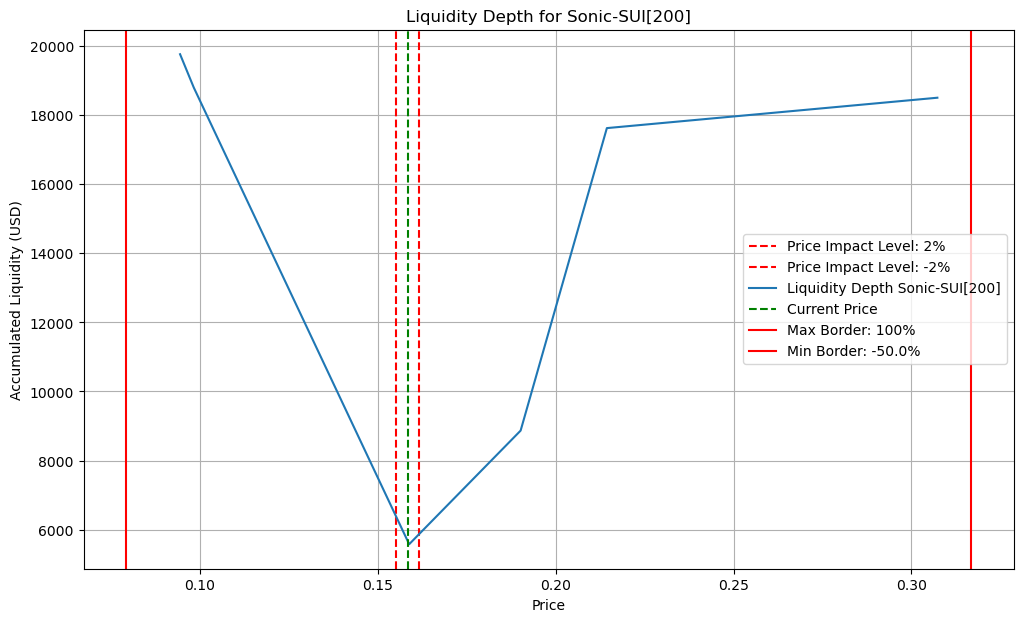

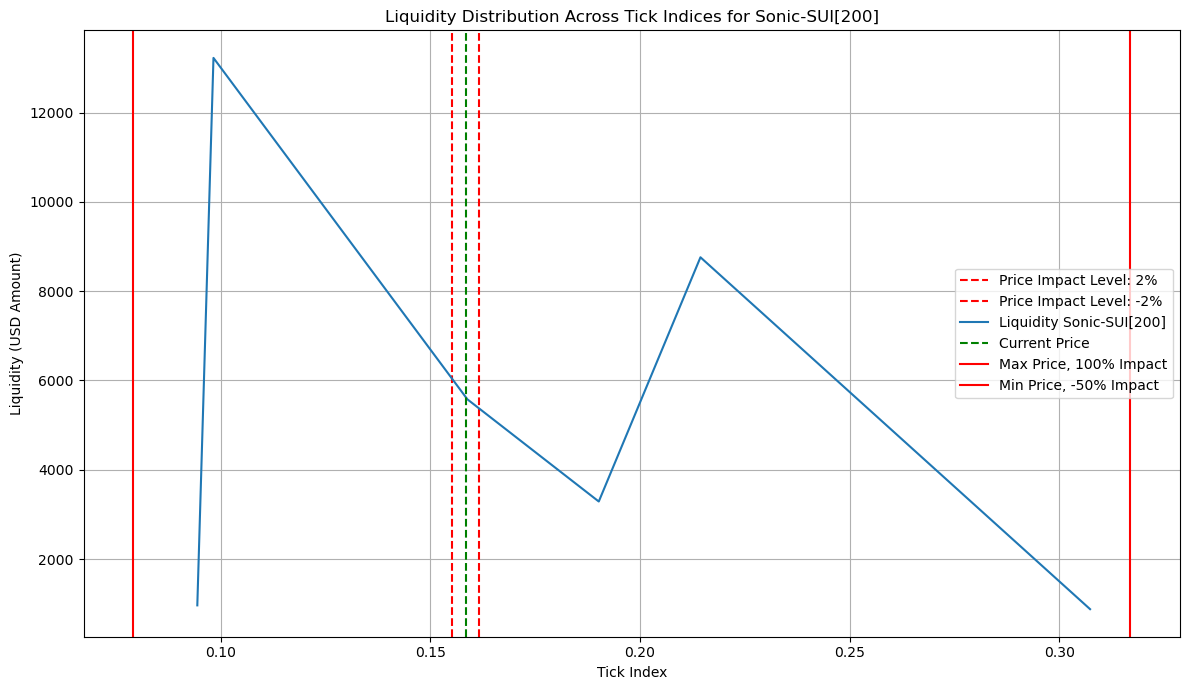


Main info

╒══════════════════════╤═══════════════════════╕
│ Date                 │ 2025-03-18 20:21:38   │
├──────────────────────┼───────────────────────┤
│ Current price        │ 5.639842352023732e-05 │
├──────────────────────┼───────────────────────┤
│ Amount of Suiman     │ 132692546.4375        │
├──────────────────────┼───────────────────────┤
│ Amount of SUI        │ 8527.3136             │
├──────────────────────┼───────────────────────┤
│ TVL                  │ $33184.1194           │
├──────────────────────┼───────────────────────┤
│ USD Amount of Suiman │ $16592.3164           │
├──────────────────────┼───────────────────────┤
│ USD Amount of SUI    │ $16591.8030           │
╘══════════════════════╧═══════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═══════════

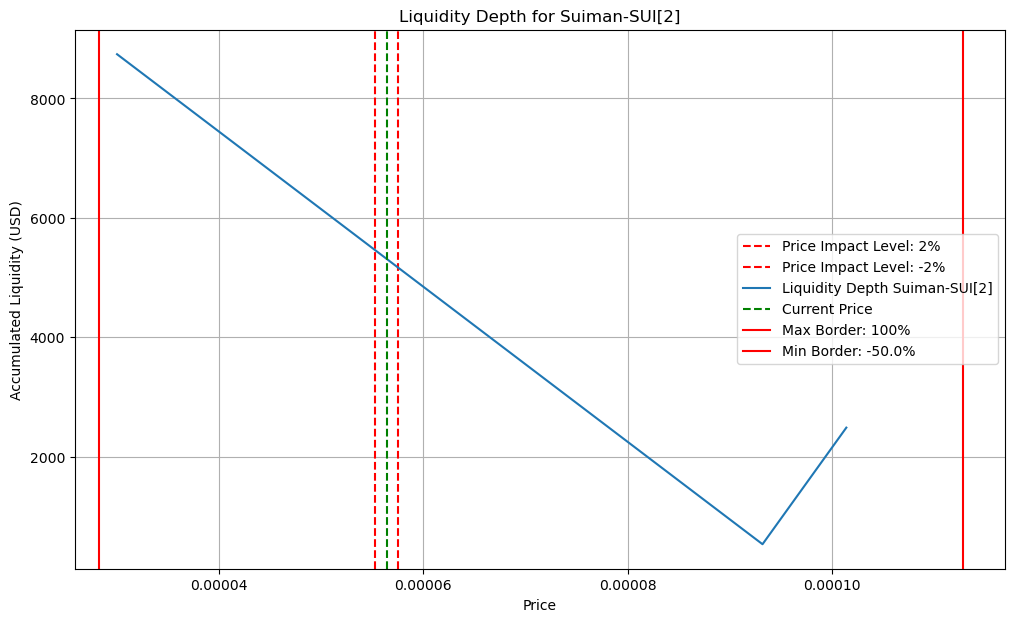

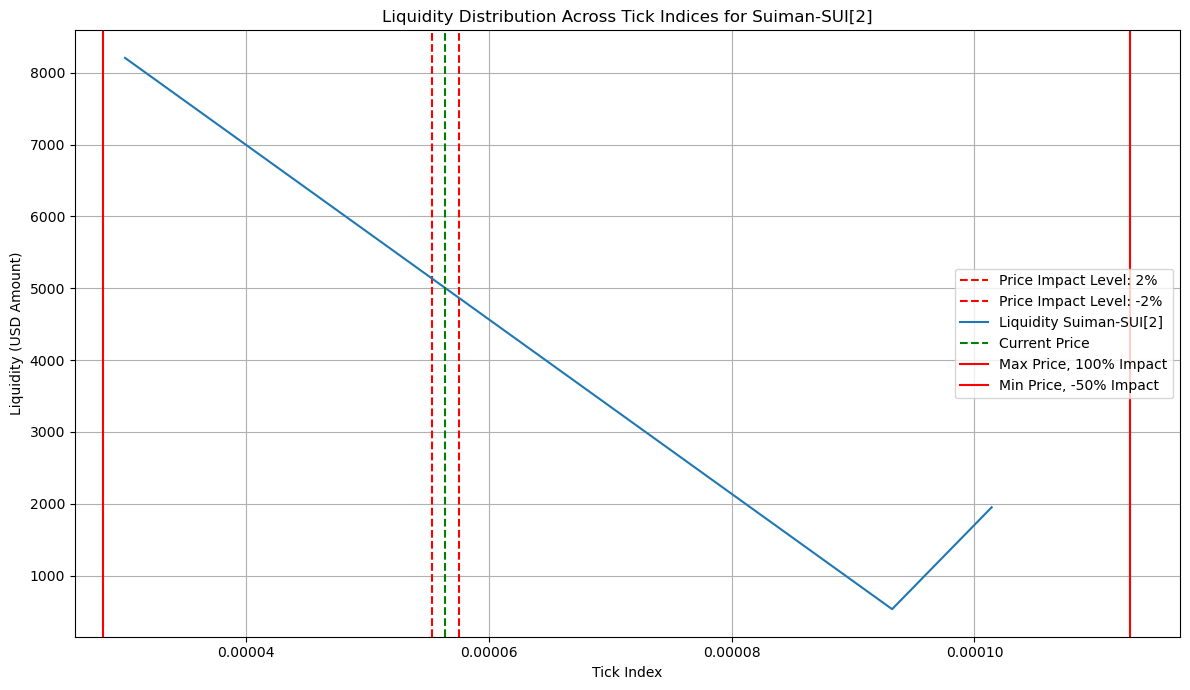


Main info

╒═══════════════════╤════════════════════════╕
│ Date              │ 2025-03-18 20:21:41    │
├───────────────────┼────────────────────────┤
│ Current price     │ 3.4905718685182735e-05 │
├───────────────────┼────────────────────────┤
│ Amount of KOI     │ 137826172.0203         │
├───────────────────┼────────────────────────┤
│ Amount of SUI     │ 4924.9938              │
├───────────────────┼────────────────────────┤
│ TVL               │ $21131.9543            │
├───────────────────┼────────────────────────┤
│ USD Amount of KOI │ $10568.8462            │
├───────────────────┼────────────────────────┤
│ USD Amount of SUI │ $10563.1081            │
╘═══════════════════╧════════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪═══

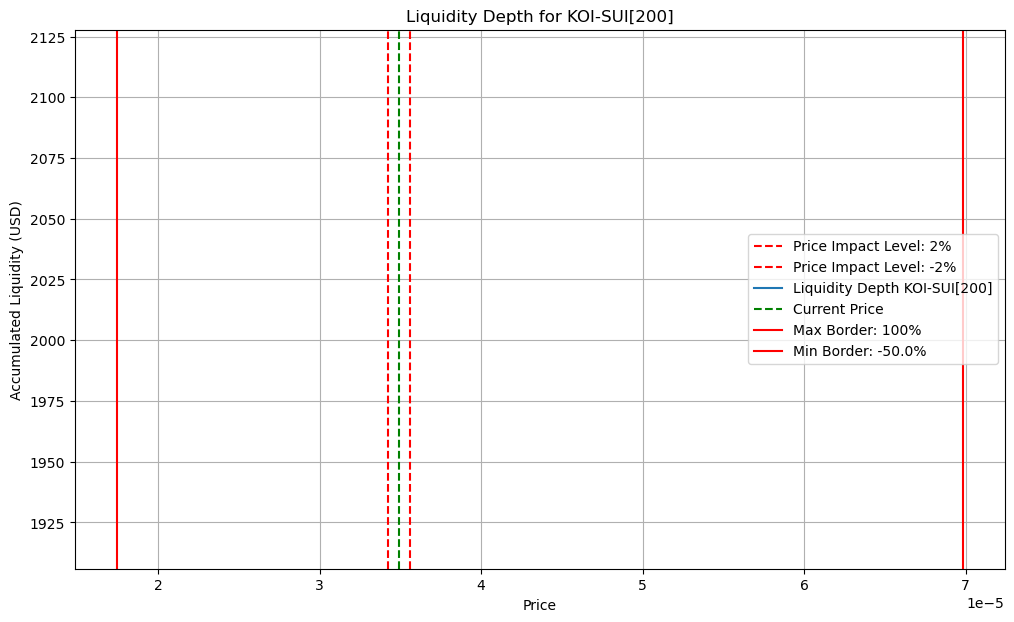

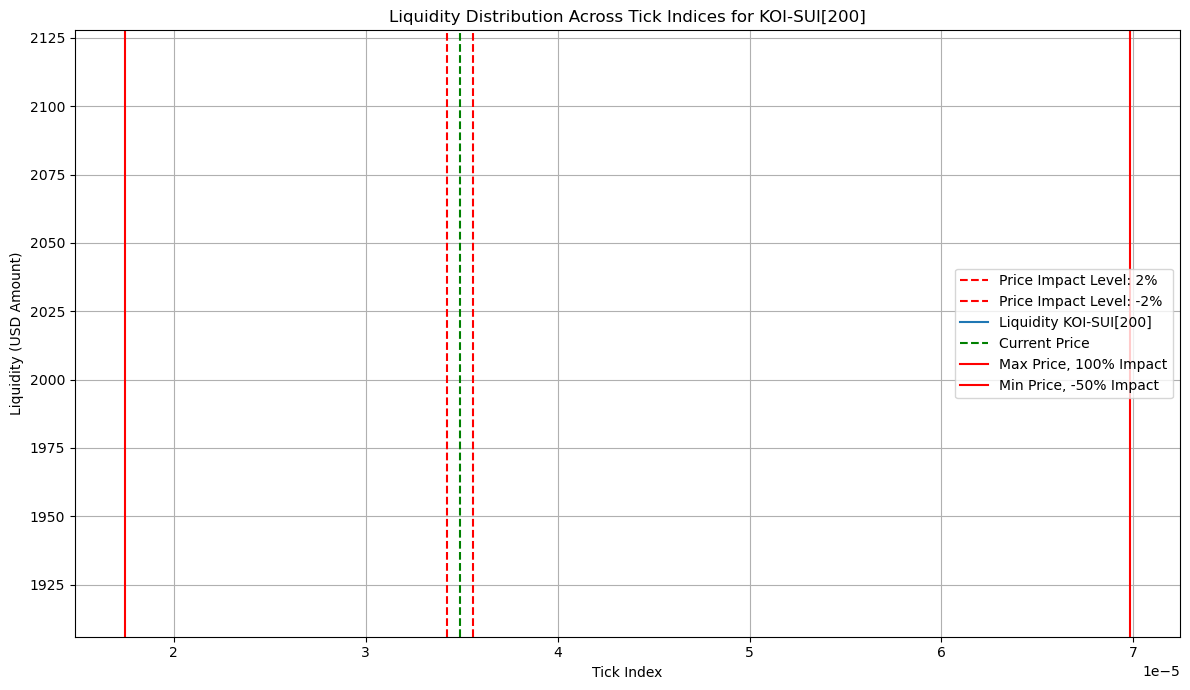


Main info

╒═══════════════════╤═══════════════════════╕
│ Date              │ 2025-03-18 20:21:44   │
├───────────────────┼───────────────────────┤
│ Current price     │ 0.0003026196580026615 │
├───────────────────┼───────────────────────┤
│ Amount of STD     │ 18562325.1984         │
├───────────────────┼───────────────────────┤
│ Amount of SUI     │ 12805.5152            │
├───────────────────┼───────────────────────┤
│ TVL               │ $21680.5611           │
├───────────────────┼───────────────────────┤
│ USD Amount of STD │ $11350.6387           │
├───────────────────┼───────────────────────┤
│ USD Amount of SUI │ $10329.9224           │
╘═══════════════════╧═══════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪══════════════╪═══

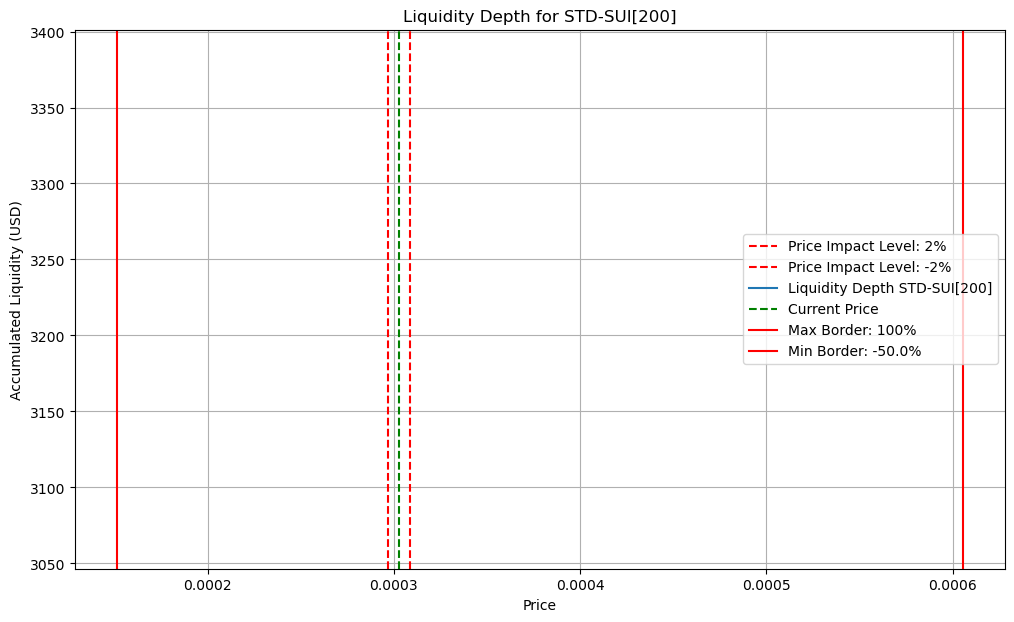

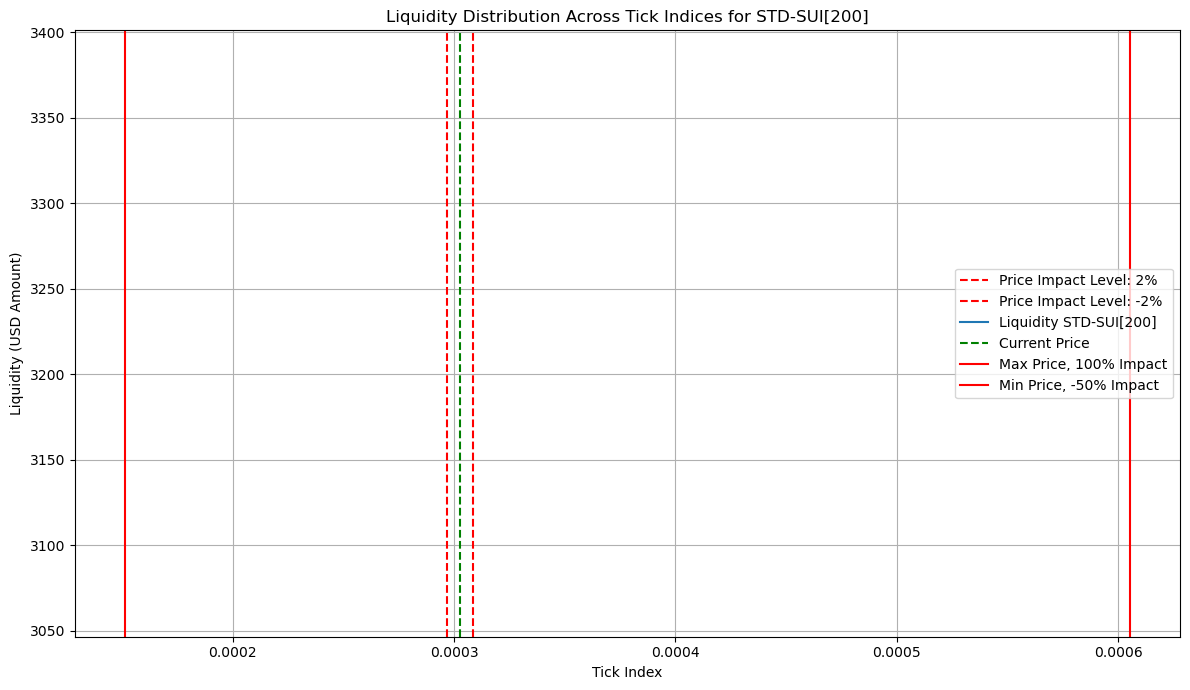


Main info

╒═════════════════════╤═══════════════════════╕
│ Date                │ 2025-03-18 20:21:45   │
├─────────────────────┼───────────────────────┤
│ Current price       │ 2.598720910322131e-05 │
├─────────────────────┼───────────────────────┤
│ Amount of SCUBA     │ 247336682.0533        │
├─────────────────────┼───────────────────────┤
│ Amount of SUI       │ 6544.4544             │
├─────────────────────┼───────────────────────┤
│ TVL                 │ $28767.8926           │
├─────────────────────┼───────────────────────┤
│ USD Amount of SCUBA │ $14384.8164           │
├─────────────────────┼───────────────────────┤
│ USD Amount of SUI   │ $14383.0762           │
╘═════════════════════╧═══════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════

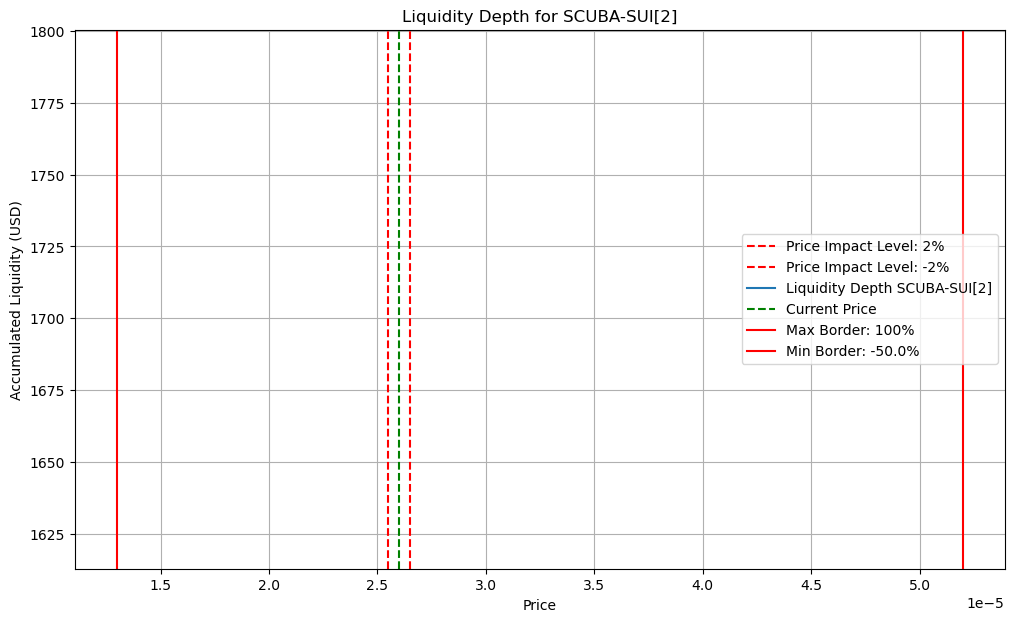

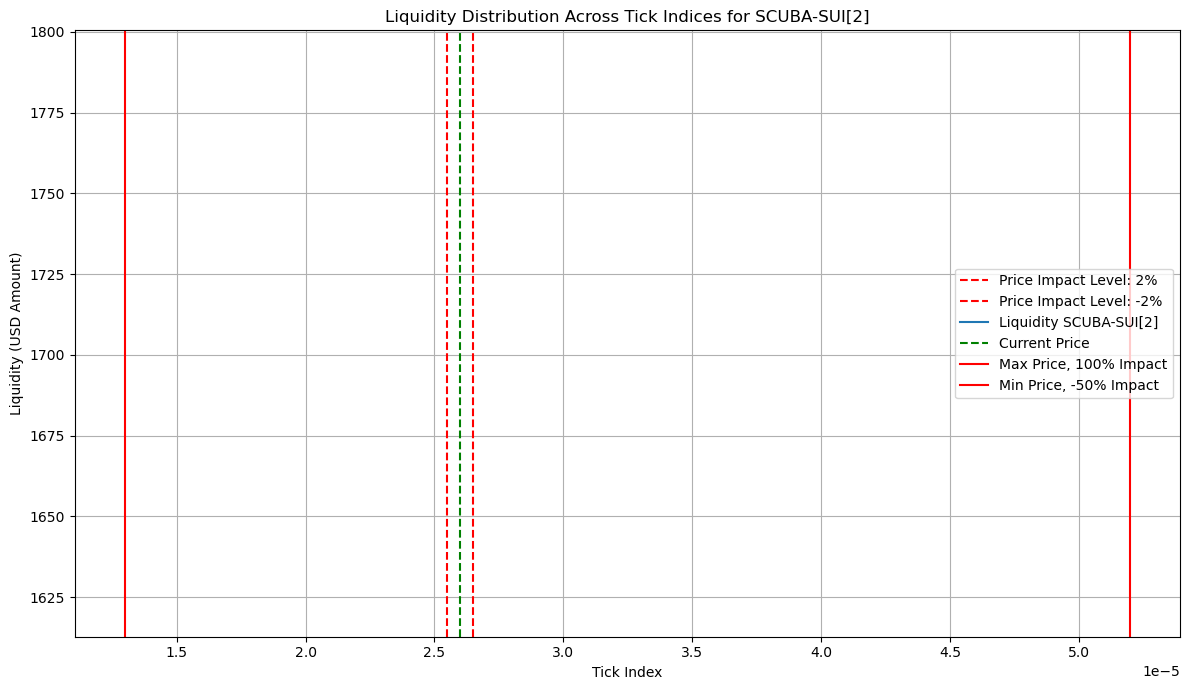


Main info

╒═════════════════════╤═════════════════════╕
│ Date                │ 2025-03-18 20:21:47 │
├─────────────────────┼─────────────────────┤
│ Current price       │ 1.043126661472664   │
├─────────────────────┼─────────────────────┤
│ Amount of afSUI     │ 648039.5215         │
├─────────────────────┼─────────────────────┤
│ Amount of SUI       │ 738175.6299         │
├─────────────────────┼─────────────────────┤
│ TVL                 │ $3167254.4805       │
├─────────────────────┼─────────────────────┤
│ USD Amount of afSUI │ $1513979.5822       │
├─────────────────────┼─────────────────────┤
│ USD Amount of SUI   │ $1653274.8983       │
╘═════════════════════╧═════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤════════════╤══════════════╤═════════════╤════════════╕
│  Direction  │   Amount In │ Token In   │     USD In │ Amount Out   │ Token Out   │ USD Out    │
╞═════════════╪═════════════╪════════════╪════════════╪══════════

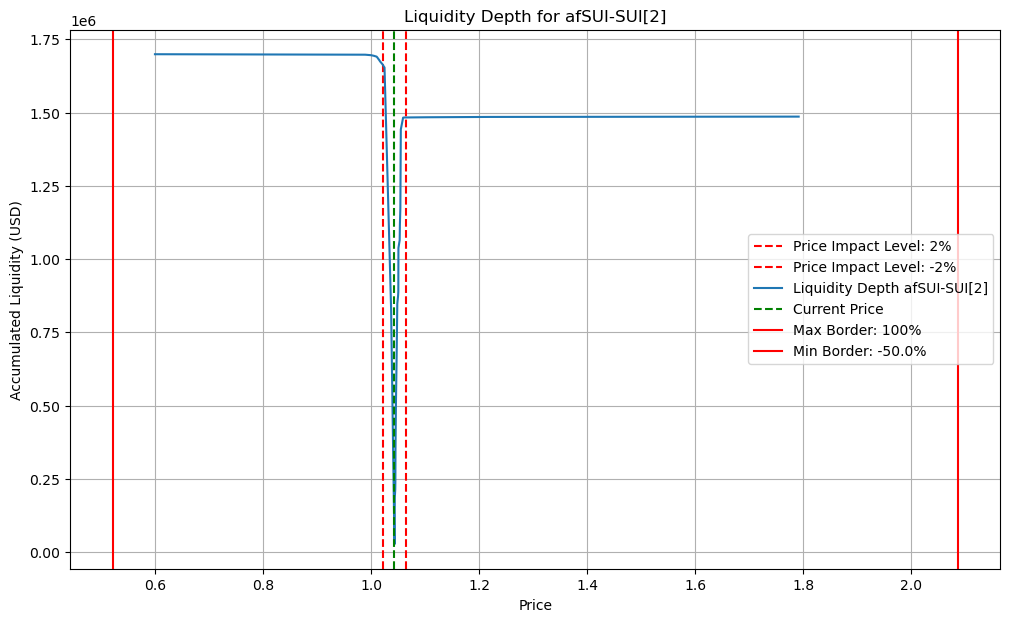

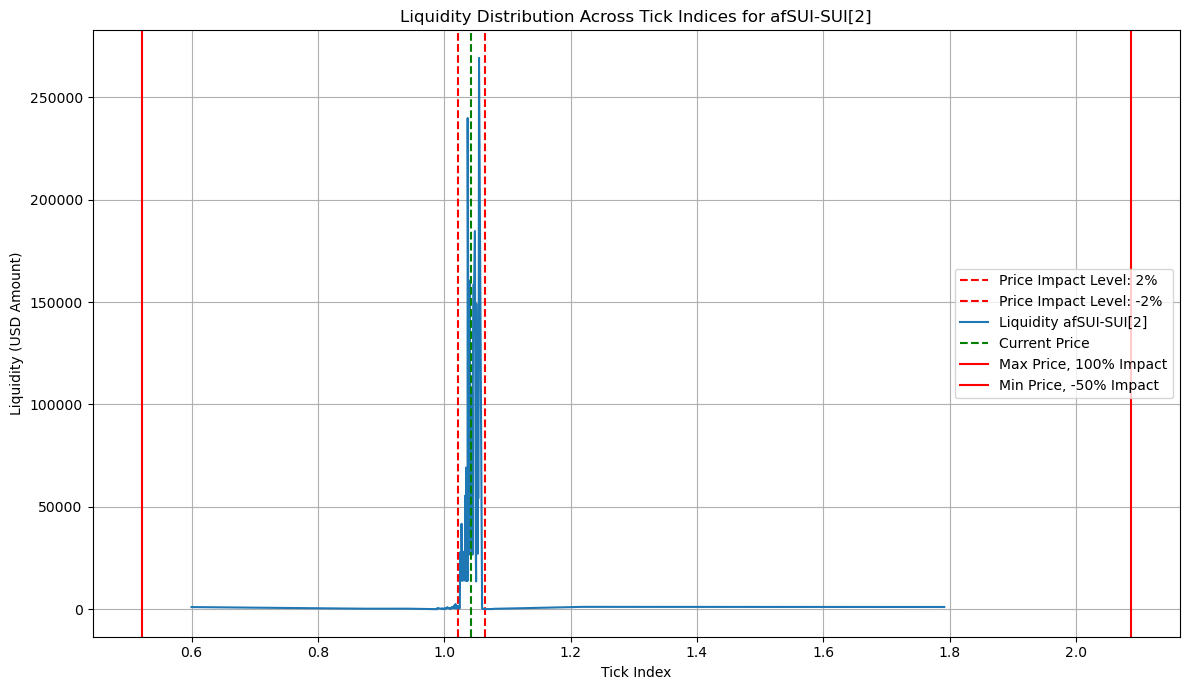


Main info

╒════════════════════╤═════════════════════╕
│ Date               │ 2025-03-18 20:21:49 │
├────────────────────┼─────────────────────┤
│ Current price      │ 1.041719480408837   │
├────────────────────┼─────────────────────┤
│ Amount of vSUI     │ 478753.1475         │
├────────────────────┼─────────────────────┤
│ Amount of SUI      │ 607975.1663         │
├────────────────────┼─────────────────────┤
│ TVL                │ $2478680.2251       │
├────────────────────┼─────────────────────┤
│ USD Amount of vSUI │ $1117017.6896       │
├────────────────────┼─────────────────────┤
│ USD Amount of SUI  │ $1361662.5355       │
╘════════════════════╧═════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤════════════╤══════════════╤═════════════╤════════════╕
│  Direction  │   Amount In │ Token In   │     USD In │ Amount Out   │ Token Out   │ USD Out    │
╞═════════════╪═════════════╪════════════╪════════════╪══════════════╪══════════

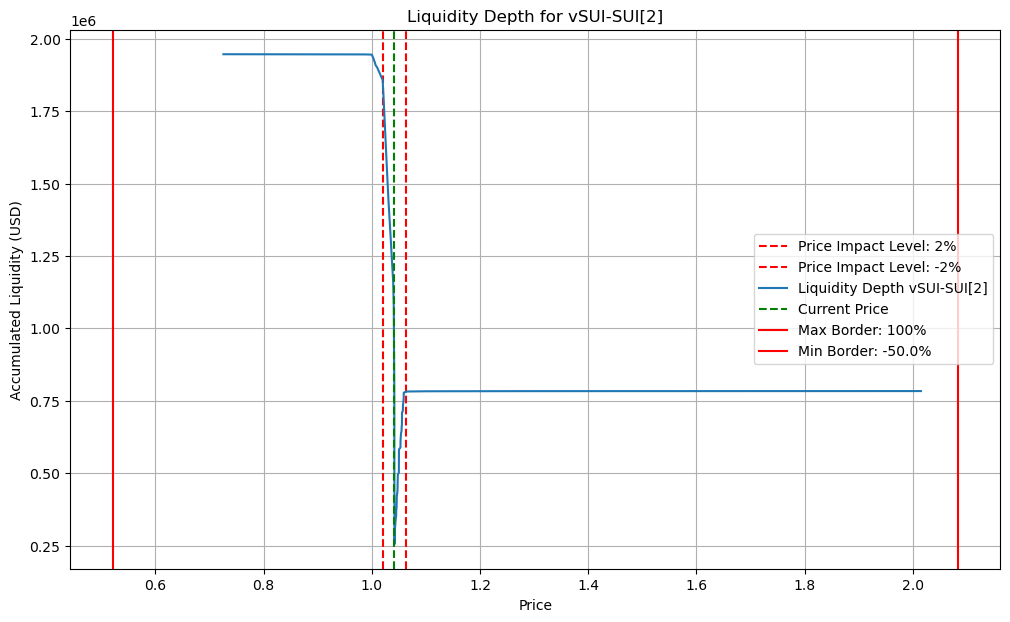

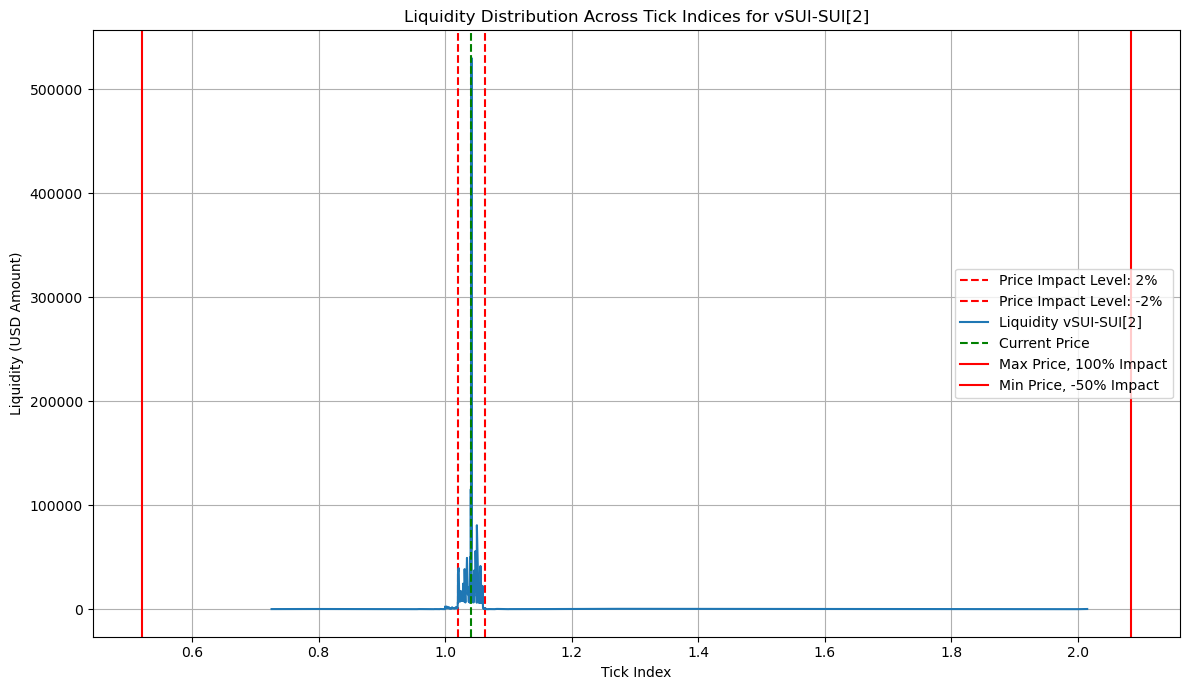


Main info

╒════════════════════╤═════════════════════╕
│ Date               │ 2025-03-18 20:21:51 │
├────────────────────┼─────────────────────┤
│ Current price      │ 36336.80415178678   │
├────────────────────┼─────────────────────┤
│ Amount of WBTC     │ 0.2227              │
├────────────────────┼─────────────────────┤
│ Amount of SUI      │ 28071.5472          │
├────────────────────┼─────────────────────┤
│ TVL                │ $79736.6531         │
├────────────────────┼─────────────────────┤
│ USD Amount of WBTC │ $17495.5195         │
├────────────────────┼─────────────────────┤
│ USD Amount of SUI  │ $62241.1337         │
╘════════════════════╧═════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤═══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │    USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪═══════════╪══════════════╪═════════════╪═

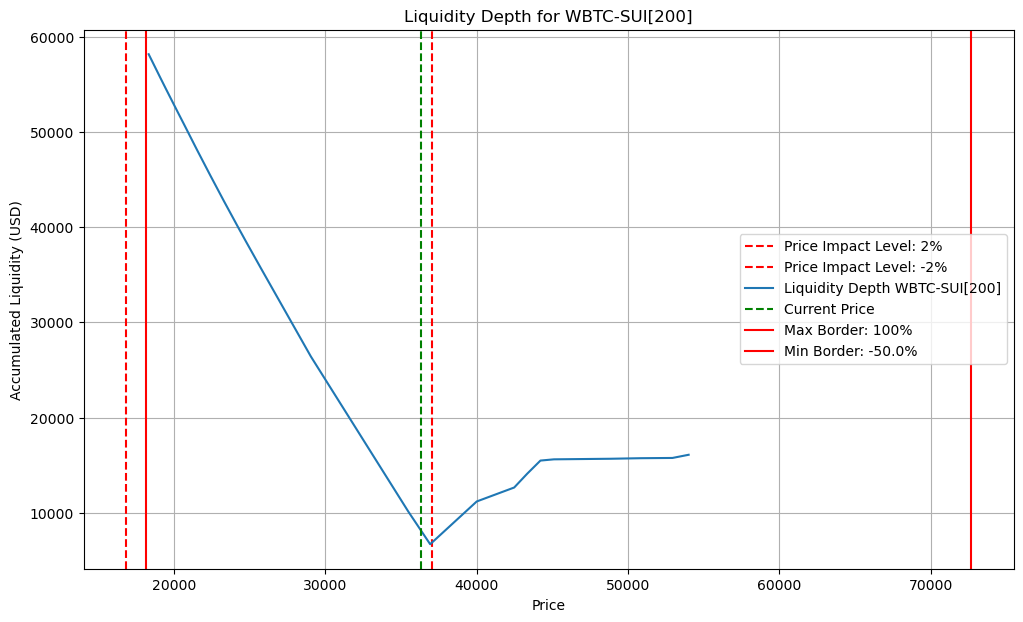

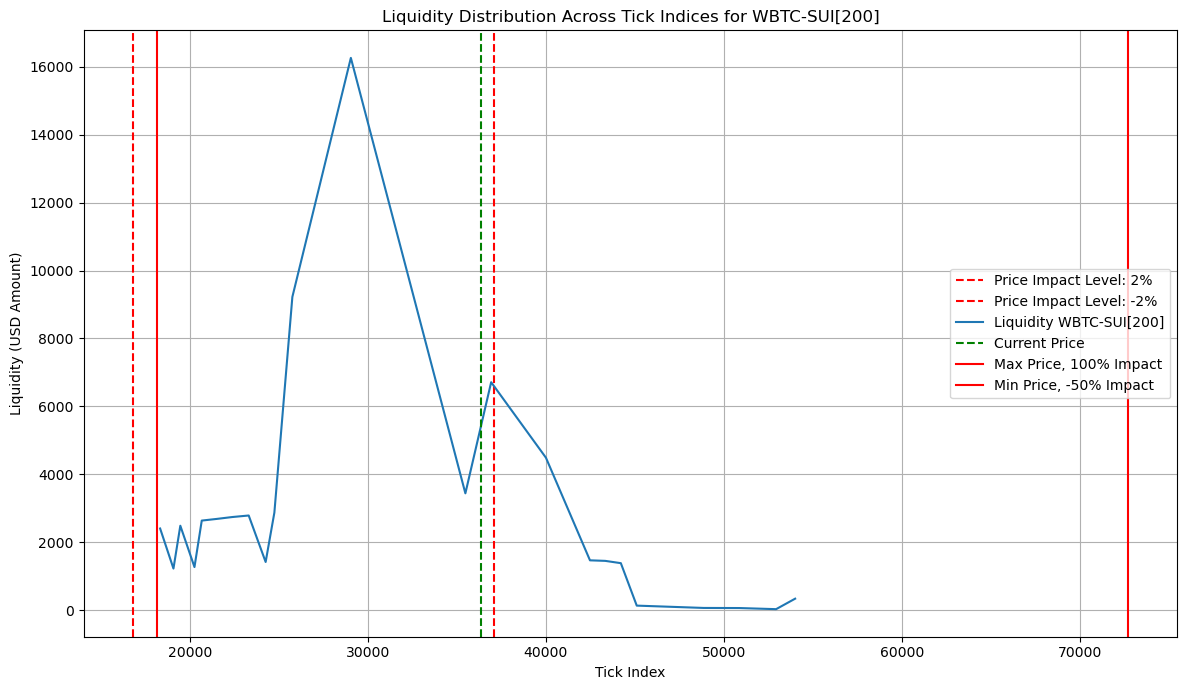


Main info

╒═════════════════════╤══════════════════════╕
│ Date                │ 2025-03-18 20:21:54  │
├─────────────────────┼──────────────────────┤
│ Current price       │ 0.008291260872433075 │
├─────────────────────┼──────────────────────┤
│ Amount of TYPUS     │ 2238765.3875         │
├─────────────────────┼──────────────────────┤
│ Amount of SUI       │ 11484.6949           │
├─────────────────────┼──────────────────────┤
│ TVL                 │ $67062.8450          │
├─────────────────────┼──────────────────────┤
│ USD Amount of TYPUS │ $41468.5294          │
├─────────────────────┼──────────────────────┤
│ USD Amount of SUI   │ $25594.3156          │
╘═════════════════════╧══════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪═══

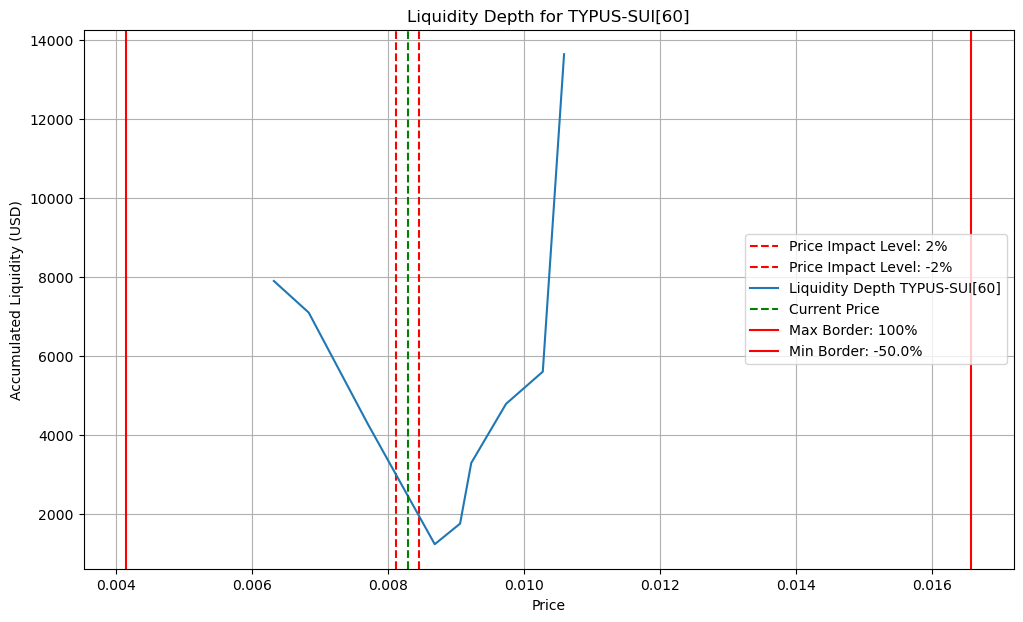

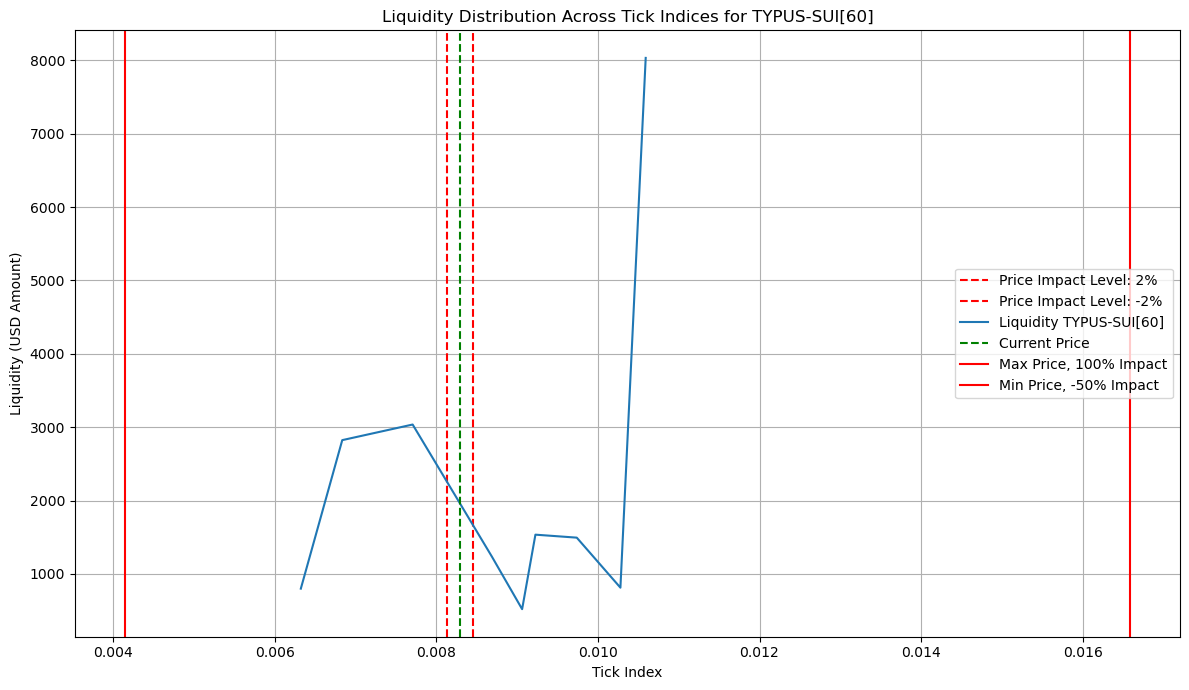


Main info

╒═══════════════════╤═════════════════════╕
│ Date              │ 2025-03-18 20:21:56 │
├───────────────────┼─────────────────────┤
│ Current price     │ 841.5246191799781   │
├───────────────────┼─────────────────────┤
│ Amount of ETH     │ 211.3284            │
├───────────────────┼─────────────────────┤
│ Amount of SUI     │ 251661.0274         │
├───────────────────┼─────────────────────┤
│ TVL               │ $960888.0424        │
├───────────────────┼─────────────────────┤
│ USD Amount of ETH │ $397766.8498        │
├───────────────────┼─────────────────────┤
│ USD Amount of SUI │ $563121.1926        │
╘═══════════════════╧═════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪══════════════╪═════════════╪═══════════╡
│ ↓ A 

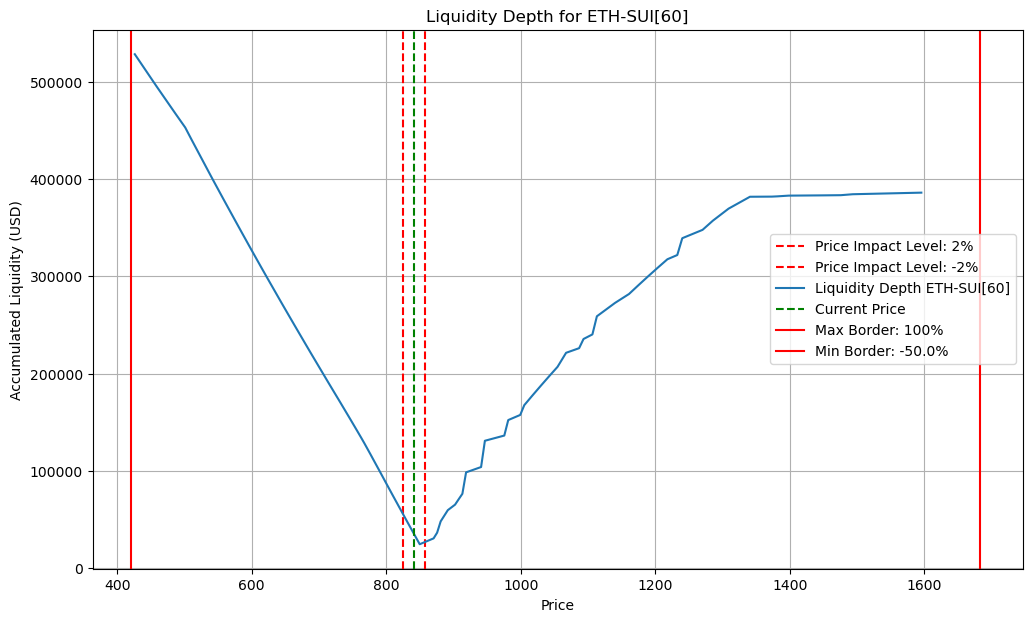

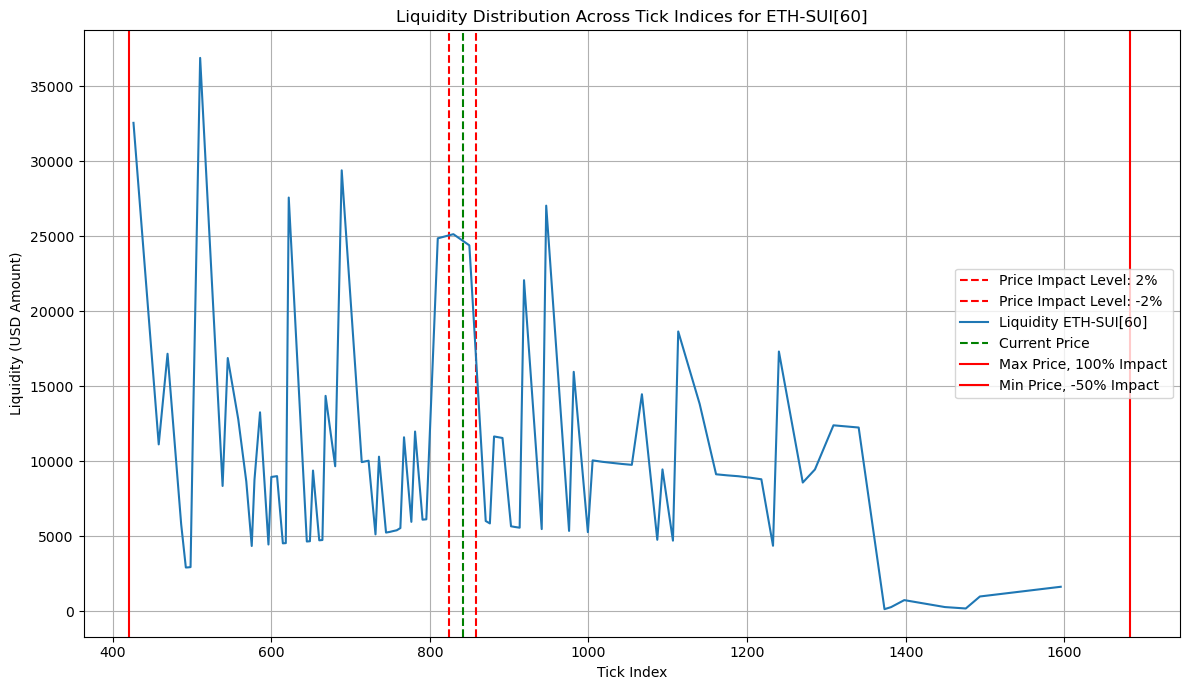


Main info

╒════════════════════╤═════════════════════╕
│ Date               │ 2025-03-18 20:21:58 │
├────────────────────┼─────────────────────┤
│ Current price      │ 0.44300720157551166 │
├────────────────────┼─────────────────────┤
│ Amount of BUCK     │ 14860.7687          │
├────────────────────┼─────────────────────┤
│ Amount of SUI      │ 17091.0154          │
├────────────────────┼─────────────────────┤
│ TVL                │ $52060.7379         │
├────────────────────┼─────────────────────┤
│ USD Amount of BUCK │ $14190.8028         │
├────────────────────┼─────────────────────┤
│ USD Amount of SUI  │ $37869.9350         │
╘════════════════════╧═════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪══════════════╪═════════════╪════

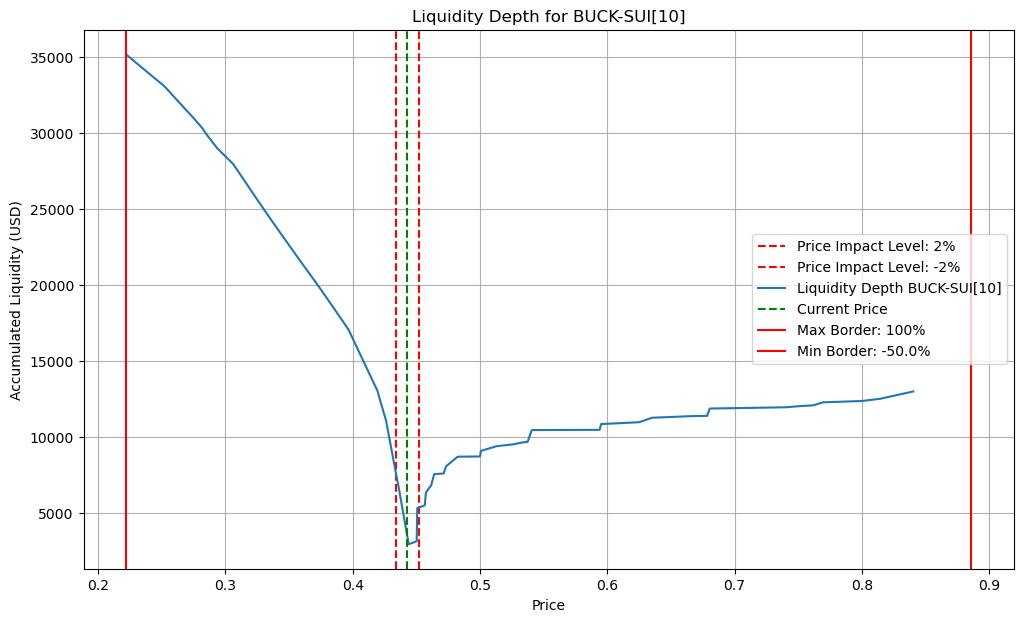

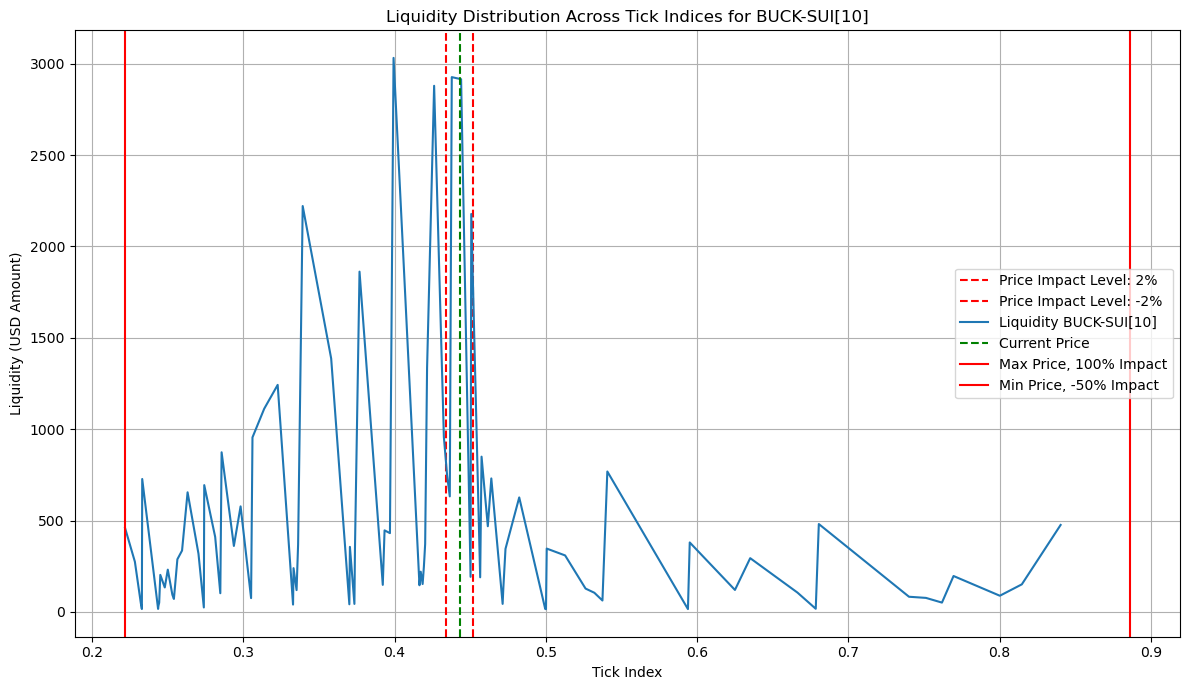


Main info

╒══════════════════════╤════════════════════════╕
│ Date                 │ 2025-03-18 20:21:59    │
├──────────────────────┼────────────────────────┤
│ Current price        │ 0.00045921144300618594 │
├──────────────────────┼────────────────────────┤
│ Amount of MEMEFI     │ 138187462.4586         │
├──────────────────────┼────────────────────────┤
│ Amount of SUI        │ 73914.5773             │
├──────────────────────┼────────────────────────┤
│ TVL                  │ $260163.2009           │
├──────────────────────┼────────────────────────┤
│ USD Amount of MEMEFI │ $130145.8629           │
├──────────────────────┼────────────────────────┤
│ USD Amount of SUI    │ $130017.3380           │
╘══════════════════════╧════════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞══════════

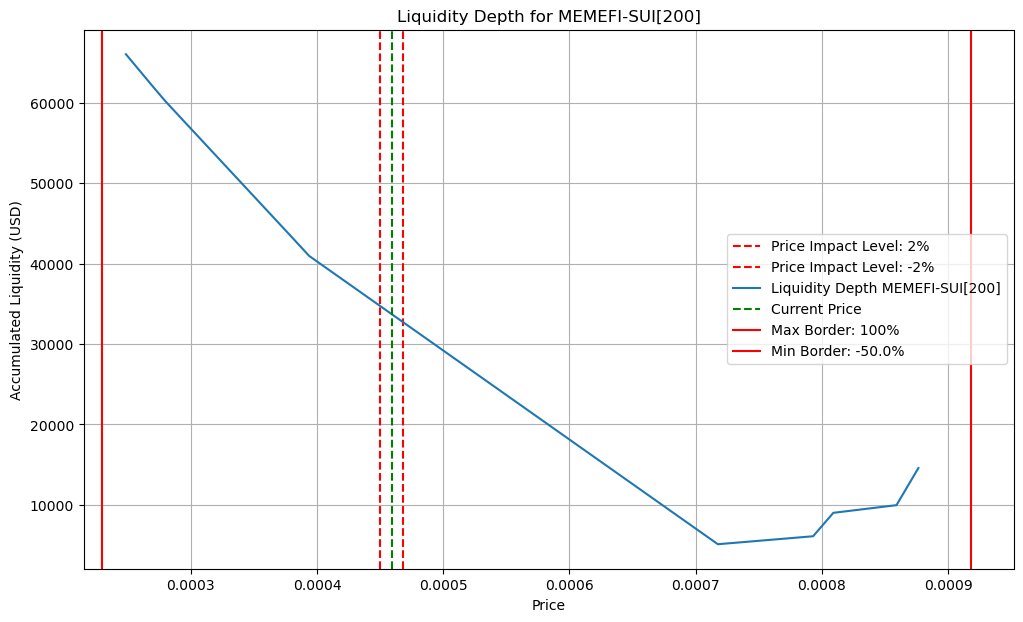

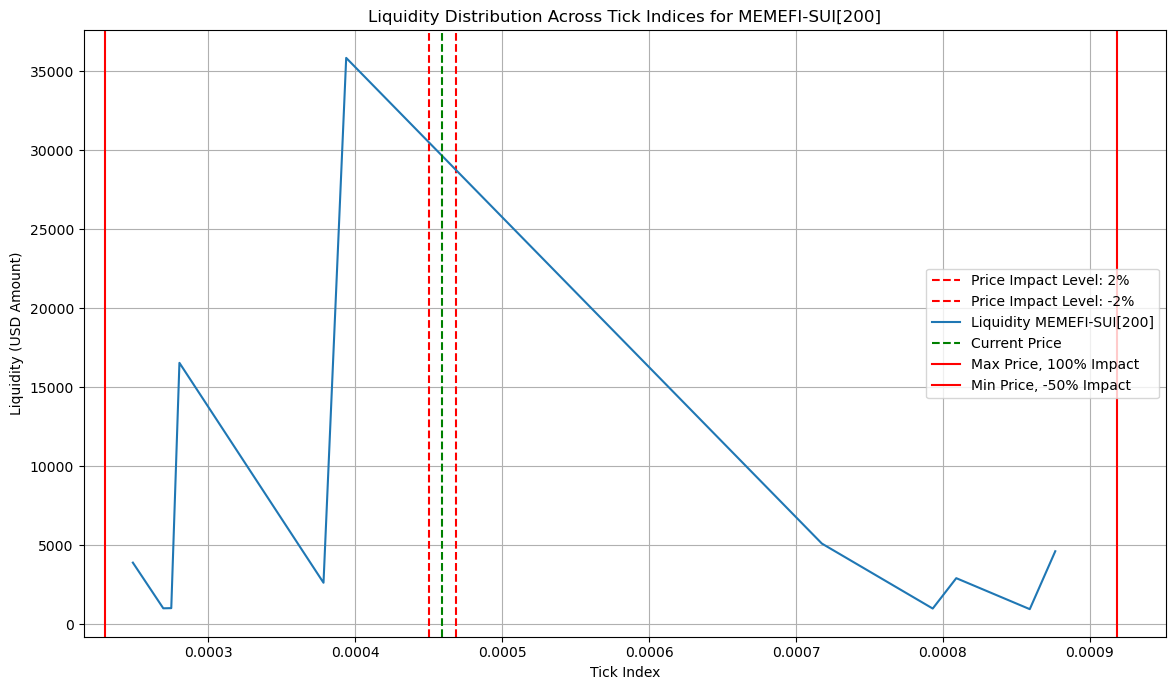


Main info

╒════════════════════╤═════════════════════╕
│ Date               │ 2025-03-18 20:22:01 │
├────────────────────┼─────────────────────┤
│ Current price      │ 54.747774470112844  │
├────────────────────┼─────────────────────┤
│ Amount of WSOL     │ 953.8395            │
├────────────────────┼─────────────────────┤
│ Amount of SUI      │ 48020.9217          │
├────────────────────┼─────────────────────┤
│ TVL                │ $221449.3255        │
├────────────────────┼─────────────────────┤
│ USD Amount of WSOL │ $115444.8132        │
├────────────────────┼─────────────────────┤
│ USD Amount of SUI  │ $106004.5122        │
╘════════════════════╧═════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪══════════════╪═════════════╪════

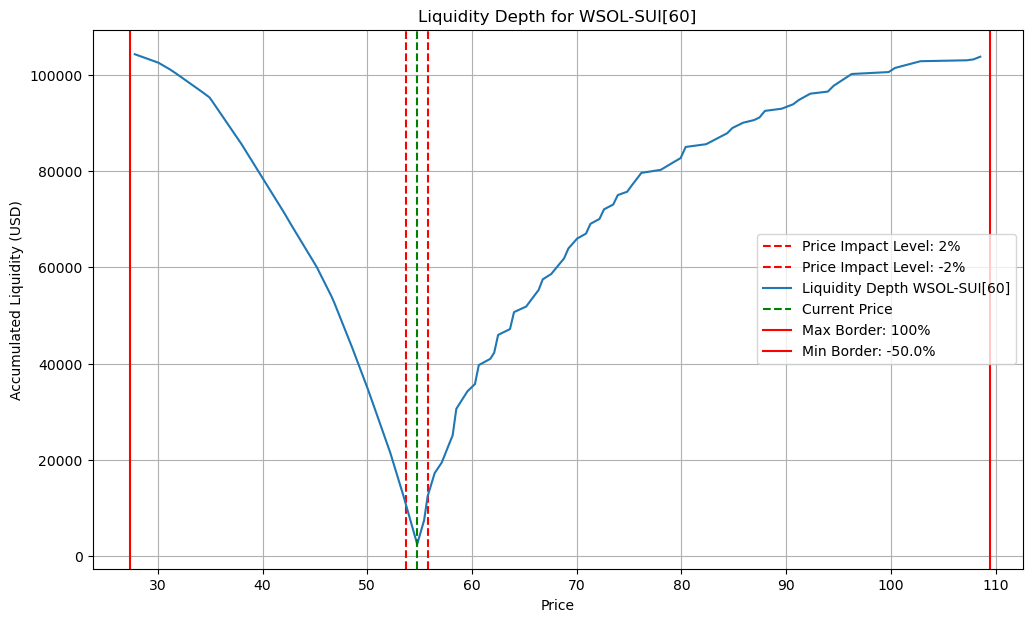

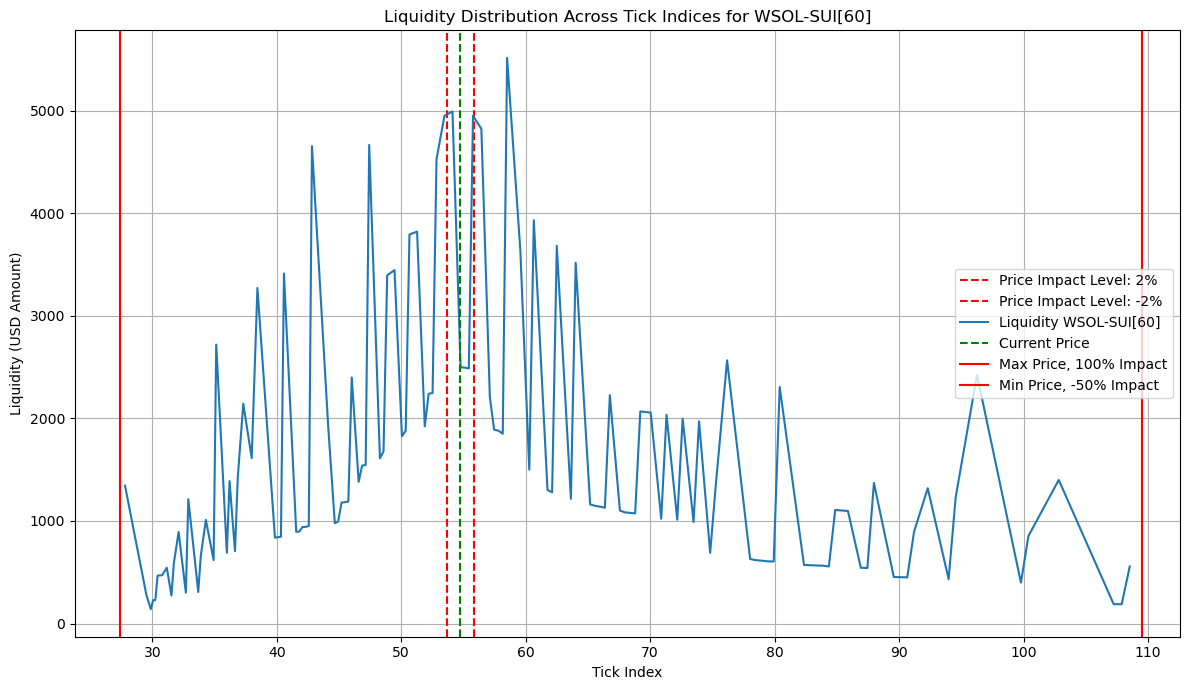


Main info

╒════════════════════╤══════════════════════╕
│ Date               │ 2025-03-18 20:22:03  │
├────────────────────┼──────────────────────┤
│ Current price      │ 0.013946529012493915 │
├────────────────────┼──────────────────────┤
│ Amount of SUIA     │ 4477025.6449         │
├────────────────────┼──────────────────────┤
│ Amount of SUI      │ 31885.4565           │
├────────────────────┼──────────────────────┤
│ TVL                │ $195512.4749         │
├────────────────────┼──────────────────────┤
│ USD Amount of SUIA │ $137299.6870         │
├────────────────────┼──────────────────────┤
│ USD Amount of SUI  │ $58212.7879          │
╘════════════════════╧══════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪══════════════╪═══

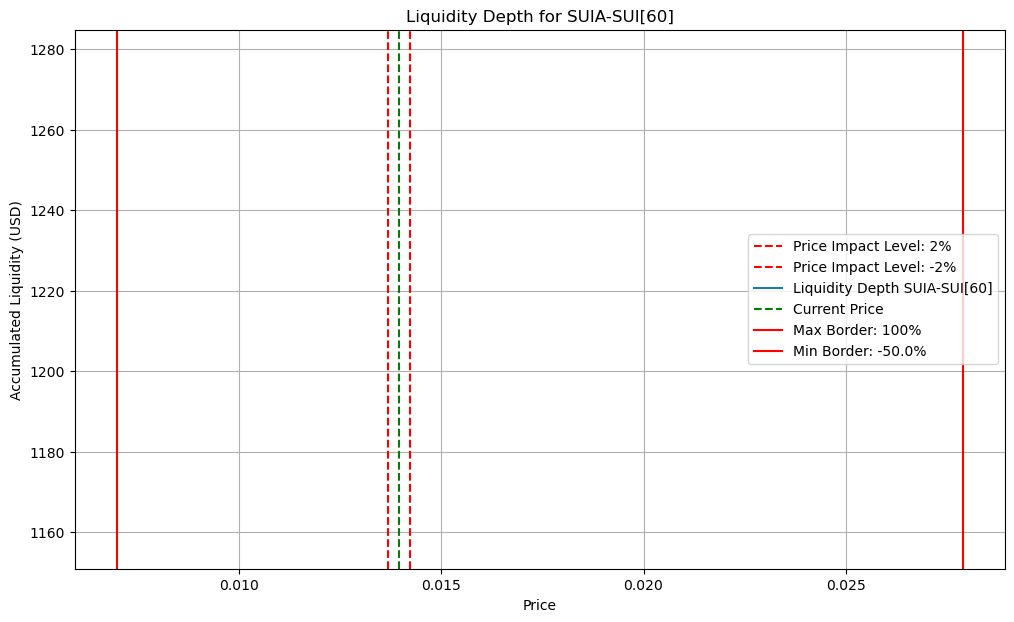

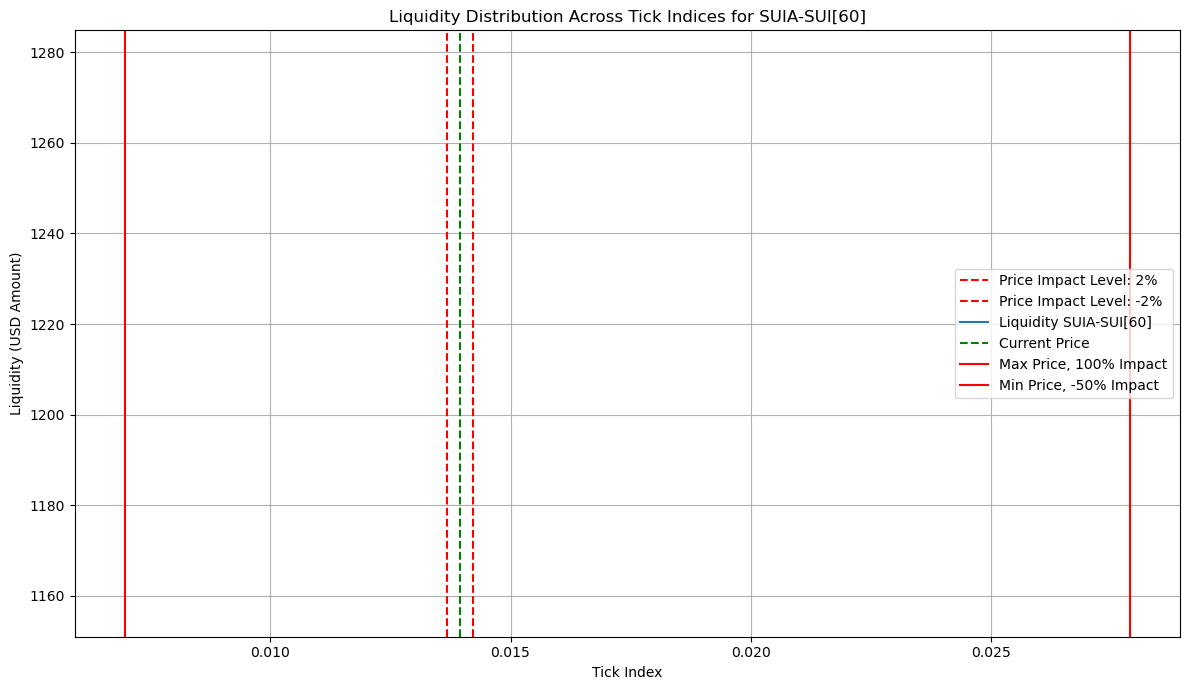


Main info

╒═══════════════════╤═══════════════════════╕
│ Date              │ 2025-03-18 20:22:04   │
├───────────────────┼───────────────────────┤
│ Current price     │ 0.0001305251092904717 │
├───────────────────┼───────────────────────┤
│ Amount of Uni     │ 107840348.5427        │
├───────────────────┼───────────────────────┤
│ Amount of SUI     │ 14062.3166            │
├───────────────────┼───────────────────────┤
│ TVL               │ $62626.7814           │
├───────────────────┼───────────────────────┤
│ USD Amount of Uni │ $31354.1836           │
├───────────────────┼───────────────────────┤
│ USD Amount of SUI │ $31272.5977           │
╘═══════════════════╧═══════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪══════════════╪═══

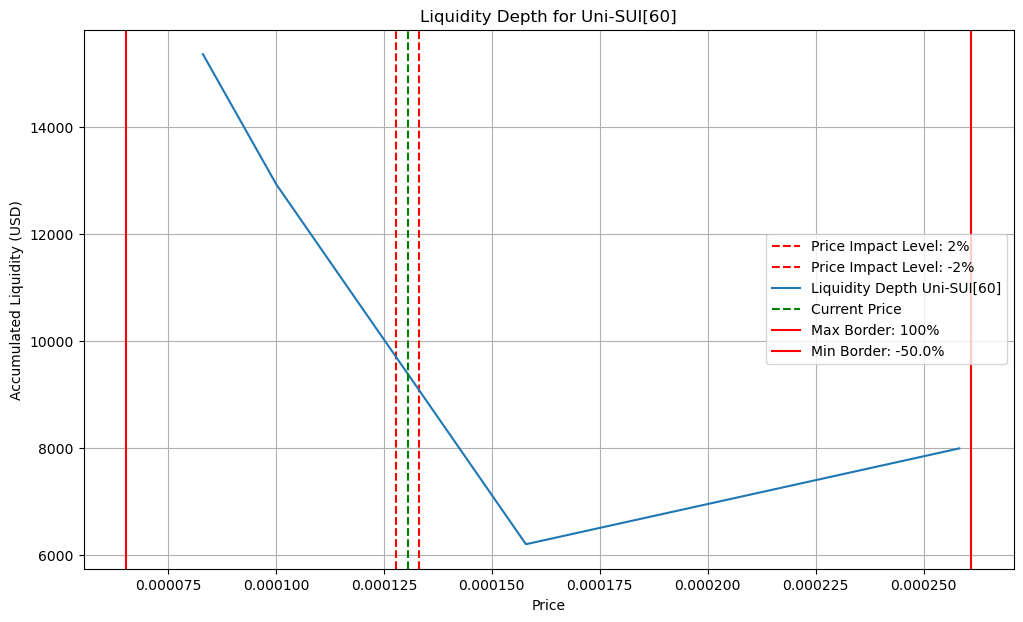

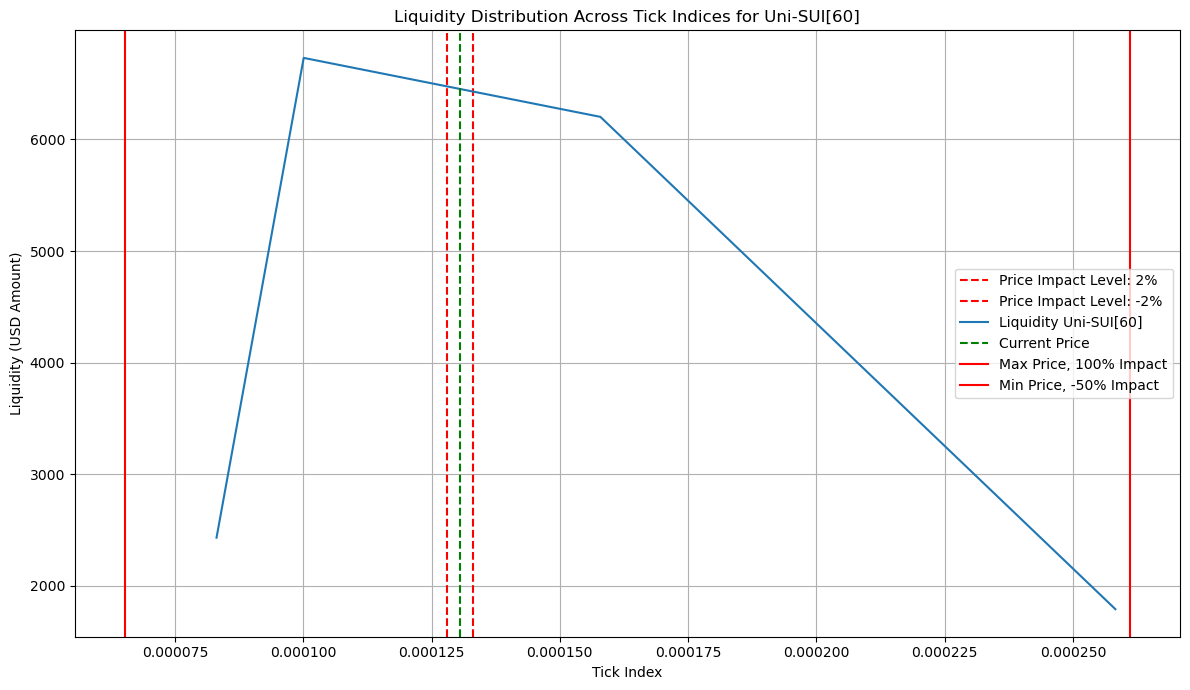


Main info

╒══════════════════════╤══════════════════════╕
│ Date                 │ 2025-03-18 20:22:06  │
├──────────────────────┼──────────────────────┤
│ Current price        │ 4.44005076917618e-05 │
├──────────────────────┼──────────────────────┤
│ Amount of OCEANS     │ 204130444.3141       │
├──────────────────────┼──────────────────────┤
│ Amount of SUI        │ 9058.6542            │
├──────────────────────┼──────────────────────┤
│ TVL                  │ $40404.3405          │
├──────────────────────┼──────────────────────┤
│ USD Amount of OCEANS │ $20250.3312          │
├──────────────────────┼──────────────────────┤
│ USD Amount of SUI    │ $20154.0094          │
╘══════════════════════╧══════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════

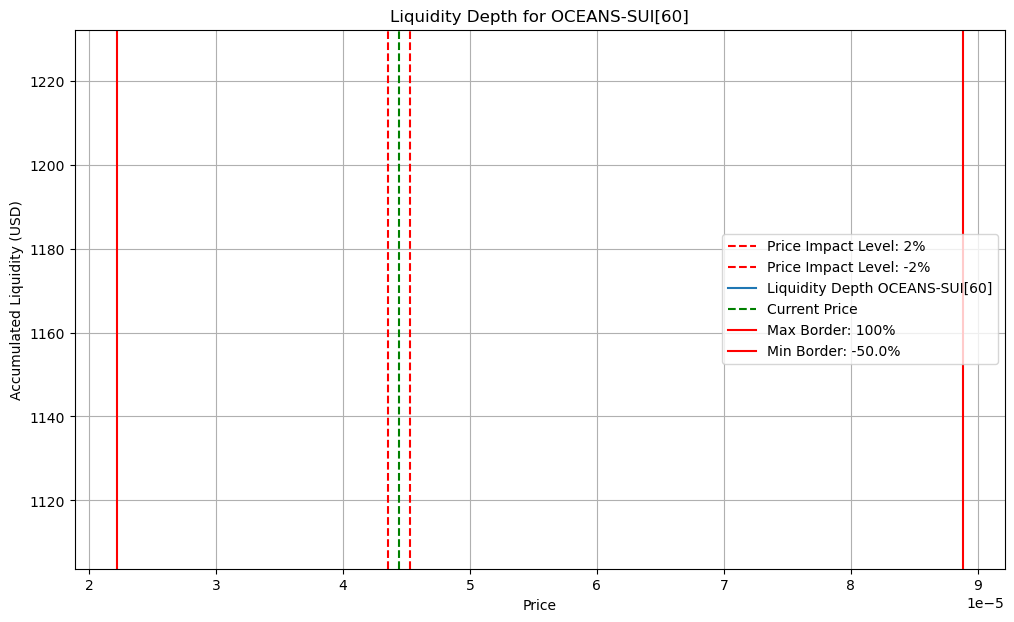

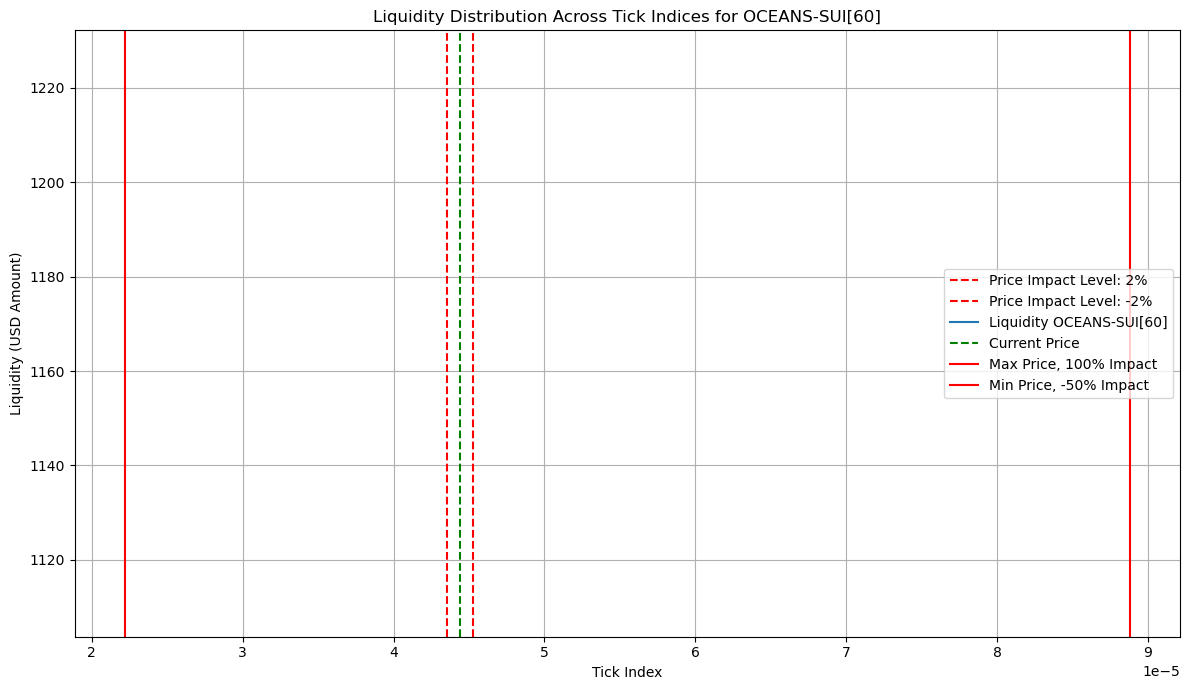


Main info

╒════════════════════╤═══════════════════════╕
│ Date               │ 2025-03-18 20:22:08   │
├────────────────────┼───────────────────────┤
│ Current price      │ 0.0077328625094077695 │
├────────────────────┼───────────────────────┤
│ Amount of LOFI     │ 25986104.3146         │
├────────────────────┼───────────────────────┤
│ Amount of SUI      │ 199795.8687           │
├────────────────────┼───────────────────────┤
│ TVL                │ $885821.4774          │
├────────────────────┼───────────────────────┤
│ USD Amount of LOFI │ $445449.7532          │
├────────────────────┼───────────────────────┤
│ USD Amount of SUI  │ $440371.7242          │
╘════════════════════╧═══════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════╪══════════╪═══

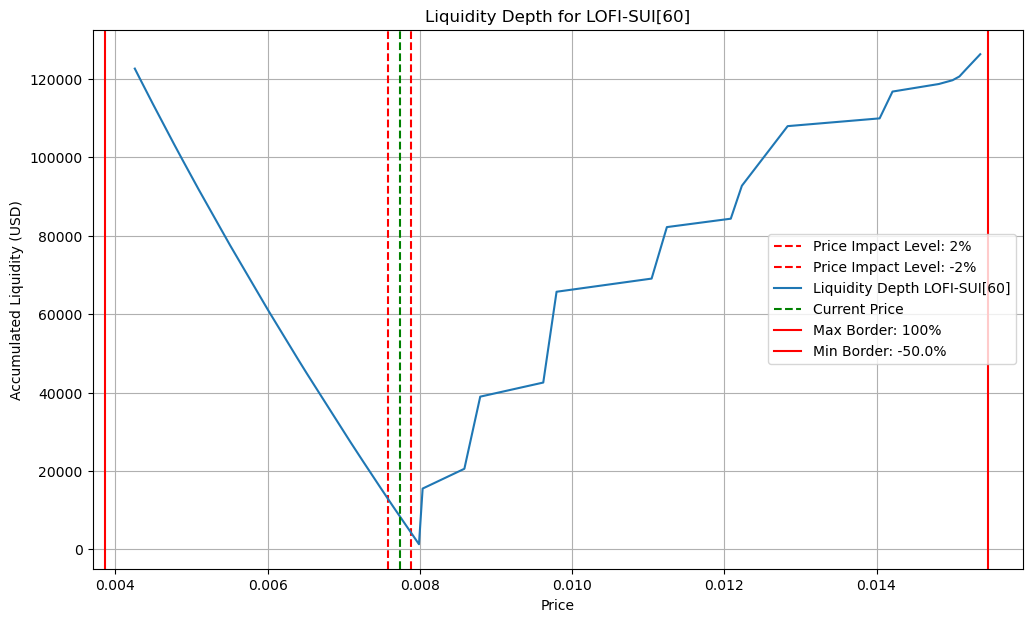

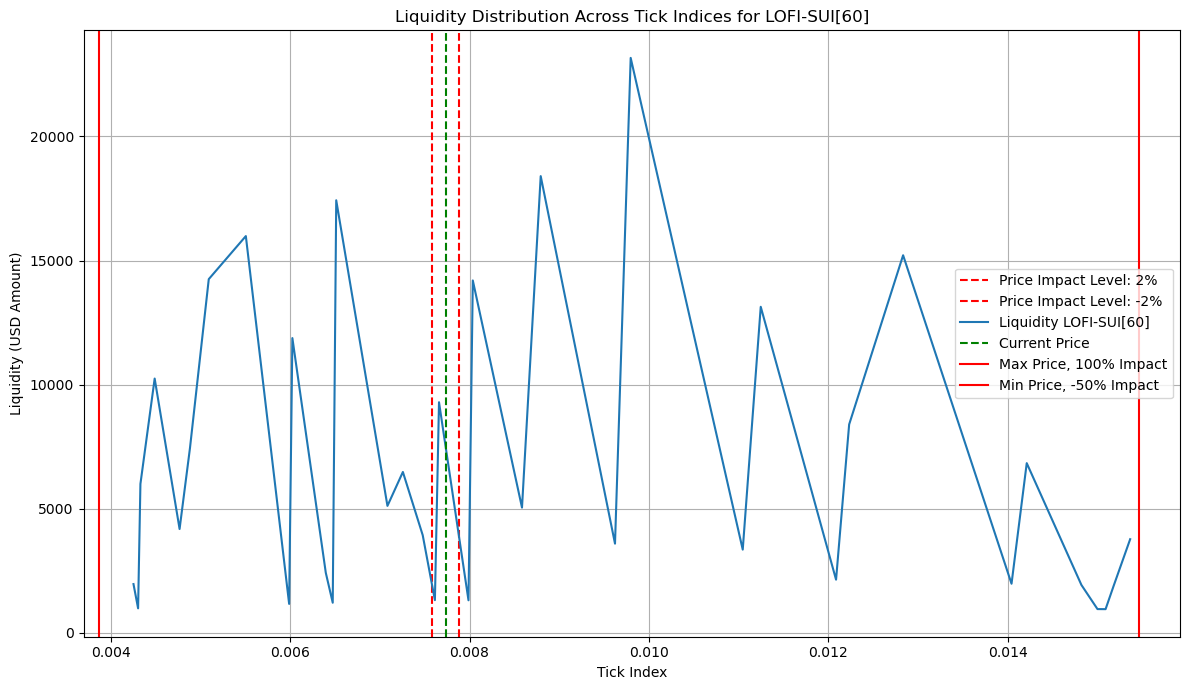


Main info

╒═════════════════════╤═══════════════════════╕
│ Date                │ 2025-03-18 20:22:10   │
├─────────────────────┼───────────────────────┤
│ Current price       │ 0.0008036697111605735 │
├─────────────────────┼───────────────────────┤
│ Amount of TARDI     │ 40607707.1243         │
├─────────────────────┼───────────────────────┤
│ Amount of SUI       │ 76525.3096            │
├─────────────────────┼───────────────────────┤
│ TVL                 │ $242883.8579          │
├─────────────────────┼───────────────────────┤
│ USD Amount of TARDI │ $72540.1946           │
├─────────────────────┼───────────────────────┤
│ USD Amount of SUI   │ $170343.6633          │
╘═════════════════════╧═══════════════════════╛

Trade Sizes Reaching 0.5% Slippage

╒═════════════╤═════════════╤════════════╤══════════╤══════════════╤═════════════╤═══════════╕
│  Direction  │   Amount In │ Token In   │   USD In │ Amount Out   │ Token Out   │ USD Out   │
╞═════════════╪═════════════╪════════════

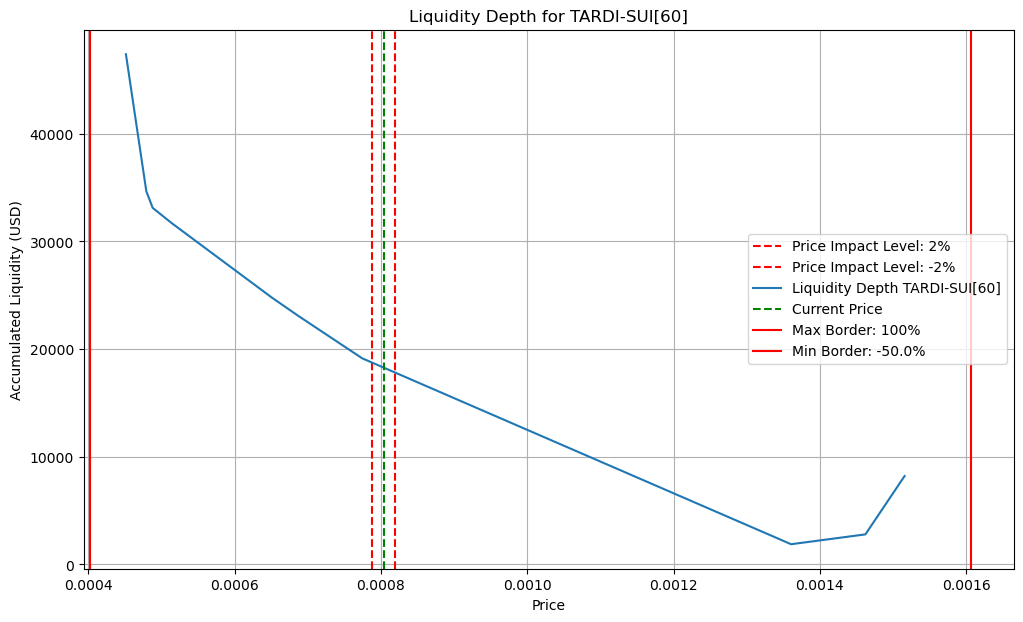

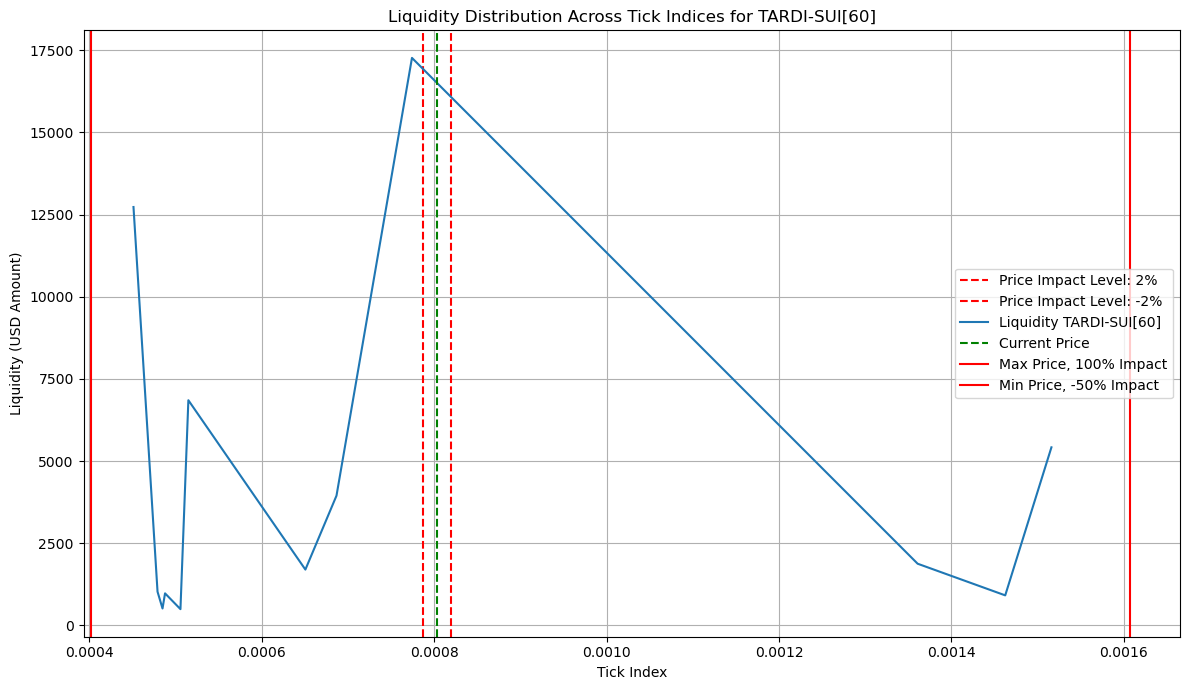

In [26]:
from tabulate import tabulate
import colorama
from colorama import Fore, Style

# Table for coin amounts for different slippage sizes
def create_slippage_table(impact):
    # Create a title with formatting
    title = f"{Fore.CYAN}{Style.BRIGHT}Trade Sizes Reaching {impact.price_impact}% Slippage{Style.RESET_ALL}"
    
    
    data = [
        ["Direction", "Amount In", "Token In", "USD In", "Amount Out", "Token Out", "USD Out"],
        [
            f"{Fore.GREEN}↓ A to B ↓{Style.RESET_ALL}", 
            f"{impact.a2b.estimatedAmountIn / 10 ** impact.a2b.decimalsIn:.6f}", 
            impact.a2b.symbolIn,
            f"${impact.a2b.usdAmountIn:.2f}",
            f"{impact.a2b.estimatedAmountOut / 10 ** impact.a2b.decimalsOut:.6f}",
            impact.a2b.symbolOut,
            f"${impact.a2b.usdAmountOut:.2f}"
        ],
        [
            f"{Fore.BLUE}↑ B to A ↑{Style.RESET_ALL}", 
            f"{impact.b2a.estimatedAmountIn / 10 ** impact.b2a.decimalsIn:.6f}", 
            impact.b2a.symbolIn,
            f"${impact.b2a.usdAmountIn:.2f}",
            f"{impact.b2a.estimatedAmountOut / 10 ** impact.b2a.decimalsOut:.6f}",
            impact.b2a.symbolOut,
            f"${impact.b2a.usdAmountOut:.2f}"
        ]
    ]
    
    # Create the table using tabulate
    colalign = ["center", "right", "left", "right", "left"]
    table = tabulate(data, headers="firstrow", tablefmt="fancy_grid", colalign=colalign)
    
    # Return the full output
    return f"\n{title}\n\n{table}"

# Plots for each pool
for pool_name, pool_ticks in ticks_dict.items():
    #if pool_name != 'NS-SUI[60]':
     #     continue


    
    # Plot main information
    title = f"{Fore.CYAN}{Style.BRIGHT}Main info{Style.RESET_ALL}"
    
    data = [
        [f"{Fore.GREEN}Date{Style.RESET_ALL}", f"{pool_ticks.date}"],
        [f"{Fore.GREEN}Current price{Style.RESET_ALL}", f"{pool_ticks.current_price}"],
        [f"{Fore.GREEN}Amount of {pool_ticks.a_symbol}{Style.RESET_ALL}", f"{(pool_ticks.a_amount / (10 ** pool_ticks.a_decimals)):.4f}"],
        [f"{Fore.GREEN}Amount of {pool_ticks.b_symbol}{Style.RESET_ALL}", f"{(pool_ticks.b_amount / (10 ** pool_ticks.b_decimals)):.4f}"],
        [f"{Fore.GREEN}TVL{Style.RESET_ALL}", f"${pool_ticks.usd_amount:.4f}"], 
        [f"{Fore.GREEN}USD Amount of {pool_ticks.a_symbol}{Style.RESET_ALL}", f"${pool_ticks.usd_a_amount:.4f}"],
        [f"{Fore.GREEN}USD Amount of {pool_ticks.b_symbol}{Style.RESET_ALL}", f"${pool_ticks.usd_b_amount:.4f}"],
    ]
    
    # Create the table using tabulate
    colalign = ["left", "left"]
    table = tabulate(data, tablefmt="fancy_grid", colalign=colalign)
    
    print(f"\n{title}\n\n{table}")


    
    # Plot price impacts
    for impact in pool_ticks.price_impacts:
        print(create_slippage_table(impact))


    
    # Plot liquidity depth
    plt.figure(figsize=(12, 7))

    for impact in pool_ticks.price_impacts:
        if impact.price_impact == 2:
            plt.axvline(x=impact.a2b.estimatedEndPrice, color="red", linestyle="--",
                    label=f"Price Impact Level: {impact.price_impact}%")
            plt.axvline(x=impact.b2a.estimatedEndPrice, color="red", linestyle="--",
                    label=f"Price Impact Level: -{impact.price_impact}%")

    

    plot_liquidity_depth(pool_ticks)
    plt.axvline(x=pool_ticks.current_price, color="green", linestyle="--", label=f"Current Price")
    plt.axvline(x=pool_ticks.max_price, color="red", linestyle="-", label=f"Max Border: {max_impact_level * 100}%")
    plt.axvline(x=pool_ticks.min_price, color="red", linestyle="-", label=f"Min Border: {min_impact_level * 100}%")    
    plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
    plt.show()


    
    # Plot liquidity distribution
    plt.figure(figsize=(12, 7))

    for impact in pool_ticks.price_impacts:
        if impact.price_impact == 2:
            plt.axvline(x=impact.a2b.estimatedEndPrice, color="red", linestyle="--",
                    label=f"Price Impact Level: {impact.price_impact}%")
            plt.axvline(x=impact.b2a.estimatedEndPrice, color="red", linestyle="--",
                    label=f"Price Impact Level: -{impact.price_impact}%")

    plot_liquidity(pool_ticks)
    plt.axvline(x=pool_ticks.current_price, color="green", linestyle="--", label=f"Current Price")
    plt.axvline(x=pool_ticks.max_price, color="red", linestyle="-", label=f"Max Price, 100% Impact")
    plt.axvline(x=pool_ticks.min_price, color="red", linestyle="-", label=f"Min Price, -50% Impact")
    plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
    plt.show()

## Functions for coin's holders

In [28]:
#Function to fetch coin holders (it's very slow cause of the BlockBerry API's bandwidth)
holders = {}
def GetCoinHolders(coinType, coinDenom):  
    url1 = f"https://api.blockberry.one/sui/v1/coins/{coinType}/holders?page="
    url2 = "&size=50&orderBy=DESC&sortBy=AMOUNT"

    holders_headers = {
    "accept": "*/*",
    "x-api-key": "dXoCssStNAoNGD934PxfeMx6qck1UC"
    }
    df_name = f"hdf_{coinDenom}"  # Dynamic name
    
    holders[df_name] = pd.DataFrame() 
    
    holders_resp = requests.get(f"{url1}0{url2}", headers=holders_headers)
    page_amount = (holders_resp.json())['totalPages']
    time.sleep(15)
        
    for page_number in range(0, page_amount):
        # Request the page JSON data
       holders_response = requests.get(f"{url1}{page_number}{url2}", headers=holders_headers)
       data = {}
       time.sleep(15)
       try:
            data = holders_response.json()  # Attempt to parse JSON
            print(f"Page {page_number}")
       except requests.exceptions.JSONDecodeError:
            print(f"Failed to parse JSON on page {page_number}") 
           
       if 'content' in data and data['content']:
            # Extract data from the response
            page_data = data['content']
        
           # Convert the page data into a DataFrame and append it
            page_df = pd.DataFrame(page_data)
            holders[df_name] = pd.concat([holders[df_name], page_df], ignore_index=True)
        
            # Move to the next page
            page_number += 1
       else:
            page_number += 1
    
    return holders[df_name]

In [30]:
coins_holders = {}

def fetch_all_holders(coins):
    holders_dir = os.path.join(os.getcwd(), 'holders')
    
    for _, row in coins.iterrows():  # Iterate over each row
        coin_type, coin_name = row["coinType"], row["coinDenom"]
        df_name = f"{coin_name}"  # Dynamic DataFrame name
        
        print(f"Fetching holders for {coin_name}")
        # Get holders data
        holder_data = GetCoinHolders(coin_type, coin_name)
        
        # Store in dictionary
        coins_holders[df_name] = holder_data
        
        # Save to CSV in the holders directory
        csv_path = os.path.join(holders_dir, f"{coin_name}.csv")
        holder_data.to_csv(csv_path, index=False)
        print(f"Saved {coin_name} holders data to {csv_path}")

In [32]:
import seaborn as sns

def holders_plot(df):  #function for plotting holders data
    def categorize_wallet(usd_amount):
        if usd_amount < 100:
            return "Shrimp (<$100)"
        elif usd_amount < 1000:
            return "Crab ($100-$1K)"
        elif usd_amount < 10000:
            return "Fish ($1K-$10K)"
        elif usd_amount < 100000:
            return "Shark ($10K-$100K)"
        else:
            return "Whale (>$100K)"
            
    if df['usdAmount'].notnull().any():
        df['wallet_type'] = df['usdAmount'].apply(categorize_wallet)

        
# Visualization: Wallet Distribution (Pie Chart)
        plt.figure(figsize=(8, 6))

        # Get counts and labels
        counts = df['wallet_type'].value_counts()
        labels = counts.index
    
        # Create the pie chart without labels
        wedges, _ = plt.pie(counts, colors=sns.color_palette("pastel"))
        plt.title(f"Wallet Distribution for {df['coinDenom'].iloc[0]}")
    
        # Create legend with labels and percentages
        legend_labels = [f"{label}: {count / counts.sum() * 100:.1f}%" for label, count in zip(labels, counts)]
        plt.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
        plt.show()


        
# Visualization: USD Holdings by Wallet Type (Bar Chart)
        plt.figure(figsize=(10, 6))
        
        wallet_order = [
            "Shrimp (<$100)", "Crab ($100-$1K)", "Fish ($1K-$10K)", "Shark ($10K-$100K)", "Whale (>$100K)"
        ]
    
        # Ensure NaN values are handled
        df['wallet_type'] = df['wallet_type'].fillna("Unknown")
    
        # Create the bar chart
        barplot = sns.barplot(x=df['wallet_type'], y=df['usdAmount'], estimator=sum, order=wallet_order,
                              hue=df['wallet_type'], palette='viridis', legend=False)
    
        # Add title and labels
        plt.title(f"Total Holdings by Wallet Type for {df['coinDenom'].iloc[0]}")
        plt.xlabel("Wallet Type")
        plt.ylabel("Total USD Amount")
        plt.xticks(rotation=30)
    
        # Create legend with USD amounts and corresponding colors
        total_amounts = df.groupby('wallet_type')['usdAmount'].sum().reindex(wallet_order, fill_value=0)
        legend_labels = [f"{wallet}: ${amount:,.2f}" for wallet, amount in total_amounts.items()]
    
        handles = [plt.Line2D([0], [0], color=barplot.patches[i].get_facecolor(), linewidth=10) for i in range(len(barplot.patches))]
    
        plt.legend(handles, legend_labels, title="USD Amount", loc="center left", bbox_to_anchor=(1, 0.5))
    
        # Display the plot
        plt.show()

            
# Visualization: Percentage of coins held (Bar Chart)       
    percentage_plot = df['percentage'].head(20)
    plt.figure(figsize=(8, 6))
    ax = (percentage_plot.plot(kind = 'bar'))
    
    ax.legend(
        title=f"Percentage of coins held for {df['coinDenom'].iloc[0]}",  # Add a title to the legend
        loc='upper right', # Position of the legend
        fontsize=9        # Font size of legend text
    )
    
    # Customize labels
    ax.set_xlabel('Holders', fontsize=10)
    
    plt.xticks(np.arange(min(percentage_plot.index), max(percentage_plot.index) + 1))
    plt.show()

## Fetch coins holders

In [34]:
#select a coin by its DENOM
#coins_all_sort_plot = coins_all_sort.loc[(coins_all_sort['coinDenom'] == 'AUSD')]

#or load holders for multiple selected coins
#coins_all_sort_plot = coins_all_sort.iloc[7:9] 

In [36]:
#coins_holders_fetch = fetch_all_holders(coins_all_sort_plot)

## Visualize coins holders

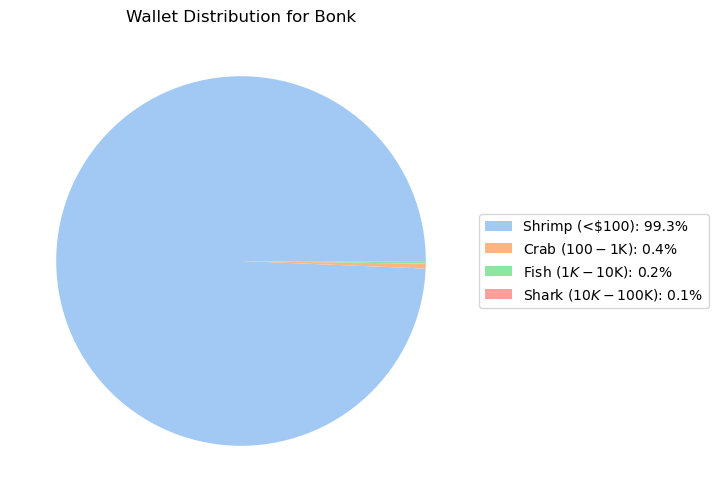

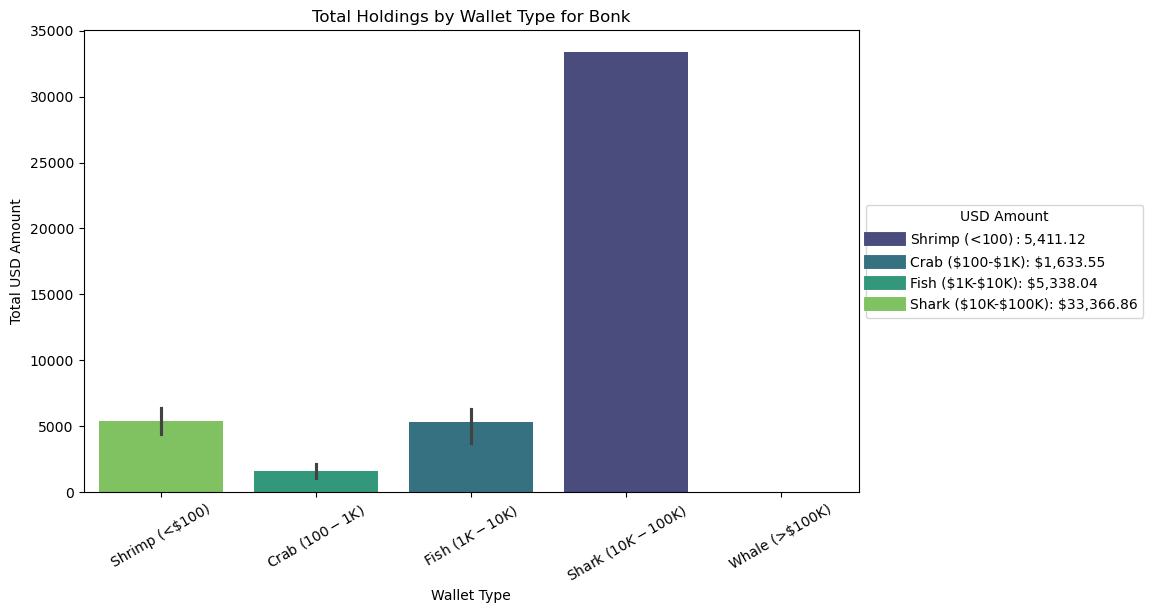

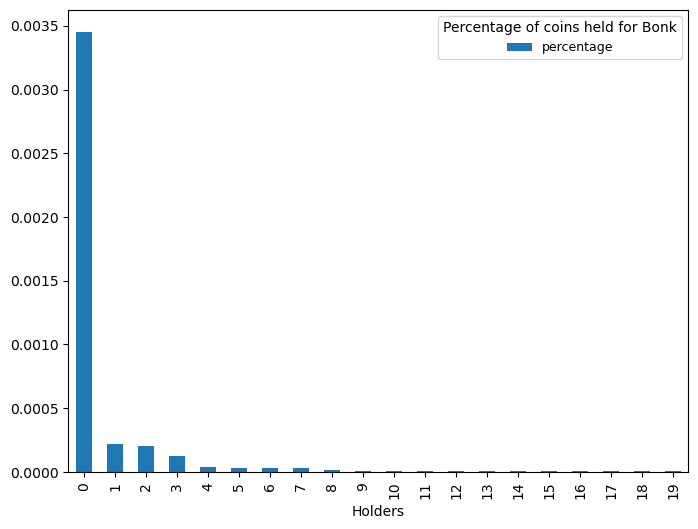

In [38]:
Bonk = pd.read_csv('holders/Bonk.csv') #load the holders csv

holders_plot(Bonk)

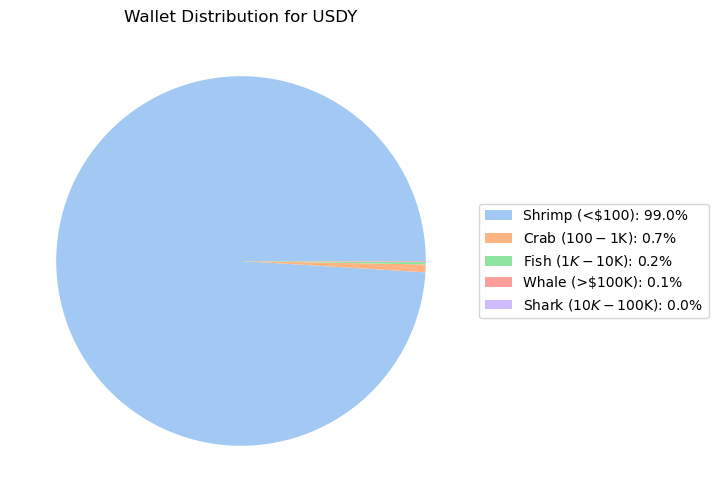

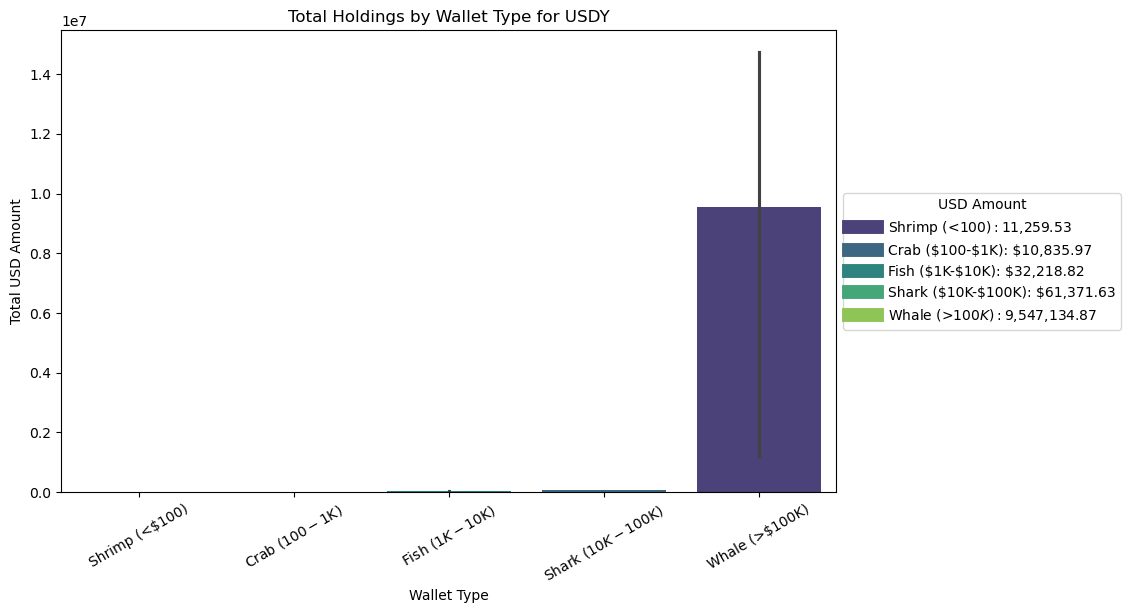

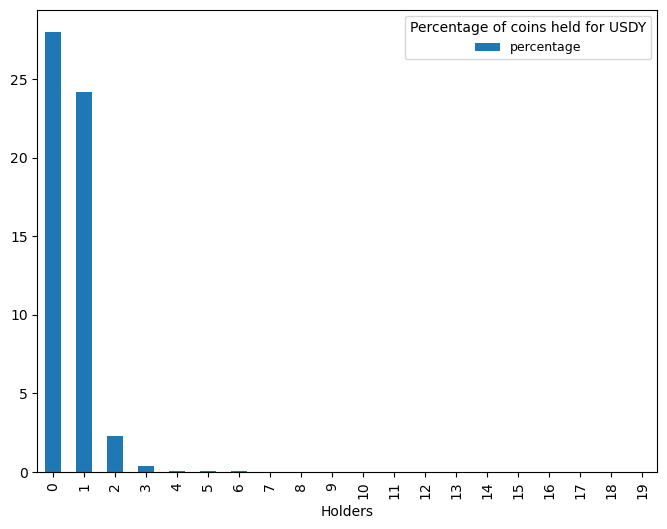

In [40]:
USDY = pd.read_csv('holders/USDY.csv') #load the holders csv

holders_plot(USDY)

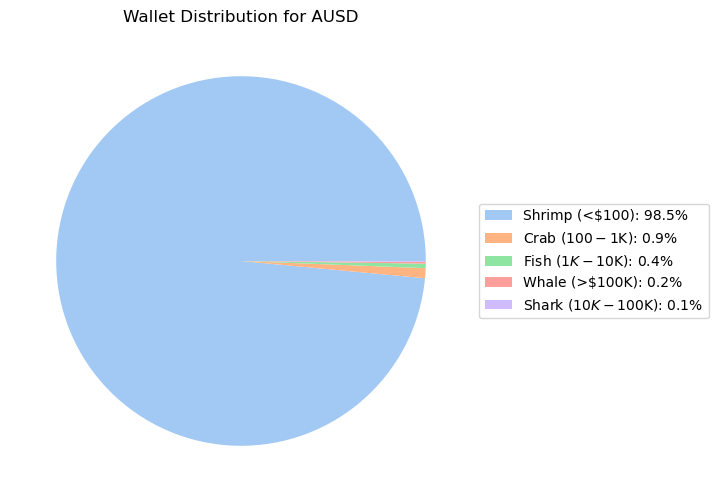

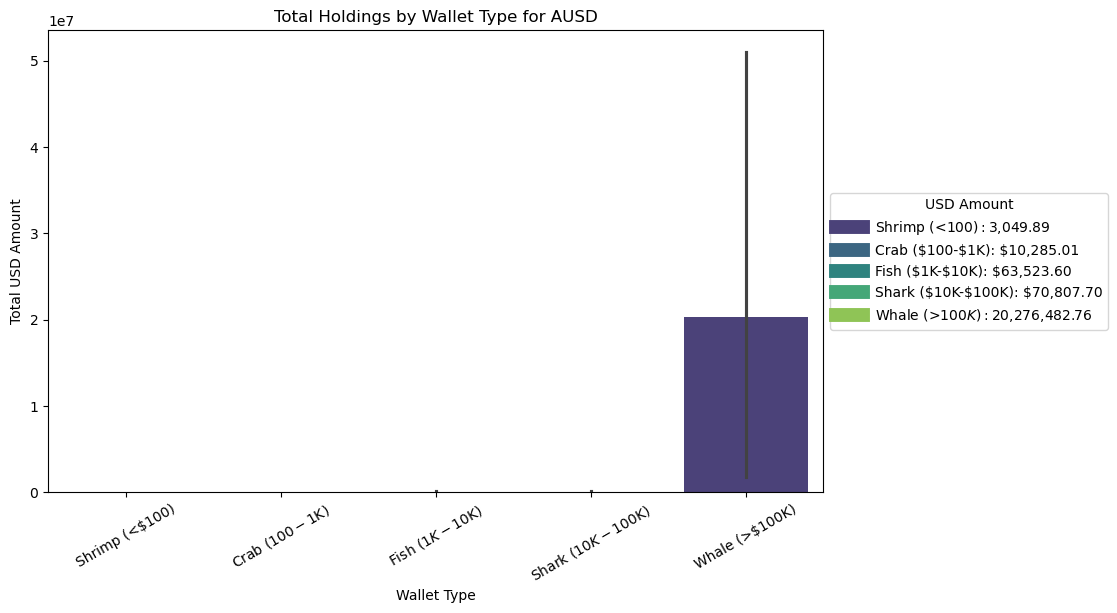

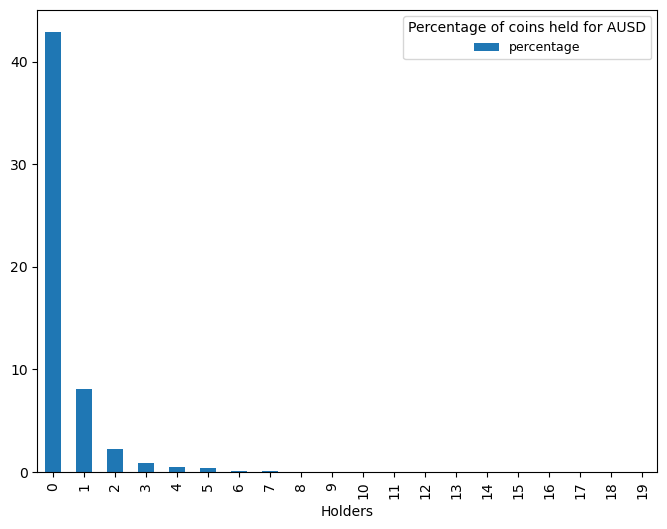

In [42]:
AUSD = pd.read_csv('holders/AUSD.csv') #load the holders csv

holders_plot(AUSD)